In [33]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from numpy.random import shuffle
import random
np.set_printoptions(threshold=np.inf)

batch_size = 64  # Batch size for training.
epochs = 350  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 26000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'
print(epochs)

350


In [18]:
import io

data_path = 'fra-eng/fra.txt'
file = open('dataset.txt','w',encoding="utf-8")

#with io.open(data_path, 'w', encoding=character_encoding) as file:
#    file.write(unicode_text)

check=0
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(' ')
    #f.write(foo.encode('utf8'))
    if(check==0):
        file.write(line)
    else:
        file.write('\n'+line)
    check=1    
    #print(line)
for line in lines[:10000]:
    input_text, target_text = line.split(' ')
    file.write('\n'+target_text+' '+target_text)
    
file.close()    

In [19]:
# Vectorize the data.
data_path = 'dataset.txt'
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    print(len(lines))
    print(lines[0])
    random.shuffle(lines)
    print(lines[0])
    
print(num_samples)    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(' ')
    # We use space(' ') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = ' ' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

36000
﻿অ্যান্ডেজ অ্যান্ডেজ
মতিউরের মতিউর
26000
Number of samples: 26000
Number of unique input tokens: 66
Number of unique output tokens: 67
Max sequence length for inputs: 22
Max sequence length for outputs: 22


In [22]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [57]:
all_char=[]
print("rana")
print(input_token_index)
print(input_token_index['ক'])
print(np.shape(encoder_input_data))

rana
{'¬': 0, 'ঁ': 1, 'ং': 2, 'ঃ': 3, 'অ': 4, 'আ': 5, 'ই': 6, 'ঈ': 7, 'উ': 8, 'ঊ': 9, 'ঋ': 10, 'এ': 11, 'ঐ': 12, 'ও': 13, 'ঔ': 14, 'ক': 15, 'খ': 16, 'গ': 17, 'ঘ': 18, 'ঙ': 19, 'চ': 20, 'ছ': 21, 'জ': 22, 'ঝ': 23, 'ঞ': 24, 'ট': 25, 'ঠ': 26, 'ড': 27, 'ঢ': 28, 'ণ': 29, 'ত': 30, 'থ': 31, 'দ': 32, 'ধ': 33, 'ন': 34, 'প': 35, 'ফ': 36, 'ব': 37, 'ভ': 38, 'ম': 39, 'য': 40, 'র': 41, 'ল': 42, 'শ': 43, 'ষ': 44, 'স': 45, 'হ': 46, 'া': 47, 'ি': 48, 'ী': 49, 'ু': 50, 'ূ': 51, 'ৃ': 52, 'ে': 53, 'ৈ': 54, 'ো': 55, 'ৌ': 56, '্': 57, 'ৎ': 58, 'ড়': 59, 'ঢ়': 60, 'য়': 61, '\u200c': 62, '\u200d': 63, '\u200f': 64, '\ufeff': 65}
15
(26000, 22, 66)


In [23]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [24]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(epochs)
# Run training
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

350
Train on 20800 samples, validate on 5200 samples
Epoch 1/350
20800/20800 [==============================] - 128s 6ms/step - loss: 0.9917 - acc: 0.7330 - val_loss: 0.9066 - val_acc: 0.7582
Epoch 2/350
20800/20800 [==============================] - 116s 6ms/step - loss: 0.8176 - acc: 0.7769 - val_loss: 0.7446 - val_acc: 0.7972
Epoch 3/350
20800/20800 [==============================] - 114s 5ms/step - loss: 0.6664 - acc: 0.8144 - val_loss: 0.6142 - val_acc: 0.8261
Epoch 4/350
20800/20800 [==============================] - 114s 5ms/step - loss: 0.5435 - acc: 0.8467 - val_loss: 0.4770 - val_acc: 0.8683
Epoch 5/350
20800/20800 [==============================] - 114s 5ms/step - loss: 0.4299 - acc: 0.8772 - val_loss: 0.3811 - val_acc: 0.8926
Epoch 6/350
20800/20800 [==============================] - 114s 5ms/step - loss: 0.3268 - acc: 0.9044 - val_loss: 0.2991 - val_acc: 0.9135
Epoch 7/350
20800/20800 [==============================] - 114s 5ms/step - loss: 0.2426 - acc: 0.9243 - val_loss:

20800/20800 [==============================] - 112s 5ms/step - loss: 7.3886e-04 - acc: 0.6086 - val_loss: 0.0399 - val_acc: 0.5838
Epoch 118/350
20800/20800 [==============================] - 113s 5ms/step - loss: 8.6283e-04 - acc: 0.6416 - val_loss: 0.0410 - val_acc: 0.6700
Epoch 119/350
20800/20800 [==============================] - 113s 5ms/step - loss: 8.9771e-04 - acc: 0.6527 - val_loss: 0.0405 - val_acc: 0.6201
Epoch 120/350
20800/20800 [==============================] - 113s 5ms/step - loss: 7.0902e-04 - acc: 0.6226 - val_loss: 0.0419 - val_acc: 0.6711
Epoch 121/350
20800/20800 [==============================] - 113s 5ms/step - loss: 7.4931e-04 - acc: 0.6195 - val_loss: 0.0392 - val_acc: 0.5939
Epoch 122/350
20800/20800 [==============================] - 113s 5ms/step - loss: 7.1372e-04 - acc: 0.6008 - val_loss: 0.0423 - val_acc: 0.5972
Epoch 123/350
20800/20800 [==============================] - 112s 5ms/step - loss: 7.6289e-04 - acc: 0.6142 - val_loss: 0.0446 - val_acc: 0.5701

20800/20800 [==============================] - 113s 5ms/step - loss: 2.4425e-04 - acc: 0.7449 - val_loss: 0.0464 - val_acc: 0.7301
Epoch 230/350
20800/20800 [==============================] - 113s 5ms/step - loss: 4.6772e-04 - acc: 0.7282 - val_loss: 0.0454 - val_acc: 0.6885
Epoch 231/350
20800/20800 [==============================] - 113s 5ms/step - loss: 2.5149e-04 - acc: 0.7249 - val_loss: 0.0426 - val_acc: 0.7256
Epoch 232/350
20800/20800 [==============================] - 113s 5ms/step - loss: 3.8085e-04 - acc: 0.7151 - val_loss: 0.0437 - val_acc: 0.6981
Epoch 233/350
20800/20800 [==============================] - 116s 6ms/step - loss: 3.6258e-04 - acc: 0.7135 - val_loss: 0.0459 - val_acc: 0.6717
Epoch 234/350
20800/20800 [==============================] - 123s 6ms/step - loss: 3.0715e-04 - acc: 0.7049 - val_loss: 0.0460 - val_acc: 0.7374
Epoch 235/350
20800/20800 [==============================] - 122s 6ms/step - loss: 3.3673e-04 - acc: 0.7255 - val_loss: 0.0445 - val_acc: 0.6940

20800/20800 [==============================] - 113s 5ms/step - loss: 1.6374e-04 - acc: 0.6821 - val_loss: 0.0486 - val_acc: 0.6828
Epoch 342/350
20800/20800 [==============================] - 113s 5ms/step - loss: 2.6005e-04 - acc: 0.7089 - val_loss: 0.0515 - val_acc: 0.7112
Epoch 343/350
20800/20800 [==============================] - 114s 5ms/step - loss: 3.3812e-04 - acc: 0.7097 - val_loss: 0.0521 - val_acc: 0.7038
Epoch 344/350
20800/20800 [==============================] - 113s 5ms/step - loss: 4.6039e-04 - acc: 0.6979 - val_loss: 0.0472 - val_acc: 0.6877
Epoch 345/350
20800/20800 [==============================] - 113s 5ms/step - loss: 3.9863e-04 - acc: 0.7146 - val_loss: 0.0486 - val_acc: 0.7027
Epoch 346/350
20800/20800 [==============================] - 112s 5ms/step - loss: 3.8633e-04 - acc: 0.7614 - val_loss: 0.0473 - val_acc: 0.7531
Epoch 347/350
20800/20800 [==============================] - 115s 6ms/step - loss: 4.5356e-04 - acc: 0.7466 - val_loss: 0.0481 - val_acc: 0.6884

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_7/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_7/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("test_model.h5")    

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3_9/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3_9/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [76]:
# Next: inference mode (sampling).
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
data_path = 'fra-eng/fra.txt'
print("kire")
model = load_model('s2s.h5')


encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence




def get_input_data(test_txt):
    #txt = input()
    txt=test_txt
    
    encoder_input_data = np.zeros(
    (len(txt), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    
    txt = txt.replace(' ', '')
    
    for t, char in enumerate(txt):
        encoder_input_data[0, t, input_token_index[char]] = 1.
        
    return encoder_input_data
    
    
    
    
# Take one sequence (part of the training set)
# for trying out decoding.
#input_seq = encoder_input_data[seq_index: seq_index + 1]

with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')

test_input_texts=[]
test_target_texts=[]
for line in test_lines[30000: 40005]:
    #print(line)
    test_input_text, test_target_text = line.split(' ')
    #print(test_input_text)
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text+'\n')
    
#print(test_input_texts)   

total_test_input=0
total_accuracy=0

for i in range(10000):
    total_test_input=total_test_input+1
    input_seq = get_input_data(test_input_texts[i])
    decoded_sentence = decode_sequence(input_seq)
    if (decoded_sentence==test_target_texts[i]):
        total_accuracy=total_accuracy+1
        #print('hoiche')
        
    print('Input sentence:',   test_input_texts[i])
    print('Decoded sentence:', decoded_sentence)
    #print(decoded_sentence[6])
    print('Target sentence:',  test_target_texts[i])
    #print(test_target_texts[i][6])
  
    
print('total_test_input:', total_test_input)
print('total_accuracy:', total_accuracy)
print('result:', (total_accuracy/total_test_input)*100,'%')

#yhat = model.predict(input_seq, verbose=0)
#print(yhat)

kire
Input sentence: আইনগুলোয়
Decoded sentence: আইন

Target sentence: আইন

Input sentence: পরিতোষকে
Decoded sentence: পরিষতোক

Target sentence: পরিতোষ

Input sentence: আইনগুলোর
Decoded sentence: আইন

Target sentence: আইন

Input sentence: ট্রোজানের
Decoded sentence: ট্রোজান

Target sentence: ট্রোজান

Input sentence: এনটিপিসিকে
Decoded sentence: এনটিপিসি

Target sentence: এনটিপিসি

Input sentence: গণনাতে
Decoded sentence: গণনাত

Target sentence: গণনা

Input sentence: থাইয়ের
Decoded sentence: থাই

Target sentence: থাই

Input sentence: বার্সেলোনারই
Decoded sentence: বার্সেলোনা

Target sentence: বার্সেলোনা

Input sentence: লিগনিনের
Decoded sentence: লিগনিন

Target sentence: লিগনিন

Input sentence: কুর্মীর
Decoded sentence: কুর্মী

Target sentence: কুর্মী

Input sentence: মেশিনগুলো
Decoded sentence: মেশিন

Target sentence: মেশিন

Input sentence: ফেরারির
Decoded sentence: ফেরারি

Target sentence: ফেরারি

Input sentence: অ্যাভাটারের
Decoded sentence: অ্যাভাটার

Target sentence: অ্যাভাটার

Inpu

Input sentence: অর্জুনকে
Decoded sentence: অর্জুন

Target sentence: অর্জুন

Input sentence: উপনির্বাচনটিতে
Decoded sentence: উপনির্বাচন

Target sentence: উপনির্বাচন

Input sentence: বনভূমিগুলো
Decoded sentence: বনভূমি

Target sentence: বনভূমি

Input sentence: বাচ্চার
Decoded sentence: বাচ্চা

Target sentence: বাচ্চা

Input sentence: গুটির
Decoded sentence: গুটি

Target sentence: গুটি

Input sentence: উর্দুর
Decoded sentence: উর্দু

Target sentence: উর্দু

Input sentence: সঞ্চয়পত্রই
Decoded sentence: সঞ্চয়পত্র

Target sentence: সঞ্চয়পত্র

Input sentence: গণগ্রেপ্তারের
Decoded sentence: গণগ্রেপ্তার

Target sentence: গণগ্রেপ্তার

Input sentence: বন্দীকে
Decoded sentence: বন্দী

Target sentence: বন্দী

Input sentence: দিকটা
Decoded sentence: দিক

Target sentence: দিক

Input sentence: লেপ্যানের
Decoded sentence: লেপ্যান

Target sentence: লেপ্যান

Input sentence: কাদরীর
Decoded sentence: কাদরী

Target sentence: কাদরী

Input sentence: স্লেইম্যানের
Decoded sentence: স্লেইম্যান

Target sentence

Input sentence: জনপদে
Decoded sentence: জনপদ

Target sentence: জনপদ

Input sentence: বিএসএমএমইউতে
Decoded sentence: বিএসএমএমইউ

Target sentence: বিএসএমএমইউ

Input sentence: প্রতিষ্ঠানগুলোকেই
Decoded sentence: প্রতিষ্ঠান

Target sentence: প্রতিষ্ঠান

Input sentence: প্রতিষ্ঠানগুলোকেও
Decoded sentence: প্রতিষ্ঠান

Target sentence: প্রতিষ্ঠান

Input sentence: সৃষ্টিই
Decoded sentence: সৃষ্টি

Target sentence: সৃষ্টি

Input sentence: নিয়ন্ত্রণব্যবস্থাকে
Decoded sentence: নিয়ন্ত্রণব্যবস্থা

Target sentence: নিয়ন্ত্রণব্যবস্থা

Input sentence: কারনেবোর
Decoded sentence: কারনেবো

Target sentence: কারনেবো

Input sentence: এমডিপির
Decoded sentence: এমডিপি

Target sentence: এমডিপি

Input sentence: ঘোড়াগুলো
Decoded sentence: ঘোড়া

Target sentence: ঘোড়া

Input sentence: সাদেককে
Decoded sentence: সাদেক

Target sentence: সাদেক

Input sentence: র্যাংকসটেলের
Decoded sentence: র্যাংকস

Target sentence: র্যাংকসটেল

Input sentence: খেলোয়াড়ে
Decoded sentence: খেলোয়াড়

Target sentence: খেলোয়াড়

Input senten

Input sentence: নৌবন্দরে
Decoded sentence: নৌবন্দর

Target sentence: নৌবন্দর

Input sentence: গণমাধ্যমগুলো
Decoded sentence: গণমাধ্যম

Target sentence: গণমাধ্যম

Input sentence: ভারতে
Decoded sentence: ভারত

Target sentence: ভারত

Input sentence: চেয়ারম্যানঘাটে
Decoded sentence: চেয়ারম্যান

Target sentence: চেয়ারম্যানঘাট

Input sentence: ঘুড়িবিদেরা
Decoded sentence: ঘুড়িবিদ

Target sentence: ঘুড়িবিদ

Input sentence: গুজবে
Decoded sentence: গুজব

Target sentence: গুজব

Input sentence: পেলেগ্রিনির
Decoded sentence: পেলেট্রিমি

Target sentence: পেলেগ্রিনি

Input sentence: পতনে
Decoded sentence: পতন

Target sentence: পতন

Input sentence: সুইচের
Decoded sentence: সুইচ

Target sentence: সুইচ

Input sentence: রুজির
Decoded sentence: রুজি

Target sentence: রুজি

Input sentence: ফোরকানের
Decoded sentence: ফোরকান

Target sentence: ফোরকান

Input sentence: চাকলাদারের
Decoded sentence: চাকলাদার

Target sentence: চাকলাদার

Input sentence: ক্ল্যাসিকের
Decoded sentence: ক্লাস্যিক

Target sentence: ক্ল

Input sentence: খেলোয়াড়টির
Decoded sentence: খেলোয়াড়

Target sentence: খেলোয়াড়

Input sentence: ক্যাননের
Decoded sentence: ক্যানন

Target sentence: ক্যানন

Input sentence: জর্জের
Decoded sentence: জর্জ

Target sentence: জর্জ

Input sentence: জানিয়েই
Decoded sentence: জানিয়

Target sentence: জানি

Input sentence: বইয়েই
Decoded sentence: বই

Target sentence: বই

Input sentence: বইয়েও
Decoded sentence: বই

Target sentence: বই

Input sentence: কাতারকে
Decoded sentence: কাতার

Target sentence: কাতার

Input sentence: বইয়ের
Decoded sentence: বই

Target sentence: বই

Input sentence: বিএমএফএর
Decoded sentence: বিএমএফএ

Target sentence: বিএমএফএ

Input sentence: গাদ্দাফিপন্থীরা
Decoded sentence: গাদ্মাপখ্রিচ্র

Target sentence: গাদ্দাফিপন্থী

Input sentence: পণ্যকরণের
Decoded sentence: পণ্যকরণ

Target sentence: পণ্যকরণ

Input sentence: আসিমভের
Decoded sentence: আসিমভ

Target sentence: আসিমভ

Input sentence: খোপের
Decoded sentence: খোপ

Target sentence: খোপে

Input sentence: যিনিই
Decoded sentence

Input sentence: জীবনটাকে
Decoded sentence: জীবন

Target sentence: জীবন

Input sentence: খবরকেও
Decoded sentence: খবর

Target sentence: খবর

Input sentence: আপলোডের
Decoded sentence: আপলোড

Target sentence: আপলোড

Input sentence: মেহরুদিনকে
Decoded sentence: মেহরুদিন

Target sentence: মেহরুদিন

Input sentence: কাজিনকে
Decoded sentence: কাজিন

Target sentence: কাজিন

Input sentence: কার্নিশেই
Decoded sentence: কার্নিশ

Target sentence: কার্নিশে

Input sentence: ব্রংকহর্স্টের
Decoded sentence: ব্রংহক্রস্থ

Target sentence: ব্রংকহর্স্ট

Input sentence: খুবির
Decoded sentence: খুবি

Target sentence: খুবি

Input sentence: বার্তাবাহককে
Decoded sentence: বার্তাবাহক

Target sentence: বার্তাবাহক

Input sentence: রাজিনের
Decoded sentence: রাজিন

Target sentence: রাজিন

Input sentence: হাজীগঞ্জে
Decoded sentence: হাজীগঞ্জ

Target sentence: হাজীগঞ্জ

Input sentence: সংশোধনীগুলো
Decoded sentence: সংশোধনী

Target sentence: সংশোধনী

Input sentence: নিয়াই
Decoded sentence: নিয়া

Target sentence: নিয়া



Input sentence: ব্যাংকিংয়ের
Decoded sentence: ব্যাংকিং

Target sentence: ব্যাংকিং

Input sentence: উপদ্রবে
Decoded sentence: উপদ্রব

Target sentence: উপদ্রব

Input sentence: গোলাপগুলো
Decoded sentence: গোলাপ

Target sentence: গোলাপ

Input sentence: বন্টনের
Decoded sentence: বন্টন

Target sentence: বন্টন

Input sentence: মুরগির
Decoded sentence: মুরগি

Target sentence: মুরগি

Input sentence: ঋণখেলাপিরা
Decoded sentence: ঋণ

Target sentence: ঋণখেলাপি

Input sentence: মৈত্রর
Decoded sentence: মৈত্র

Target sentence: মৈত্র

Input sentence: মুরগিই
Decoded sentence: মুরগি

Target sentence: মুরগি

Input sentence: টিনশেডগুলোর
Decoded sentence: টিনশেড

Target sentence: টিনশেড

Input sentence: দৃশ্যটায়
Decoded sentence: দৃশ্য

Target sentence: দৃশ্য

Input sentence: মুরগিও
Decoded sentence: মুরগি

Target sentence: মুরগি

Input sentence: সেলিমের
Decoded sentence: সেলিম

Target sentence: সেলিম

Input sentence: ঋতুকে
Decoded sentence: ঋতু

Target sentence: ঋতু

Input sentence: ঘাসপাখির
Decoded sent

Input sentence: কানপুরের
Decoded sentence: কানপুর

Target sentence: কানপুরে

Input sentence: বলিভিয়ার
Decoded sentence: বলিভিয়া

Target sentence: বলিভিয়া

Input sentence: অর্ধেকটাকে
Decoded sentence: অর্ধেকেটক

Target sentence: অর্ধেকটা

Input sentence: বলিভিয়ায়
Decoded sentence: বলিভিয়া

Target sentence: বলিভিয়া

Input sentence: উৎদনের
Decoded sentence: উৎদন

Target sentence: উৎদন

Input sentence: করেরহাটে
Decoded sentence: কররেহাটর

Target sentence: করেরহাট

Input sentence: অ্যাটেনডেন্টকে
Decoded sentence: অ্যাটেনেড্ট

Target sentence: অ্যাটেনডেন্ট

Input sentence: শেয়ারগুলো
Decoded sentence: শেয়ার

Target sentence: শেয়ার

Input sentence: কার্যকলাপকে
Decoded sentence: কার্যকালপ

Target sentence: কার্যকলাপ

Input sentence: কেমিস্ট্রির
Decoded sentence: কেমিস্ট্র

Target sentence: কেমিস্ট্রি

Input sentence: খরচটাই
Decoded sentence: খরচ

Target sentence: খরচ

Input sentence: নান্টুদের
Decoded sentence: নান্টু

Target sentence: নান্টু

Input sentence: রেজিমেন্টকে
Decoded sentence: রেজিম

Input sentence: প্রক্টরকে
Decoded sentence: প্রক্টর

Target sentence: প্রক্টর

Input sentence: পর্যবেক্ষণেও
Decoded sentence: পর্যবেক্ষণ

Target sentence: পর্যবেক্ষণ

Input sentence: সাবেরের
Decoded sentence: সাবের

Target sentence: সাব

Input sentence: প্রক্টররা
Decoded sentence: প্রক্টর

Target sentence: প্রক্টর

Input sentence: মহাব্যবস্থাপককে
Decoded sentence: মহাব্যবস্থা

Target sentence: মহাব্যবস্থাপক

Input sentence: ধারাবাহিকে
Decoded sentence: ধারাবাহিক

Target sentence: ধারাবাহিক

Input sentence: পর্যবেক্ষণের
Decoded sentence: পর্যবেক্ষণ

Target sentence: পর্যবেক্ষণ

Input sentence: বিজেএমসির
Decoded sentence: বিজেএমসি

Target sentence: বিজেএমসি

Input sentence: গণপরিবহনব্যবস্থার
Decoded sentence: গণপরিবহনব্যবস্থা

Target sentence: গণপরিবহনব্যবস্থা

Input sentence: এথনিকার
Decoded sentence: এথনিকা

Target sentence: এথনিকা

Input sentence: বন্ডকে
Decoded sentence: বন্ড

Target sentence: বন্ড

Input sentence: গিডনের
Decoded sentence: গিডন

Target sentence: গিডন

Input sentence:

Input sentence: সংর্ঘষে
Decoded sentence: সংর্ষণ

Target sentence: সংর্ঘষ

Input sentence: সাবেরকে
Decoded sentence: সাবের

Target sentence: সাব

Input sentence: উদ্যোগটিকে
Decoded sentence: উদ্যোগ

Target sentence: উদ্যোগ

Input sentence: বিয়েটাকে
Decoded sentence: বিয়েটা

Target sentence: বিয়ে

Input sentence: ভূমিকাকে
Decoded sentence: ভূমিকার

Target sentence: ভূমিকা

Input sentence: মরিনহোও
Decoded sentence: মরিনহো

Target sentence: মরিনহো

Input sentence: ফরোয়ার্ডরা
Decoded sentence: ফরোয়ার্ড

Target sentence: ফরোয়ার্ড

Input sentence: মরিনহোই
Decoded sentence: মরিনহো

Target sentence: মরিনহো

Input sentence: উনারে
Decoded sentence: উনার

Target sentence: উনার

Input sentence: মধ্যদিনে
Decoded sentence: মধ্যদিন

Target sentence: মধ্যদিন

Input sentence: শহীদুরের
Decoded sentence: শহীদুর

Target sentence: শহীদুর

Input sentence: উনের
Decoded sentence: উনের

Target sentence: উন

Input sentence: তোতার
Decoded sentence: তোতার

Target sentence: তোতা

Input sentence: পিংকীকে
Decoded se

Input sentence: প্রসুতিদের
Decoded sentence: প্রসুতি

Target sentence: প্রসুতি

Input sentence: তাইয়েবাই
Decoded sentence: তাইয়েবা

Target sentence: তাইয়েবা

Input sentence: দৈর্ঘ্যে
Decoded sentence: দৈর্ঘ্য

Target sentence: দৈর্ঘ্য

Input sentence: পদ্মদের
Decoded sentence: পদ্মদ

Target sentence: পদ্ম

Input sentence: ব্যবসাপ্রতিষ্ঠানে
Decoded sentence: ব্যবসাপ্রতিষ্ঠান

Target sentence: ব্যবসাপ্রতিষ্ঠান

Input sentence: উদ্যোগটাকে
Decoded sentence: উদ্যোগ

Target sentence: উদ্যোগ

Input sentence: থেরাপিতে
Decoded sentence: থেরাপি

Target sentence: থেরাপি

Input sentence: মূলঘরের
Decoded sentence: মূলঘর

Target sentence: মূলঘর

Input sentence: প্রবঞ্চনার
Decoded sentence: প্রবঞ্চান

Target sentence: প্রবঞ্চনা

Input sentence: কানকুনে
Decoded sentence: কানকুন

Target sentence: কানকুন

Input sentence: হেলিকপ্টারও
Decoded sentence: হেলিকপ্টার

Target sentence: হেলিকপ্টার

Input sentence: রেজাল্টের
Decoded sentence: রেজাল্ট

Target sentence: রেজাল্ট

Input sentence: নিরীক্ষণের
Decoded 

Input sentence: নদীশাসনের
Decoded sentence: নদীশাসন

Target sentence: নদীশাসন

Input sentence: প্রণেতারাও
Decoded sentence: প্রণেতা

Target sentence: প্রণেতা

Input sentence: নৃবিজ্ঞানের
Decoded sentence: নৃবিজ্ঞান

Target sentence: নৃবিজ্ঞান

Input sentence: নবদ্বীপেই
Decoded sentence: নবদ্বীপ

Target sentence: নবদ্বীপ

Input sentence: পীরগঞ্জের
Decoded sentence: পীরগঞ্জ

Target sentence: পীরগঞ্জ

Input sentence: ফরম্যাটেই
Decoded sentence: ফরম্যাট

Target sentence: ফরম্যাট

Input sentence: দলগুলোই
Decoded sentence: দল

Target sentence: দল

Input sentence: ফরম্যাটেও
Decoded sentence: ফরম্যাট

Target sentence: ফরম্যাট

Input sentence: পুত্রবধূর
Decoded sentence: পুত্রবধূ

Target sentence: পুত্রবধূ

Input sentence: মুখচ্ছবির
Decoded sentence: মুখচ্ছবি

Target sentence: মুখচ্ছবি

Input sentence: দুঃসংবাদটা
Decoded sentence: দুঃসংবাদ

Target sentence: দুঃসংবাদ

Input sentence: দুঃসংবাদটি
Decoded sentence: দুঃসংবাদ

Target sentence: দুঃসংবাদ

Input sentence: দলগুলোও
Decoded sentence: দল

T

Input sentence: বিজয়ীরা
Decoded sentence: বিজয়ী

Target sentence: বিজয়ী

Input sentence: পাইয়ে
Decoded sentence: পা

Target sentence: পা

Input sentence: মনোগ্রামে
Decoded sentence: মনোগ্রাম

Target sentence: মনোগ্রাম

Input sentence: জাদুঘরেরই
Decoded sentence: জাদুঘর

Target sentence: জাদুঘর

Input sentence: নামগুলোর
Decoded sentence: নাম

Target sentence: নাম

Input sentence: ডিএফআইয়ের
Decoded sentence: ডিএফআই

Target sentence: ডিএফআই

Input sentence: ঝুরির
Decoded sentence: ঝুরি

Target sentence: ঝুরি

Input sentence: বিয়েতেও
Decoded sentence: বিয়েত

Target sentence: বিয়ে

Input sentence: ওগুলোকে
Decoded sentence: ওওঙোল

Target sentence: ওগুলো

Input sentence: গণরুমে
Decoded sentence: গণরুম

Target sentence: গণরুম

Input sentence: থামতেও
Decoded sentence: থামত

Target sentence: থামতে

Input sentence: থামতেই
Decoded sentence: থামত

Target sentence: থামতে

Input sentence: এয়ারলাইনসের
Decoded sentence: এয়ারলাইনস

Target sentence: এয়ারলাইনস

Input sentence: সমাধানকে
Decoded sentence: স

Input sentence: ট্রেন্টও
Decoded sentence: ট্রেন্টপ

Target sentence: ট্রেন্ট

Input sentence: বুগতির
Decoded sentence: বুগতি

Target sentence: বুগতি

Input sentence: অপরাধকে
Decoded sentence: অপরাধ

Target sentence: অপরাধ

Input sentence: উত্তরাধিকারকে
Decoded sentence: উত্তরুধারিয়া

Target sentence: উত্তরাধিকার

Input sentence: পানিসংকটের
Decoded sentence: পানিসংকট

Target sentence: পানিসংকট

Input sentence: মানবশিশুকে
Decoded sentence: মানবশিশু

Target sentence: মানবশিশু

Input sentence: রাজস্তানের
Decoded sentence: রাজস্তান

Target sentence: রাজস্তান

Input sentence: তথ্যচিত্রে
Decoded sentence: তথ্যচিত্র

Target sentence: তথ্যচিত্র

Input sentence: টিকেটের
Decoded sentence: টিকেট

Target sentence: টিকেট

Input sentence: মাছটির
Decoded sentence: মাছ

Target sentence: মাছ

Input sentence: বনায়নের
Decoded sentence: বনানয়

Target sentence: বনায়ন

Input sentence: খাদ্যসামগ্রীর
Decoded sentence: খাদ্যসামগ্রী

Target sentence: খাদ্যসামগ্রী

Input sentence: প্রতিদ্বন্দ্বিতাটা
Decoded sent

Input sentence: অধিবেশনটি
Decoded sentence: অধিবেশন

Target sentence: অধিবেশন

Input sentence: অধিবেশনটা
Decoded sentence: অধিবেশন

Target sentence: অধিবেশন

Input sentence: পিরিস্ত্রোইকাকে
Decoded sentence: পিরিস্ত্রোইকা

Target sentence: পিরিস্ত্রোইকা

Input sentence: রিপোর্টাররা
Decoded sentence: রিপোর্টার

Target sentence: রিপোর্টার

Input sentence: ওভারটাই
Decoded sentence: ওভার

Target sentence: ওভার

Input sentence: শরীরচর্চার
Decoded sentence: শরীরচর্চা

Target sentence: শরীরচর্চা

Input sentence: ওলাঁদকেই
Decoded sentence: ওলাঁদ

Target sentence: ওলাঁদ

Input sentence: কবিরুলকে
Decoded sentence: কবিরুল

Target sentence: কবিরুল

Input sentence: ডিগারের
Decoded sentence: ডিগার

Target sentence: ডিগার

Input sentence: দর্শানোর
Decoded sentence: দর্শানো

Target sentence: দর্শানো

Input sentence: গবেষণাপত্রকে
Decoded sentence: গবেষণাপত্র

Target sentence: গবেষণাপত্র

Input sentence: স্ক্যানারের
Decoded sentence: স্ক্যানার

Target sentence: স্ক্যানার

Input sentence: জয়ললিতার
Decode

Input sentence: অধিবেশনেই
Decoded sentence: অধিবেশন

Target sentence: অধিবেশন

Input sentence: কথিকায়
Decoded sentence: কথিকা

Target sentence: কথিকা

Input sentence: তোদের
Decoded sentence: তো

Target sentence: তো

Input sentence: দীর্ঘদিনের
Decoded sentence: দীর্ঘনদির

Target sentence: দীর্ঘদিন

Input sentence: মাত্রাগুলোর
Decoded sentence: মাত্রা

Target sentence: মাত্রা

Input sentence: সকলেরই
Decoded sentence: সকল

Target sentence: সকল

Input sentence: এনভিডিয়ার
Decoded sentence: এনভিডিয়া

Target sentence: এনভিডিয়া

Input sentence: ক্রিকেটপ্রেমীরা
Decoded sentence: ক্রিকেটপ্রে

Target sentence: ক্রিকেটপ্রেমী

Input sentence: কাচবালুতে
Decoded sentence: কাচাবুল

Target sentence: কাচবালু

Input sentence: জাহাজভাঙায়
Decoded sentence: জাহাজভাঙা

Target sentence: জাহাজভাঙা

Input sentence: অনুগতদের
Decoded sentence: অনুগত

Target sentence: অনুগত

Input sentence: অধিবেশনের
Decoded sentence: অধিবেশন

Target sentence: অধিবেশন

Input sentence: সকলেরে
Decoded sentence: সকল

Target sentence:

Input sentence: ক্রুর
Decoded sentence: ক্রু

Target sentence: ক্রু

Input sentence: অভ্যুত্থানের
Decoded sentence: অভ্যুত্থান

Target sentence: অভ্যুত্থান

Input sentence: ফিনকে
Decoded sentence: ফিন

Target sentence: ফিন

Input sentence: নভোযানটির
Decoded sentence: নভোযান

Target sentence: নভোযান

Input sentence: যুদ্ধবিমানগুলোয়
Decoded sentence: যুদ্ধবিমান

Target sentence: যুদ্ধবিমান

Input sentence: রিকশাশ্রমিকের
Decoded sentence: রিকশাশ্রমিক

Target sentence: রিকশাশ্রমিক

Input sentence: সিসিতে
Decoded sentence: সিসি

Target sentence: সিসি

Input sentence: মাংসও
Decoded sentence: মাংস

Target sentence: মাংস

Input sentence: আল্টিমেটামের
Decoded sentence: আল্টিমেটাম

Target sentence: আল্টিমেটাম

Input sentence: ক্ষতের
Decoded sentence: ক্ষত

Target sentence: ক্ষত

Input sentence: সরওয়ার্দীর
Decoded sentence: সরওয়ার্দী

Target sentence: সরওয়ার্দী

Input sentence: সিএমসির
Decoded sentence: সিএমসি

Target sentence: সিএমসি

Input sentence: নীলফামারীর
Decoded sentence: নীলফামা

Target 

Input sentence: মহেশখালীর
Decoded sentence: মহেশখালী

Target sentence: মহেশখালী

Input sentence: লাশটাও
Decoded sentence: লাশ

Target sentence: লাশ

Input sentence: জামানও
Decoded sentence: জামান

Target sentence: জামান

Input sentence: শিশুপুত্রকে
Decoded sentence: শিশুপুত্র

Target sentence: শিশুপুত্র

Input sentence: তাহাদিগকেই
Decoded sentence: তাহাদিগ

Target sentence: তাহা

Input sentence: অসমিয়ারা
Decoded sentence: অসমিয়া

Target sentence: অসমিয়া

Input sentence: লাশটাই
Decoded sentence: লাশ

Target sentence: লাশ

Input sentence: লিগটাই
Decoded sentence: লিগ

Target sentence: লিগ

Input sentence: ক্লিনিকটির
Decoded sentence: ক্লিনিকটি

Target sentence: ক্লিনিক

Input sentence: হেল্পলাইনের
Decoded sentence: হেল্পলাইন

Target sentence: হেল্পলাইন

Input sentence: সরকারটি
Decoded sentence: সরকার

Target sentence: সরকার

Input sentence: সুশাসনে
Decoded sentence: সুশাসন

Target sentence: সুশাসন

Input sentence: আকিকার
Decoded sentence: আকিকার

Target sentence: আকিকা

Input sentence: জ

Input sentence: চ্যানই
Decoded sentence: চ্যান

Target sentence: চ্যান

Input sentence: হাতিরপুলে
Decoded sentence: হাতিরপুল

Target sentence: হাতিরপুল

Input sentence: পাটবীজের
Decoded sentence: পাটবীজ

Target sentence: পাটবীজ

Input sentence: ইমেজিংয়ের
Decoded sentence: ইমেজিং

Target sentence: ইমেজিং

Input sentence: আকাশটা
Decoded sentence: আকাশ

Target sentence: আকাশ

Input sentence: নাসিমের
Decoded sentence: নাসিম

Target sentence: নাসিম

Input sentence: খণ্ডনও
Decoded sentence: খণ্ডন

Target sentence: খণ্ডন

Input sentence: লেখাপড়ায়
Decoded sentence: লেখাপড়া

Target sentence: লেখাপড়া

Input sentence: ওয়েস্টকে
Decoded sentence: ওয়েস্ট

Target sentence: ওয়েস্ট

Input sentence: দাসশ্রমের
Decoded sentence: দাসশ্রম

Target sentence: দাসশ্রমে

Input sentence: পুলিয়ামারীর
Decoded sentence: পুলিয়ামারী

Target sentence: পুলিয়ামারী

Input sentence: বাঁহাতির
Decoded sentence: বাঁহাতি

Target sentence: বাঁহাতি

Input sentence: জামিনও
Decoded sentence: জামিন

Target sentence: জামিন

Input se

Input sentence: শিবপুরের
Decoded sentence: শিবপুর

Target sentence: শিবপুর

Input sentence: স্যালনের
Decoded sentence: স্যালন

Target sentence: স্যালন

Input sentence: প্রাণভিক্ষার
Decoded sentence: প্রাণভিক্ষা

Target sentence: প্রাণভিক্ষা

Input sentence: বিড়ালের
Decoded sentence: বিড়াল

Target sentence: বিড়াল

Input sentence: প্রতিরক্ষার
Decoded sentence: প্রতিরক্ষা

Target sentence: প্রতিরক্ষা

Input sentence: প্রতিরক্ষায়
Decoded sentence: প্রতিরক্ষা

Target sentence: প্রতিরক্ষা

Input sentence: মাউসে
Decoded sentence: মাউস

Target sentence: মাউস

Input sentence: মহাব্যবস্থাপকের
Decoded sentence: মহাব্যবস্থা

Target sentence: মহাব্যবস্থাপক

Input sentence: সার্দাইকোভের
Decoded sentence: সার্দাইকোষে

Target sentence: সার্দাইকোভ

Input sentence: ধারাসমূহের
Decoded sentence: ধারামূহ

Target sentence: ধারা

Input sentence: কূপগুলোতে
Decoded sentence: কূপ

Target sentence: কূপ

Input sentence: ভিটেবাড়িটির
Decoded sentence: ভিটেবাড়ি

Target sentence: ভিটেবাড়ি

Input sentence: ট্রেনেরই
De

Input sentence: নিকটাত্মীয়রা
Decoded sentence: নিকটাত্মী

Target sentence: নিকটাত্মীয়

Input sentence: বিশ্ববিদ্যালয়গুলোয়
Decoded sentence: বিশ্ববিদ্যালয়

Target sentence: বিশ্ববিদ্যালয়

Input sentence: হারাতেই
Decoded sentence: হারাত

Target sentence: হারাতে

Input sentence: বিএসটিআইর
Decoded sentence: বিএসটিআর

Target sentence: বিএসটিআই

Input sentence: ডপলারের
Decoded sentence: ডপলার

Target sentence: ডপলার

Input sentence: একাদশে
Decoded sentence: একাশদ

Target sentence: একাদশ

Input sentence: গৃহস্থালির
Decoded sentence: গৃহস্থালি

Target sentence: গৃহস্থালি

Input sentence: শ্রীরামপুরের
Decoded sentence: শ্রীরামপুর

Target sentence: শ্রীরামপুর

Input sentence: ছোটটা
Decoded sentence: ছোট

Target sentence: ছোট

Input sentence: ছোটটি
Decoded sentence: ছোট

Target sentence: ছোট

Input sentence: কাজিনের
Decoded sentence: কাজিন

Target sentence: কাজিন

Input sentence: কোরককে
Decoded sentence: কোরক

Target sentence: কোরক

Input sentence: ফোরকানও
Decoded sentence: ফোরকান

Target sentenc

Input sentence: উদ্যোগেই
Decoded sentence: উদ্যোগ

Target sentence: উদ্যোগ

Input sentence: রেলগেটে
Decoded sentence: রেলগেট

Target sentence: রেলগেট

Input sentence: কাঁচপুরে
Decoded sentence: কাঁচপুর

Target sentence: কাঁচপুর

Input sentence: নেকড়ের
Decoded sentence: নেকড়

Target sentence: নেকড়ে

Input sentence: মাইরা
Decoded sentence: মাইরা

Target sentence: মা

Input sentence: বিদায়ে
Decoded sentence: বিদায়

Target sentence: বিদায়

Input sentence: খুনের
Decoded sentence: খুন

Target sentence: খুন

Input sentence: শ্বাসকষ্টে
Decoded sentence: শ্বাসকষ্ট

Target sentence: শ্বাসকষ্ট

Input sentence: বিদ্যুেকন্দ্রে
Decoded sentence: বিদ্যুেকন্দ্র

Target sentence: বিদ্যুেকন্দ্র

Input sentence: হিমুর
Decoded sentence: হিমু

Target sentence: হিমু

Input sentence: পিপলসটেলে
Decoded sentence: পিপলসেটলা

Target sentence: পিপলসটেল

Input sentence: খানটিই
Decoded sentence: খান

Target sentence: খান

Input sentence: সুপারিশে
Decoded sentence: সুপারিশ

Target sentence: সুপারিশ

Input sentence: 

Input sentence: কোরআনে
Decoded sentence: কোরআন

Target sentence: কোরআন

Input sentence: মেলিন্ডার
Decoded sentence: মেলিন্ডার

Target sentence: মেলিন্ডা

Input sentence: বিলবোর্ডগুলোর
Decoded sentence: বিলবোর্ড

Target sentence: বিলবোর্ড

Input sentence: আমিনুলরা
Decoded sentence: আমিনুল

Target sentence: আমিনুল

Input sentence: জনমতকে
Decoded sentence: জনমত

Target sentence: জনমত

Input sentence: সুন্দলপুরেরটি
Decoded sentence: সুন্দলপুর

Target sentence: সুন্দলপুর

Input sentence: রোদেলার
Decoded sentence: রোদেলা

Target sentence: রোদেলা

Input sentence: পাজেরোটিও
Decoded sentence: পাজেরো

Target sentence: পাজেরো

Input sentence: ইস্রাফিলকে
Decoded sentence: ইস্রাফিল

Target sentence: ইস্রাফিল

Input sentence: বলটাতে
Decoded sentence: বল

Target sentence: বল

Input sentence: ব্রাউজারে
Decoded sentence: ব্রাউজার

Target sentence: ব্রাউজার

Input sentence: গুয়াতেমালার
Decoded sentence: গুয়াতেমালা

Target sentence: গুয়াতেমালা

Input sentence: অনুষ্ঠানগুলোর
Decoded sentence: অনুষ্ঠান

Ta

Input sentence: সেতুতেই
Decoded sentence: সেতু

Target sentence: সেতু

Input sentence: খেলানোকে
Decoded sentence: খেলানো

Target sentence: খেলানো

Input sentence: ব্যবস্থাও
Decoded sentence: ব্যবস্থা

Target sentence: ব্যবস্থা

Input sentence: আইটিইউর
Decoded sentence: আইটিইউ

Target sentence: আইটিইউ

Input sentence: পাঠচক্রে
Decoded sentence: পাঠচক্র

Target sentence: পাঠচক্র

Input sentence: আমিনুলকে
Decoded sentence: আমিনুল

Target sentence: আমিনুল

Input sentence: এন্দেল্লাহর
Decoded sentence: এন্দেল্লাহ

Target sentence: এন্দেল্লাহ

Input sentence: ব্যবস্থার
Decoded sentence: ব্যবস্থা

Target sentence: ব্যবস্থা

Input sentence: পুনর্গণনার
Decoded sentence: পুনর্গণনা

Target sentence: পুনর্গণনা

Input sentence: বালিতে
Decoded sentence: বালি

Target sentence: বালি

Input sentence: শিববাড়িয়ার
Decoded sentence: শিববাড়িয়া

Target sentence: শিববাড়িয়া

Input sentence: লোহানের
Decoded sentence: লোহান

Target sentence: লোহান

Input sentence: পুনর্গণনায়
Decoded sentence: পুনর্ণগান

Target s

Input sentence: গ্যাটলিনের
Decoded sentence: গ্যাটলিন

Target sentence: গ্যাটলিন

Input sentence: মোটরসাইকেলের
Decoded sentence: মোটরসাইকেল

Target sentence: মোটরসাইকেল

Input sentence: করানোটাই
Decoded sentence: করানো

Target sentence: করানোটা

Input sentence: ভাঁড়ের
Decoded sentence: ভাঁড়ে

Target sentence: ভাঁড়

Input sentence: সাশ্রয়ে
Decoded sentence: সাশ্রয়

Target sentence: সাশ্রয়

Input sentence: ব্যক্তিত্বই
Decoded sentence: ব্যক্তিত্ব

Target sentence: ব্যক্তিত্ব

Input sentence: জাভিদের
Decoded sentence: জাভিদ

Target sentence: জাভি

Input sentence: ওকাম্পোর
Decoded sentence: ওকাম্পো

Target sentence: ওকাম্পো

Input sentence: সাশ্রয়ও
Decoded sentence: সাশ্রয়

Target sentence: সাশ্রয়

Input sentence: তথ্যগুলোর
Decoded sentence: তথ্য

Target sentence: তথ্য

Input sentence: আগরতলার
Decoded sentence: আগরতলার

Target sentence: আগরতলা

Input sentence: দুপচাঁচিয়ার
Decoded sentence: দুপচাঁচিয়া

Target sentence: দুপচাঁচিয়া

Input sentence: জঙ্গিরাই
Decoded sentence: জঙ্গি

Target sen

Input sentence: রিনার
Decoded sentence: রিনা

Target sentence: রিনা

Input sentence: রাগবিতে
Decoded sentence: রাগবি

Target sentence: রাগবি

Input sentence: লবির
Decoded sentence: লবির

Target sentence: লবি

Input sentence: ত্রেজেগের
Decoded sentence: ত্রেজেগে

Target sentence: ত্রেজেগে

Input sentence: গ্রহকে
Decoded sentence: গ্রহ

Target sentence: গ্রহ

Input sentence: জোয়ারে
Decoded sentence: জোয়ার

Target sentence: জোয়ার

Input sentence: বস্তুটির
Decoded sentence: বস্তু

Target sentence: বস্তু

Input sentence: উল্লাহকে
Decoded sentence: উল্লাহ

Target sentence: উল্লাহ

Input sentence: কোতোয়ালকে
Decoded sentence: কোতোয়াল

Target sentence: কোতোয়াল

Input sentence: ন্যাপের
Decoded sentence: ন্যাপ

Target sentence: ন্যাপ

Input sentence: বিনিশের
Decoded sentence: বিনিশ

Target sentence: বিনিশ

Input sentence: মোটরসাইকেলটি
Decoded sentence: মোটরসাইকেল

Target sentence: মোটরসাইকেল

Input sentence: ইফতারিগুলো
Decoded sentence: ইফতারি

Target sentence: ইফতারি

Input sentence: হাওরটির
Dec

Input sentence: ব্যয়েরও
Decoded sentence: ব্যয়

Target sentence: ব্যয়

Input sentence: এটিকেও
Decoded sentence: এটিক

Target sentence: এটি

Input sentence: রঙেরও
Decoded sentence: রঙ

Target sentence: রঙ

Input sentence: এলানোও
Decoded sentence: এলানো

Target sentence: এলানো

Input sentence: দরকারের
Decoded sentence: দরকার

Target sentence: দরকার

Input sentence: সাক্ষীদের
Decoded sentence: সাক্ষী

Target sentence: সাক্ষী

Input sentence: নিজেকে
Decoded sentence: নিজে

Target sentence: নিজে

Input sentence: রাসায়নিকগুলোর
Decoded sentence: রাসায়নিক

Target sentence: রাসায়নিক

Input sentence: লাউড্রপদের
Decoded sentence: লাউড্রপ

Target sentence: লাউড্রপ

Input sentence: জিনিসেরই
Decoded sentence: জিনিস

Target sentence: জিনিস

Input sentence: সমস্যাটিকে
Decoded sentence: সমস্যা

Target sentence: সমস্যা

Input sentence: মসজিদেও
Decoded sentence: মসজি

Target sentence: মসজিদ

Input sentence: রুশদীরকে
Decoded sentence: রুশদীর

Target sentence: রুশদী

Input sentence: তরুণীরাই
Decoded senten

Input sentence: ন্যাবের
Decoded sentence: ন্যাব

Target sentence: ন্যাব

Input sentence: বিশ্বকাপেরও
Decoded sentence: বিশ্বকাপ

Target sentence: বিশ্বকাপ

Input sentence: এড়াতেই
Decoded sentence: এড়াত

Target sentence: এড়াতে

Input sentence: স্বার্থকে
Decoded sentence: স্বার্থ

Target sentence: স্বার্থ

Input sentence: যুদ্ধক্ষেত্রের
Decoded sentence: যুদ্ধক্ষেত্র

Target sentence: যুদ্ধক্ষেত্র

Input sentence: কেনিয়ারও
Decoded sentence: কেনিয়া

Target sentence: কেনিয়া

Input sentence: রোববারেই
Decoded sentence: রোববার

Target sentence: রোববার

Input sentence: সেঞ্চুরিকে
Decoded sentence: সেঞ্চুরি

Target sentence: সেঞ্চুরি

Input sentence: যুদ্ধক্ষেত্রেই
Decoded sentence: যুদ্ধক্ষেত্র

Target sentence: যুদ্ধক্ষেত্র

Input sentence: পরিষদসমূহকে
Decoded sentence: পরিষদম

Target sentence: পরিষদ

Input sentence: ঢালের
Decoded sentence: ঢাল

Target sentence: ঢাল

Input sentence: নতুনের
Decoded sentence: নতুন

Target sentence: নতুন

Input sentence: লাথিটা
Decoded sentence: লাথি

Target sen

Input sentence: ওড়নাও
Decoded sentence: ওড়না

Target sentence: ওড়না

Input sentence: স্থানগুলোই
Decoded sentence: স্থান

Target sentence: স্থান

Input sentence: মসজিদকে
Decoded sentence: মসজিদ

Target sentence: মসজিদ

Input sentence: গণতন্ত্রচর্চায়
Decoded sentence: গণতন্ত্রচার্থ

Target sentence: গণতন্ত্রচর্চা

Input sentence: ওড়নাই
Decoded sentence: ওড়না

Target sentence: ওড়না

Input sentence: ডায়াগনোসিসের
Decoded sentence: ডায়াটনিসোমত

Target sentence: ডায়াগনোসিস

Input sentence: নগরকেন্দ্রেই
Decoded sentence: নগরকেন্দ্র

Target sentence: নগরকেন্দ্র

Input sentence: শ্রুতিলেখকের
Decoded sentence: শ্রুতিলেখ

Target sentence: শ্রুতিলেখক

Input sentence: আন্তনগরে
Decoded sentence: আন্তনগর

Target sentence: আন্তনগর

Input sentence: গণতন্ত্রচর্চার
Decoded sentence: গণতন্ত্রচর্ধা

Target sentence: গণতন্ত্রচর্চা

Input sentence: বায়েজীদের
Decoded sentence: বায়েজীদ

Target sentence: বায়েজীদ

Input sentence: গ্রামে
Decoded sentence: গ্রাম

Target sentence: গ্রাম

Input sentence: লংকাবাংলার
D

Input sentence: ফুলবিক্রেতার
Decoded sentence: ফুলবিক্রেতা

Target sentence: ফুলবিক্রেতা

Input sentence: রিভলবারের
Decoded sentence: রিভলবার

Target sentence: রিভলবার

Input sentence: রাষ্ট্রটির
Decoded sentence: রাষ্ট্র

Target sentence: রাষ্ট্র

Input sentence: রুশদীরের
Decoded sentence: রুশদীর

Target sentence: রুশদী

Input sentence: উন্নয়নেও
Decoded sentence: উন্নয়ন

Target sentence: উন্নয়ন

Input sentence: মাটিভরাটের
Decoded sentence: মাটিভরুট

Target sentence: মাটিভরাট

Input sentence: উন্নয়নেই
Decoded sentence: উন্নয়ন

Target sentence: উন্নয়ন

Input sentence: হেরোইনের
Decoded sentence: হেরোইন

Target sentence: হেরোইন

Input sentence: স্থিতিবস্থার
Decoded sentence: স্থিতিবস্থা

Target sentence: স্থিতিবস্থা

Input sentence: শুটিংটাও
Decoded sentence: শুটিং

Target sentence: শুটিং

Input sentence: উন্নয়নের
Decoded sentence: উন্নয়ন

Target sentence: উন্নয়ন

Input sentence: কালেক্টরেটের
Decoded sentence: কালেক্টরেটক

Target sentence: কালেক্টরেট

Input sentence: কয়েদিদের
Decoded sent

Input sentence: দুঃসাধ্যকে
Decoded sentence: দুঃস্ধার

Target sentence: দুঃসাধ্য

Input sentence: পরীক্ষাটির
Decoded sentence: পরীক্ষা

Target sentence: পরীক্ষা

Input sentence: টাওয়ারটিকে
Decoded sentence: টাওয়ার

Target sentence: টাওয়ার

Input sentence: বিজিবির
Decoded sentence: বিজিবি

Target sentence: বিজিবি

Input sentence: রেলস্টেশনে
Decoded sentence: রেলস্টেশন

Target sentence: রেলস্টেশন

Input sentence: ধারাভাষ্যেই
Decoded sentence: ধারাভাষ্য

Target sentence: ধারাভাষ্য

Input sentence: সমরেশের
Decoded sentence: সমরেশ

Target sentence: সমরেশ

Input sentence: সিআইআইয়ের
Decoded sentence: সিআইআই

Target sentence: সিআইআই

Input sentence: কিমায়
Decoded sentence: কিমা

Target sentence: কিমা

Input sentence: ক্লাইম্বিংটা
Decoded sentence: ক্লাইম্বিং

Target sentence: ক্লাইম্বিং

Input sentence: এইচপিভির
Decoded sentence: এইচভিপি

Target sentence: এইচপিভি

Input sentence: শাসকশ্রেণী
Decoded sentence: শাসক

Target sentence: শাসক

Input sentence: বিজিবিও
Decoded sentence: বিজিবি

Target 

Input sentence: অন্ত্রগুলো
Decoded sentence: অন্ত্র

Target sentence: অন্ত্র

Input sentence: দূতাবাসগুলোর
Decoded sentence: দূতাবাস

Target sentence: দূতাবাস

Input sentence: মাখার
Decoded sentence: মাখার

Target sentence: মাখা

Input sentence: তারতম্যের
Decoded sentence: তারতম্য

Target sentence: তারতম্য

Input sentence: পুকুরটিতে
Decoded sentence: পুকুর

Target sentence: পুকুর

Input sentence: অনন্তের
Decoded sentence: অনন্ত

Target sentence: অনন্ত

Input sentence: সাংবাদিকদেরই
Decoded sentence: সাংবাদিক

Target sentence: সাংবাদিকদের

Input sentence: এলআইএর
Decoded sentence: এলআইএ

Target sentence: এলআইএ

Input sentence: দূতাবাসগুলোয়
Decoded sentence: দূতাবাস

Target sentence: দূতাবাস

Input sentence: কাটিগ্রামে
Decoded sentence: কাটিগ্রাম

Target sentence: কাটিগ্রাম

Input sentence: সাকোর
Decoded sentence: সাকো

Target sentence: সাকো

Input sentence: বাল্টিমোরের
Decoded sentence: বাল্টিমোর

Target sentence: বাল্টিমোর

Input sentence: সাংবাদিকদেরও
Decoded sentence: সাংবাদিক

Target 

Input sentence: কর্তাব্যক্তির
Decoded sentence: কর্যাত্যবিক্র

Target sentence: কর্তাব্যক্তি

Input sentence: পেঁচার
Decoded sentence: পেঁচার

Target sentence: পেঁচা

Input sentence: প্রাক্কলনের
Decoded sentence: প্রাক্কলন

Target sentence: প্রাক্কলন

Input sentence: জারগুলো
Decoded sentence: জার

Target sentence: জার

Input sentence: ট্রেতে
Decoded sentence: ট্রে

Target sentence: ট্রে

Input sentence: নৃত্যদলের
Decoded sentence: নৃত্য

Target sentence: নৃত্য

Input sentence: পাইকারেরা
Decoded sentence: পাইকার

Target sentence: পাইকার

Input sentence: উথাপ্পার
Decoded sentence: উথ্পাপপার

Target sentence: উথাপ্পা

Input sentence: রক্তদাতাকে
Decoded sentence: রক্তদাতা

Target sentence: রক্তদাতা

Input sentence: গুড়ের
Decoded sentence: গুড়

Target sentence: গুড়

Input sentence: রেটিনায়
Decoded sentence: রেরিটান

Target sentence: রেটিনা

Input sentence: অনন্যারা
Decoded sentence: অনন্যা

Target sentence: অনন্যা

Input sentence: কমিটিগুলোর
Decoded sentence: কমিটি

Target sentence: কমিটি



Input sentence: থাইল্যান্ডকে
Decoded sentence: থাইল্যান্ড

Target sentence: থাইল্যান্ড

Input sentence: নীনার
Decoded sentence: নীনা

Target sentence: নীনা

Input sentence: অনুপাতেই
Decoded sentence: অনুপাত

Target sentence: অনুপাত

Input sentence: আঞ্জুমানের
Decoded sentence: আঞ্জুমান

Target sentence: আঞ্জুমান

Input sentence: ট্যারিফের
Decoded sentence: ট্রাফির

Target sentence: ট্যারিফ

Input sentence: সায়েন্সের
Decoded sentence: সায়েন্স

Target sentence: সায়েন্স

Input sentence: অনুপাতের
Decoded sentence: অনুপাত

Target sentence: অনুপাত

Input sentence: ভবনধসের
Decoded sentence: ভবনধস

Target sentence: ভবনধস

Input sentence: সুরক্ষার
Decoded sentence: সুরক্ষা

Target sentence: সুরক্ষা

Input sentence: ইয়টগুলো
Decoded sentence: ইয়ট

Target sentence: ইয়ট

Input sentence: টেলরকে
Decoded sentence: টেলর

Target sentence: টেলর

Input sentence: দ্বিতীয়ার্ধেও
Decoded sentence: দ্বিতীয়াধ

Target sentence: দ্বিতীয়ার্ধে

Input sentence: দ্বিতীয়ার্ধের
Decoded sentence: দ্বিতীয়ার্ট

Target sen

Decoded sentence: শরীর

Target sentence: শরীর

Input sentence: হরতালবিরোধীদের
Decoded sentence: হরতালবিরো

Target sentence: হরতালবিরোধী

Input sentence: তারতম্যটা
Decoded sentence: তারতম্য

Target sentence: তারতম্য

Input sentence: প্রণোদনাগুলোর
Decoded sentence: প্রণোদনা

Target sentence: প্রণোদনা

Input sentence: অঙ্গনেও
Decoded sentence: অঙ্গন

Target sentence: অঙ্গন

Input sentence: সিনাবাংয়ে
Decoded sentence: সিনাবাং

Target sentence: সিনাবাং

Input sentence: কৌতুকে
Decoded sentence: কৌতুক

Target sentence: কৌতুক

Input sentence: পরিবর্তকের
Decoded sentence: পরিবর্তক

Target sentence: পরিবর্তক

Input sentence: অঙ্গনেই
Decoded sentence: অঙ্গন

Target sentence: অঙ্গন

Input sentence: দরগাহের
Decoded sentence: দরগাহ

Target sentence: দরগাহে

Input sentence: ওয়েবসাইটটিকে
Decoded sentence: ওয়েবসাইট

Target sentence: ওয়েবসাইট

Input sentence: সরকারমন্ত্রীর
Decoded sentence: সরকারমন্ত্রী

Target sentence: সরকারমন্ত্রী

Input sentence: বিজ্ঞানরা
Decoded sentence: বিজ্ঞান

Target sentence:


Target sentence: মাছ

Input sentence: অযথাই
Decoded sentence: অযথা

Target sentence: অযথা

Input sentence: বিআইএফএফে
Decoded sentence: বিআইএফএফ

Target sentence: বিআইএফএফ

Input sentence: সেতুটিও
Decoded sentence: সেতু

Target sentence: সেতু

Input sentence: টনেরও
Decoded sentence: টন

Target sentence: টন

Input sentence: আনুশকাকেই
Decoded sentence: আনুশকার

Target sentence: আনুশকা

Input sentence: সাগরবক্ষের
Decoded sentence: সাগরবক্ষ

Target sentence: সাগরবক্ষ

Input sentence: স্বাস্থ্যঝুঁকির
Decoded sentence: স্বাস্থ্যু

Target sentence: স্বাস্থ্যঝুঁকি

Input sentence: খুকীর
Decoded sentence: খুকী

Target sentence: খুকী

Input sentence: মাচার
Decoded sentence: মাচার

Target sentence: মাচা

Input sentence: গ্রহীতারা
Decoded sentence: গ্রহীতা

Target sentence: গ্রহীতা

Input sentence: স্বাস্থ্যঝুঁকিও
Decoded sentence: স্বাস্থ্যু

Target sentence: স্বাস্থ্যঝুঁকি

Input sentence: আতোমের
Decoded sentence: আতোম

Target sentence: আতোম

Input sentence: বণ্টনকে
Decoded sentence: বণ্টন

Targ

Input sentence: রদ্রিগেজের
Decoded sentence: রর্দিগেজ

Target sentence: রদ্রিগেজ

Input sentence: নিবেদনে
Decoded sentence: নিবেদন

Target sentence: নিবেদন

Input sentence: আবেদনকারীরা
Decoded sentence: আবেদনকারী

Target sentence: আবেদনকারী

Input sentence: গ্রেসে
Decoded sentence: গ্রেস

Target sentence: গ্রেস

Input sentence: কাহিনিটির
Decoded sentence: কাহিনি

Target sentence: কাহিনি

Input sentence: ব্লাউজে
Decoded sentence: ব্লাউজ

Target sentence: ব্লাউজ

Input sentence: শনাক্তের
Decoded sentence: শনাক্ত

Target sentence: শনাক্ত

Input sentence: গুয়ানতানামোতে
Decoded sentence: গুয়ানতানাম

Target sentence: গুয়ানতানামো

Input sentence: লাইনআপটাকে
Decoded sentence: লাইনআপটা

Target sentence: লাইনআপ

Input sentence: আসিমভও
Decoded sentence: আসিমভ

Target sentence: আসিমভ

Input sentence: চিড়িয়াখানাগুলোতে
Decoded sentence: চিড়িয়াখানা

Target sentence: চিড়িয়াখানা

Input sentence: জিএমকে
Decoded sentence: জিএম

Target sentence: জিএম

Input sentence: লায়ন্সের
Decoded sentence: লায়ন্স

Tar

Input sentence: ট্যালেন্টকে
Decoded sentence: ট্যালেন্ট

Target sentence: ট্যালেন্ট

Input sentence: অটোগ্রাফের
Decoded sentence: অটোগ্রাফ

Target sentence: অটোগ্রাফ

Input sentence: ডেভিয়ানার
Decoded sentence: ডেভিয়ানা

Target sentence: ডেভিয়ানা

Input sentence: ব্যানার্জিকে
Decoded sentence: ব্যানার্জি

Target sentence: ব্যানার্জি

Input sentence: বেন্টনারের
Decoded sentence: বেন্টনার

Target sentence: বেন্টনার

Input sentence: পীড়াপীড়িতে
Decoded sentence: পীড়াপড়ী

Target sentence: পীড়াপীড়ি

Input sentence: প্রযোজ্যও
Decoded sentence: প্রযোজ্যয

Target sentence: প্রযোজ্য

Input sentence: আর্কটিকে
Decoded sentence: আর্কটিক

Target sentence: আর্কটিক

Input sentence: অফিসেরটাও
Decoded sentence: অফিস

Target sentence: অফিস

Input sentence: বিধায়ককে
Decoded sentence: বিধায়ক

Target sentence: বিধায়ক

Input sentence: পরিহাসটি
Decoded sentence: পরিহাস

Target sentence: পরিহাস

Input sentence: বিসাউয়ে
Decoded sentence: বিসাউ

Target sentence: বিসাউ

Input sentence: ডলারের
Decoded sentence: ডল

Input sentence: নারীশ্রমিকেরা
Decoded sentence: নারীশ্রমিক

Target sentence: নারীশ্রমিক

Input sentence: কবরেই
Decoded sentence: কবর

Target sentence: কবর

Input sentence: রেলস্টেশনেই
Decoded sentence: রেলস্টেশন

Target sentence: রেলস্টেশন

Input sentence: ভেইসের
Decoded sentence: ভেইস

Target sentence: ভেইস

Input sentence: রেলস্টেশনের
Decoded sentence: রেলস্টেশন

Target sentence: রেলস্টেশন

Input sentence: মসলাটার
Decoded sentence: মসলাটা

Target sentence: মসলা

Input sentence: মাইক্রোবাসটিও
Decoded sentence: মাইক্রোবাস

Target sentence: মাইক্রোবাস

Input sentence: কুঠিরে
Decoded sentence: কুঠি

Target sentence: কুঠি

Input sentence: রাওলিংয়ের
Decoded sentence: রাওলিং

Target sentence: রাওলিং

Input sentence: রাষ্ট্রক্ষমতায়
Decoded sentence: রাষ্ট্রক্ষমতা

Target sentence: রাষ্ট্রক্ষমতা

Input sentence: মাইক্রোবাসটিই
Decoded sentence: মাইক্রোবাস

Target sentence: মাইক্রোবাস

Input sentence: ট্যাংকটিতে
Decoded sentence: ট্যাংক

Target sentence: ট্যাংকটি

Input sentence: টুকে
Decoded s

Input sentence: মারামারিকে
Decoded sentence: মারামারি

Target sentence: মারামারি

Input sentence: অমৃতের
Decoded sentence: অমৃত

Target sentence: অমৃত

Input sentence: স্টাডিতে
Decoded sentence: স্টাডি

Target sentence: স্টাডি

Input sentence: পঞ্চমের
Decoded sentence: পঞ্চম

Target sentence: পঞ্চম

Input sentence: পাওয়ারটেকের
Decoded sentence: পাওয়াট

Target sentence: পাওয়ারটেক

Input sentence: ওয়াকারকে
Decoded sentence: ওয়াকার

Target sentence: ওয়াকার

Input sentence: তিব্বতকে
Decoded sentence: তিব্বত

Target sentence: তিব্বত

Input sentence: আইসবার্গকে
Decoded sentence: আইসবার্গ

Target sentence: আইসবার্গ

Input sentence: এককগুলো
Decoded sentence: একক

Target sentence: একক

Input sentence: সিওওর
Decoded sentence: সিওও

Target sentence: সিওও

Input sentence: পাউন্ডে
Decoded sentence: পাউন্ড

Target sentence: পাউন্ড

Input sentence: তাণ্ডবের
Decoded sentence: তাণ্ডব

Target sentence: তাণ্ডব

Input sentence: ডিরেক্টরিগুলো
Decoded sentence: ডিরেক্টরি

Target sentence: ডিরেক্টরি

Input s

Input sentence: কর্মকর্তাও
Decoded sentence: কর্মকর্তা

Target sentence: কর্মকর্তা

Input sentence: কর্নাটকও
Decoded sentence: কর্নাটক

Target sentence: কর্নাটক

Input sentence: বিধানটাও
Decoded sentence: বিধান

Target sentence: বিধান

Input sentence: গোদনাইলে
Decoded sentence: গোদনাইল

Target sentence: গোদনাইল

Input sentence: প্রভাবগুলোর
Decoded sentence: প্রভাব

Target sentence: প্রভাব

Input sentence: কর্মকর্তার
Decoded sentence: কর্মকর্তা

Target sentence: কর্মকর্তা

Input sentence: কৃষ্ণচূড়ার
Decoded sentence: কৃষ্ণচূড়া

Target sentence: কৃষ্ণচূড়া

Input sentence: শৌর্যরা
Decoded sentence: শৌর্য

Target sentence: শৌর্য

Input sentence: বিধানটির
Decoded sentence: বিধান

Target sentence: বিধান

Input sentence: ব্রাউজারগুলোর
Decoded sentence: ব্রাউজার

Target sentence: ব্রাউজার

Input sentence: মৌয়িলার
Decoded sentence: মৌিলায়

Target sentence: মৌয়িলা

Input sentence: ইনস্টিটিউটেরও
Decoded sentence: ইনস্টিটিউট

Target sentence: ইনস্টিটিউট

Input sentence: প্রবেশপত্রের
Decoded senten

Input sentence: উত্তরপত্রের
Decoded sentence: উত্তরপত্র

Target sentence: উত্তরপত্র

Input sentence: অঙ্কনের
Decoded sentence: অঙ্কন

Target sentence: অঙ্কন

Input sentence: ভিক্টোরিয়ারই
Decoded sentence: ভিক্টোরিয়া

Target sentence: ভিক্টোরিয়া

Input sentence: মুসল্লির
Decoded sentence: মুসল্লি

Target sentence: মুসল্লি

Input sentence: রসের
Decoded sentence: রস

Target sentence: রস

Input sentence: মাঠটি
Decoded sentence: মাঠ

Target sentence: মাঠ

Input sentence: করপোরেশনগুলো
Decoded sentence: করপোরেশন

Target sentence: করপোরেশন

Input sentence: মাঠটা
Decoded sentence: মাঠ

Target sentence: মাঠ

Input sentence: মাটিও
Decoded sentence: মাটি

Target sentence: মাটি

Input sentence: হিমছড়িতে
Decoded sentence: হিমছড়ি

Target sentence: হিমছড়ি

Input sentence: মাটির
Decoded sentence: মাটি

Target sentence: মাটি

Input sentence: অক্ষরানন্দের
Decoded sentence: অক্ষরানন্দ

Target sentence: অক্ষরানন্দ

Input sentence: রসেও
Decoded sentence: রস

Target sentence: রস

Input sentence: মাটিই
Decode

Input sentence: ভূমিকম্পগুলোতে
Decoded sentence: ভূমিকপ্রম

Target sentence: ভূমিকম্প

Input sentence: রসটা
Decoded sentence: রস

Target sentence: রস

Input sentence: রসটি
Decoded sentence: রস

Target sentence: রস

Input sentence: তারল্যসংকটের
Decoded sentence: তারল্যসংকট

Target sentence: তারল্যসংকট

Input sentence: কাজকে
Decoded sentence: কাজ

Target sentence: কাজ

Input sentence: এপোয়েলের
Decoded sentence: এপোয়েল

Target sentence: এপোয়েল

Input sentence: রেলপথটি
Decoded sentence: রেলপথ

Target sentence: রেলপথ

Input sentence: আগন্তুককে
Decoded sentence: আগন্তুক

Target sentence: আগন্তুক

Input sentence: পিনেরার
Decoded sentence: পিন

Target sentence: পিনেরা

Input sentence: মিসরীয়টি
Decoded sentence: মিসরীয়ে

Target sentence: মিসরীয়

Input sentence: জামিনদারের
Decoded sentence: জামিনদার

Target sentence: জামিনদার

Input sentence: বন্দরগুলো
Decoded sentence: বন্দর

Target sentence: বন্দর

Input sentence: হত্যাগুলোর
Decoded sentence: হত্যা

Target sentence: হত্যা

Input sentence: থাকব

Input sentence: খ্রিষ্টধর্মে
Decoded sentence: খ্রিষ্টমর্ধ

Target sentence: খ্রিষ্টধর্ম

Input sentence: রাইবেকের
Decoded sentence: রাইবেক

Target sentence: রাইবেক

Input sentence: অনিমেষকে
Decoded sentence: অনিমেষ

Target sentence: অনিমেষ

Input sentence: মানুষটিকে
Decoded sentence: মানুষটিক

Target sentence: মানুষ

Input sentence: খোকনকেও
Decoded sentence: খোকন

Target sentence: খোকন

Input sentence: ভিয়াসকে
Decoded sentence: ভিয়াস

Target sentence: ভিয়াস

Input sentence: ইউক্যালিপ্টাসের
Decoded sentence: ইউক্যালিপ্টার

Target sentence: ইউক্যালিপ্টাস

Input sentence: বন্দিশালাগুলো
Decoded sentence: বন্দিশালাট

Target sentence: বন্দিশালা

Input sentence: সন্সের
Decoded sentence: সন্স

Target sentence: সন্স

Input sentence: খরচকে
Decoded sentence: খরচ

Target sentence: খরচ

Input sentence: বয়কটকেও
Decoded sentence: বয়কট

Target sentence: বয়কট

Input sentence: আশরাফুলকেই
Decoded sentence: আশরাফুল

Target sentence: আশরাফুল

Input sentence: সেনাপতিরা
Decoded sentence: সেনাপতি

Target sen

Input sentence: নাট্যানুরাগীর
Decoded sentence: নাট্যানুরাগী

Target sentence: নাট্যানুরাগী

Input sentence: মিশুকটিকে
Decoded sentence: মিশুক

Target sentence: মিশুক

Input sentence: নারীটির
Decoded sentence: নারী

Target sentence: নারীটি

Input sentence: লোহম্যানের
Decoded sentence: লোহম্যান

Target sentence: লোহম্যান

Input sentence: কাচটা
Decoded sentence: কাচ

Target sentence: কাচ

Input sentence: ডেসকোর
Decoded sentence: ডেসকো

Target sentence: ডেসকো

Input sentence: সংখ্যাগরিষ্ঠের
Decoded sentence: সংখ্যাগরিষ্ঠতা

Target sentence: সংখ্যাগরিষ্ঠ

Input sentence: চাতালে
Decoded sentence: চাতাল

Target sentence: চাতাল

Input sentence: মেরুলে
Decoded sentence: মেরুল

Target sentence: মেরুল

Input sentence: নুনিয়াছটার
Decoded sentence: নুনিয়াছ

Target sentence: নুনিয়াছটা

Input sentence: প্রস্তুতকারকেরা
Decoded sentence: প্রস্তুতকার

Target sentence: প্রস্তুতকারক

Input sentence: ওদেরকে
Decoded sentence: ওদের

Target sentence: ওদের

Input sentence: রিকশাভ্যানের
Decoded sentence: রিকশ্

Input sentence: শব্দটাও
Decoded sentence: শব্দ

Target sentence: শব্দ

Input sentence: লালনগীতির
Decoded sentence: লালনগীতি

Target sentence: লালনগীতি

Input sentence: চেসের
Decoded sentence: চেস

Target sentence: চেস

Input sentence: রাতই
Decoded sentence: রাত

Target sentence: রাত

Input sentence: আদর্শকে
Decoded sentence: আদর্শ

Target sentence: আদর্শ

Input sentence: সক্ষমতার
Decoded sentence: সক্ষমতা

Target sentence: সক্ষমতা

Input sentence: রাতও
Decoded sentence: রাত

Target sentence: রাত

Input sentence: মেরিকে
Decoded sentence: মেরি

Target sentence: মেরি

Input sentence: মিশনারিরা
Decoded sentence: মিশনারি

Target sentence: মিশনারি

Input sentence: কোম্পানিকেও
Decoded sentence: কোম্পানি

Target sentence: কোম্পানি

Input sentence: পাবনায়ও
Decoded sentence: পানবা

Target sentence: পাবনা

Input sentence: র‌্যাবের
Decoded sentence: র‌্যাব

Target sentence: র‌্যাব

Input sentence: কোম্পানিকেই
Decoded sentence: কোম্পানি

Target sentence: কোম্পানি

Input sentence: খাজানগরের
Decoded 

Input sentence: বিচলনের
Decoded sentence: বিচলন

Target sentence: বিচলন

Input sentence: কর্মকাণ্ডে
Decoded sentence: কর্মকাণ্ড

Target sentence: কর্মকাণ্ড

Input sentence: কাগজে
Decoded sentence: কাগজ

Target sentence: কাগজ

Input sentence: সমাজতন্ত্রীদের
Decoded sentence: সমাজতন্ত্রী

Target sentence: সমাজতন্ত্রী

Input sentence: দেয়ালচিত্রের
Decoded sentence: দেয়ালচিত্র

Target sentence: দেয়ালচিত্র

Input sentence: চিত্রনাট্যের
Decoded sentence: চিত্রন্টার

Target sentence: চিত্রনাট্য

Input sentence: রিন্তির
Decoded sentence: রিন্তি

Target sentence: রিন্তি

Input sentence: বার্তাটির
Decoded sentence: বার্তা

Target sentence: বার্তা

Input sentence: মানববন্ধনে
Decoded sentence: মানববন্ধন

Target sentence: মানববন্ধন

Input sentence: দিনমজুররা
Decoded sentence: দিনমজুর

Target sentence: দিনমজুর

Input sentence: বড়াইগ্রামে
Decoded sentence: বড়াইগ্রাম

Target sentence: বড়াইগ্রাম

Input sentence: লাওসের
Decoded sentence: লাওস

Target sentence: লাওস

Input sentence: জঙ্গলগুলোয়
Decoded se

Input sentence: সানীর
Decoded sentence: সানী

Target sentence: সানী

Input sentence: স্কাউটরা
Decoded sentence: স্কাট

Target sentence: স্কাউট

Input sentence: সানায়
Decoded sentence: সানা

Target sentence: সানা

Input sentence: ওপরেও
Decoded sentence: ওপর

Target sentence: ওপর

Input sentence: রুবেলকে
Decoded sentence: রুবেল

Target sentence: রুবেল

Input sentence: মজুদই
Decoded sentence: মজুদ

Target sentence: মজুদ

Input sentence: বন্দিবিনিময়ের
Decoded sentence: বন্দিবিনিম

Target sentence: বন্দিবিনিময়

Input sentence: অপ্রদর্শিতই
Decoded sentence: অপ্রদর্শি

Target sentence: অপ্রদর্শিত

Input sentence: ওপরের
Decoded sentence: ওপর

Target sentence: ওপর

Input sentence: সহস্রাব্দের
Decoded sentence: সহস্রাব্দ

Target sentence: সহস্রাব্দ

Input sentence: ক্ষোভেই
Decoded sentence: ক্ষোভ

Target sentence: ক্ষোভ

Input sentence: বিধানকেও
Decoded sentence: বিধান

Target sentence: বিধান

Input sentence: মাহাথিরও
Decoded sentence: মাহাথির

Target sentence: মাহাথির

Input sentence: জনসাধারণও

Input sentence: চিলমারীতে
Decoded sentence: চিলমারীত

Target sentence: চিলমারী

Input sentence: তরঙ্গের
Decoded sentence: তরঙ্গ

Target sentence: তরঙ্গ

Input sentence: কাকের
Decoded sentence: কাক

Target sentence: কাক

Input sentence: স্টিলের
Decoded sentence: স্টিল

Target sentence: স্টিল

Input sentence: ফ্ল্যাশব্যাকের
Decoded sentence: ফ্ল্যাব্যাশ

Target sentence: ফ্ল্যাশব্যাক

Input sentence: উত্তীর্ণদের
Decoded sentence: উত্তীর্ণ

Target sentence: উত্তীর্ণ

Input sentence: বাচ্চাটি
Decoded sentence: বাচ্চা

Target sentence: বাচ্চা

Input sentence: বাচ্চাটা
Decoded sentence: বাচ্চা

Target sentence: বাচ্চা

Input sentence: স্ট্যান্ডের
Decoded sentence: স্ট্যান্ড

Target sentence: স্ট্যান্ড

Input sentence: গন্ধের
Decoded sentence: গন্ধ

Target sentence: গন্ধে

Input sentence: তেলশিল্পের
Decoded sentence: তেলশিল্প

Target sentence: তেলশিল্প

Input sentence: ভেন্যুগুলোতে
Decoded sentence: ভেন্যু

Target sentence: ভেন্যু

Input sentence: সিউলে
Decoded sentence: সিউল

Target sentence

Input sentence: বেটসের
Decoded sentence: বেটস

Target sentence: বেটস

Input sentence: যুবশক্তির
Decoded sentence: যুবকশ্তি

Target sentence: যুবশক্তি

Input sentence: বিলবোর্ডটি
Decoded sentence: বিলবোর্ড

Target sentence: বিলবোর্ড

Input sentence: পিলাকে
Decoded sentence: পিলা

Target sentence: পিলাক

Input sentence: তোমারটা
Decoded sentence: তোমার

Target sentence: তোমার

Input sentence: রিটে
Decoded sentence: রিট

Target sentence: রিট

Input sentence: মাদকে
Decoded sentence: মাদ

Target sentence: মাদক

Input sentence: চেলিয়াবিনস্কের
Decoded sentence: চেলিয়াবিন্দ

Target sentence: চেলিয়াবিনস্ক

Input sentence: রিটও
Decoded sentence: রিট

Target sentence: রিট

Input sentence: রিংয়েই
Decoded sentence: রিং

Target sentence: রিং

Input sentence: রিটই
Decoded sentence: রিট

Target sentence: রিট

Input sentence: রিংয়ের
Decoded sentence: রিং

Target sentence: রিং

Input sentence: ওহগাকে
Decoded sentence: ওহগা

Target sentence: ওহগা

Input sentence: জাভিকে
Decoded sentence: জাভি

Target sent

Input sentence: ডকসে
Decoded sentence: ডকস

Target sentence: ডকস

Input sentence: প্রতারককে
Decoded sentence: প্রতারক

Target sentence: প্রতারক

Input sentence: ভেস্টটি
Decoded sentence: ভেস্ট

Target sentence: ভেস্ট

Input sentence: সুপারিশকৃতদের
Decoded sentence: সুপারিশকাতল

Target sentence: সুপারিশকৃত

Input sentence: হলিডেতে
Decoded sentence: হলিড

Target sentence: হলিডে

Input sentence: মানাও
Decoded sentence: মানা

Target sentence: মানা

Input sentence: মামুনের
Decoded sentence: মামুন

Target sentence: মামুন

Input sentence: রায়েরবাগের
Decoded sentence: রায়েরবাগে

Target sentence: রায়েরবাগ

Input sentence: বেস্টওয়েতে
Decoded sentence: বেস্টত

Target sentence: বেস্টওয়ে

Input sentence: আজহারের
Decoded sentence: আজহা

Target sentence: আজহা

Input sentence: মধুসূদনকে
Decoded sentence: মধুসদন

Target sentence: মধুসূদন

Input sentence: রূপও
Decoded sentence: রূপ

Target sentence: রূপ

Input sentence: মানির
Decoded sentence: মানি

Target sentence: মানি

Input sentence: এড়ানোর
Decoded 

Input sentence: রুটে
Decoded sentence: রুট

Target sentence: রুট

Input sentence: ডককে
Decoded sentence: ডক

Target sentence: ডক

Input sentence: টেলিসেন্টারগুলোতে
Decoded sentence: টেলিসেন্টার

Target sentence: টেলিসেন্টার

Input sentence: স্থানটিতে
Decoded sentence: স্থান

Target sentence: স্থান

Input sentence: মোহামেডানের
Decoded sentence: মোহামেনাহ

Target sentence: মোহামেডান

Input sentence: প্রসেনজিৎকে
Decoded sentence: প্রসেনজি

Target sentence: প্রসেনজিৎ

Input sentence: রক্ষায়ও
Decoded sentence: রক্ষা

Target sentence: রক্ষা

Input sentence: রুটই
Decoded sentence: রুট

Target sentence: রুট

Input sentence: ফাইনালটাতেও
Decoded sentence: ফাইনাল

Target sentence: ফাইনাল

Input sentence: রুবেলরা
Decoded sentence: রুবেল

Target sentence: রুবেল

Input sentence: মোহামেডানেই
Decoded sentence: মোহামেনাড

Target sentence: মোহামেডান

Input sentence: কুঞ্জে
Decoded sentence: কুঞ্জ

Target sentence: কুঞ্জ

Input sentence: বিদ্যাপীঠের
Decoded sentence: বিদ্যাপীঠ

Target sentence: বিদ্যাপীঠ

Input sentence: পাটকলে
Decoded sentence: পাটকল

Target sentence: পাটকল

Input sentence: এনাইয়ামাই
Decoded sentence: এনাইয়ামা

Target sentence: এনাইয়ামা

Input sentence: ঠিকাদাররা
Decoded sentence: ঠিকাদার

Target sentence: ঠিকাদার

Input sentence: ধাদ্ধারার
Decoded sentence: ধাদ্ধারা

Target sentence: ধাদ্ধারা

Input sentence: পরমাণুকে
Decoded sentence: পরমাণু

Target sentence: পরমাণু

Input sentence: ধর্ষণে
Decoded sentence: ধর্ষণ

Target sentence: ধর্ষণ

Input sentence: মোহরের
Decoded sentence: মোহর

Target sentence: মোহর

Input sentence: বেতগাড়ির
Decoded sentence: বেতগাড়ি

Target sentence: বেতগাড়ি

Input sentence: রাসলীলায়
Decoded sentence: রাসলীয়া

Target sentence: রাসলীলা

Input sentence: স্বতঃস্ফূর্তভাবেই
Decoded sentence: স্বতঃস্পূর্ণ

Target sentence: স্বতঃস্ফূর্তভাবে

Input sentence: পার্শ্বপ্রতিক্রিয়ার
Decoded sentence: পার্বপ্রবিত্রক্ষম

Target sentence: পার্শ্বপ্রতিক্রিয়া

Input sentence: উচ্চপর্যায়ের
Decoded sentence: উচ্চপর্যায়

Target sentence: উচ্চপর্যায়

Input sentence

Target sentence: রিডার

Input sentence: বিমাকে
Decoded sentence: বিমা

Target sentence: বিমা

Input sentence: সূচনাটি
Decoded sentence: সূচনা

Target sentence: সূচনা

Input sentence: মুনিরউদ্দিনকে
Decoded sentence: মুনিরউদ্দিন

Target sentence: মুনিরউদ্দিন

Input sentence: জর্জেভিচও
Decoded sentence: জর্জেভিচ

Target sentence: জর্জেভিচ

Input sentence: জর্জেভিচই
Decoded sentence: জর্জেভিচ

Target sentence: জর্জেভিচ

Input sentence: ওড়নাকে
Decoded sentence: ওড়না

Target sentence: ওড়না

Input sentence: প্রতিভাবানদের
Decoded sentence: প্রতিভাবনা

Target sentence: প্রতিভাবান

Input sentence: রাশমনির
Decoded sentence: রাশমনি

Target sentence: রাশমনি

Input sentence: বিকমের
Decoded sentence: বিকম

Target sentence: বিকম

Input sentence: আক্রমণের
Decoded sentence: আক্রমণ

Target sentence: আক্রমণ

Input sentence: রাঢ়ীর
Decoded sentence: রাী

Target sentence: রাঢ়ী

Input sentence: ভাইয়েরা
Decoded sentence: ভাই

Target sentence: ভাই

Input sentence: পূর্ণিমায়
Decoded sentence: পূর্ণিমা

Target se

Input sentence: মহাসমাবেশটি
Decoded sentence: মহাসমাবেশ

Target sentence: মহাসমাবেশ

Input sentence: অধিকাংশেরও
Decoded sentence: অধিকাংশ

Target sentence: অধিকাংশ

Input sentence: ডালেরও
Decoded sentence: ডাল

Target sentence: ডাল

Input sentence: ব্রা‏হ্মণবাড়িয়ায়
Decoded sentence: ব্রাহ্মণবাড়িয়া

Target sentence: ব্রা‏হ্মণবাড়িয়া

Input sentence: রোজলিংয়ের
Decoded sentence: রোজলিং

Target sentence: রোজলিং

Input sentence: ছোটগুলাতে
Decoded sentence: ছোটগুলা

Target sentence: ছোট

Input sentence: ফুল্লরার
Decoded sentence: ফুল্লরা

Target sentence: ফুল্লরা

Input sentence: সমঝোতাকে
Decoded sentence: সমঝোতা

Target sentence: সমঝোতা

Input sentence: ফেন্সির
Decoded sentence: ফেন্সি

Target sentence: ফেন্সি

Input sentence: পশ্চিমপাড়ার
Decoded sentence: পশ্চিমপাড়া

Target sentence: পশ্চিমপাড়া

Input sentence: টাইটা
Decoded sentence: টাইটার

Target sentence: টা

Input sentence: পড়ারই
Decoded sentence: পড়া

Target sentence: পড়া

Input sentence: খারিজার
Decoded sentence: খারিজার

Target sent

Input sentence: কুমারীরা
Decoded sentence: কুমারী

Target sentence: কুমারী

Input sentence: মহরমের
Decoded sentence: মহরম

Target sentence: মহরম

Input sentence: স্ট্রাউসদের
Decoded sentence: স্ট্রাউস

Target sentence: স্ট্রাউস

Input sentence: মিয়ানমারকে
Decoded sentence: মিয়ানমারক

Target sentence: মিয়ানমার

Input sentence: ভুক্তিতে
Decoded sentence: ভুক্তি

Target sentence: ভুক্তি

Input sentence: বাজেটটি
Decoded sentence: বাজেট

Target sentence: বাজেট

Input sentence: বাজেটটা
Decoded sentence: বাজেট

Target sentence: বাজেট

Input sentence: ময়লাওয়ালার
Decoded sentence: ময়লাওয়ালা

Target sentence: ময়লাওয়ালা

Input sentence: দশেকের
Decoded sentence: দশ

Target sentence: দশেক

Input sentence: কৌশলপত্রে
Decoded sentence: কৌশলপত্র

Target sentence: কৌশলপত্র

Input sentence: হোটেলমালিকের
Decoded sentence: হোটেলমালিক

Target sentence: হোটেলমালিক

Input sentence: সকেটটি
Decoded sentence: সকেট

Target sentence: সকেট

Input sentence: বস্তিতেই
Decoded sentence: বস্তি

Target sentence: বস্তি

I


Input sentence: সম্পর্কটাই
Decoded sentence: সম্পর্ক

Target sentence: সম্পর্ক

Input sentence: ঠিকও
Decoded sentence: ঠিক

Target sentence: ঠিক

Input sentence: ঠিকই
Decoded sentence: ঠিক

Target sentence: ঠিক

Input sentence: নির্মাণকাজও
Decoded sentence: নির্মাণকাজ

Target sentence: নির্মাণকাজ

Input sentence: বগুড়ায়ও
Decoded sentence: বড়ুগাড়

Target sentence: বগুড়া

Input sentence: পাটশিল্পের
Decoded sentence: পাটশিল্প

Target sentence: পাটশিল্প

Input sentence: নিয়োগবিধিতে
Decoded sentence: নিয়োগবিধি

Target sentence: নিয়োগবিধি

Input sentence: অলিম্পিয়াডে
Decoded sentence: অলিম্পিয়াড

Target sentence: অলিম্পিয়াড

Input sentence: তোমাকেও
Decoded sentence: তোমা

Target sentence: তোমাকে

Input sentence: সোবার্সদের
Decoded sentence: সোবার্স

Target sentence: সোবার্স

Input sentence: রাজনীতিবিদদেরই
Decoded sentence: রাজনীতিবিদ

Target sentence: রাজনীতিবিদ

Input sentence: কার্ডিগানের
Decoded sentence: কার্ডিগান

Target sentence: কার্ডিগান

Input sentence: ভবিষৎদ্বাণীর
Decoded sentenc

Input sentence: শিল্পনগরীতে
Decoded sentence: শিল্পনরগীলত

Target sentence: শিল্পনগরী

Input sentence: ভেন্যুর
Decoded sentence: ভেন্যু

Target sentence: ভেন্যু

Input sentence: রাজনৈতিকীকরণের
Decoded sentence: রাজনতিকীকুর

Target sentence: রাজনৈতিকীকরণ

Input sentence: একাংশের
Decoded sentence: একাংশ

Target sentence: একাংশ

Input sentence: থানির
Decoded sentence: থানি

Target sentence: থানি

Input sentence: নামফলকগুলো
Decoded sentence: নামফলক

Target sentence: নামফলক

Input sentence: রিয়াজুলের
Decoded sentence: রিয়াজুল

Target sentence: রিয়াজুল

Input sentence: থানায়
Decoded sentence: থানা

Target sentence: থানা

Input sentence: থানার
Decoded sentence: থানা

Target sentence: থানা

Input sentence: গাড়িচালকদের
Decoded sentence: গাড়িচালক

Target sentence: গাড়িচালক

Input sentence: বিয়েলসার
Decoded sentence: বিয়েলসা

Target sentence: বিয়েলসা

Input sentence: পৃষ্ঠাগুলোতে
Decoded sentence: পৃষ্ঠা

Target sentence: পৃষ্ঠা

Input sentence: অ্যারিজোনার
Decoded sentence: অ্যারিজোনা

Target se

Input sentence: বাধ্যবাধকতার
Decoded sentence: বাধ্যবাধকার

Target sentence: বাধ্যবাধকতা

Input sentence: ভাষাবিদেরা
Decoded sentence: ভাষাবিদ

Target sentence: ভাষাবিদ

Input sentence: সার্ভিসটির
Decoded sentence: সার্ভিস

Target sentence: সার্ভিস

Input sentence: রবিনহোকে
Decoded sentence: রবিনহো

Target sentence: রবিনহো

Input sentence: মইনুদ্দীনেরা
Decoded sentence: মনুদ্দীন

Target sentence: মইনুদ্দীন

Input sentence: ইনসুলিনের
Decoded sentence: ইনসুলিন

Target sentence: ইনসুলিন

Input sentence: অসামর্থের
Decoded sentence: অসামর্থ

Target sentence: অসামর্থ

Input sentence: এমিরেটসের
Decoded sentence: এমিরেটস

Target sentence: এমিরেটস

Input sentence: হারকিউলিসের
Decoded sentence: হারকিউলিস

Target sentence: হারকিউলিস

Input sentence: যৌনপল্লিটি
Decoded sentence: যৌনপল্লি

Target sentence: যৌনপল্লি

Input sentence: স্ফীতির
Decoded sentence: স্তীমি

Target sentence: স্ফীতি

Input sentence: আরজুকে
Decoded sentence: আরজু

Target sentence: আরজু

Input sentence: ডিজাইনারকে
Decoded sente

Input sentence: ফ্রাঙ্কেনস্টাইনের
Decoded sentence: ফ্রাঙ্কেনস্টান

Target sentence: ফ্রাঙ্কেনস্টাইন

Input sentence: দাবিগুলোর
Decoded sentence: দাবি

Target sentence: দাবি

Input sentence: ভিউয়ের
Decoded sentence: ভিউ

Target sentence: ভিউ

Input sentence: প্রত্নসম্পদের
Decoded sentence: প্রত্নসম্পদ

Target sentence: প্রত্নসম্পদ

Input sentence: পাটশিল্পকে
Decoded sentence: পাটশিল্প

Target sentence: পাটশিল্প

Input sentence: বিচ্ছিন্নতার
Decoded sentence: বিচ্ছিন্নতা

Target sentence: বিচ্ছিন্নতা

Input sentence: শোয়েবই
Decoded sentence: শোয়েব

Target sentence: শোয়েব

Input sentence: গরিবে
Decoded sentence: গরিব

Target sentence: গরিব

Input sentence: প্রোগ্রামটির
Decoded sentence: প্রোগ্রাম

Target sentence: প্রোগ্রাম

Input sentence: পাপগুলো
Decoded sentence: পাপ

Target sentence: পাপ

Input sentence: লেককেও
Decoded sentence: লেক

Target sentence: লেক

Input sentence: সম্মেলনের
Decoded sentence: সম্মেলন

Target sentence: সম্মেলন

Input sentence: স্পেনপ্রবাসীদের
Decoded sentence: স

Input sentence: পদক্ষেপে
Decoded sentence: পদক্ষেপ

Target sentence: পদক্ষেপ

Input sentence: গুলিও
Decoded sentence: গুলি

Target sentence: গুলি

Input sentence: গুলার
Decoded sentence: গুলা

Target sentence: গুলা

Input sentence: ছিয়াশির
Decoded sentence: ছিয়াশি

Target sentence: ছিয়াশি

Input sentence: গুলিই
Decoded sentence: গুলি

Target sentence: গুলি

Input sentence: কথাটিকে
Decoded sentence: কথা

Target sentence: কথা

Input sentence: গুলির
Decoded sentence: গুলি

Target sentence: গুলি

Input sentence: শুকতারাকে
Decoded sentence: শুকতারা

Target sentence: শুকতারা

Input sentence: ওয়ালীউল্লাহর
Decoded sentence: ওয়ালীপল্লাহ

Target sentence: ওয়ালীউল্লাহ

Input sentence: এখানকারই
Decoded sentence: এখানকা

Target sentence: এখানকার

Input sentence: পদক্ষেপই
Decoded sentence: পদক্ষেপ

Target sentence: পদক্ষেপ

Input sentence: পদক্ষেপও
Decoded sentence: পদক্ষেপ

Target sentence: পদক্ষেপ

Input sentence: দক্ষিণডিহির
Decoded sentence: দক্ষিণশিন

Target sentence: দক্ষিণডিহি

Input sentence

Input sentence: ভট্টাচার্য্যকে
Decoded sentence: ভট্যাচ্রাট্য

Target sentence: ভট্টাচার্য্য

Input sentence: বিএসটিআইয়েরও
Decoded sentence: বিএসটিআই

Target sentence: বিএসটিআই

Input sentence: জুবাইদার
Decoded sentence: জুবাইদা

Target sentence: জুবাইদা

Input sentence: ইনজাগির
Decoded sentence: ইনজাগি

Target sentence: ইনজাগি

Input sentence: ট্রাইবুনালই
Decoded sentence: ট্রাইবুনাল

Target sentence: ট্রাইবুনাল

Input sentence: জেবিসির
Decoded sentence: জেবিসি

Target sentence: জেবিসি

Input sentence: স্তরটি
Decoded sentence: স্তর

Target sentence: স্তর

Input sentence: জন্মবার্ষিকীর
Decoded sentence: জন্মবার্পীরি

Target sentence: জন্মবার্ষিকী

Input sentence: পিবিএসের
Decoded sentence: পিবিএস

Target sentence: পিবিএস

Input sentence: ব্রাউজারের
Decoded sentence: ব্রাউজার

Target sentence: ব্রাউজার

Input sentence: জাগার
Decoded sentence: জাগার

Target sentence: জাগা

Input sentence: ফজলুর
Decoded sentence: ফজলু

Target sentence: ফজলু

Input sentence: বাবুগঞ্জে
Decoded sentence: বাব

Input sentence: কোম্পানিতেও
Decoded sentence: কোম্পানি

Target sentence: কোম্পানি

Input sentence: স্তরেই
Decoded sentence: স্তর

Target sentence: স্তর

Input sentence: যৌক্তিকতাও
Decoded sentence: যৌক্তিকতা

Target sentence: যৌক্তিকতা

Input sentence: ফাতিমার
Decoded sentence: ফাতিমা

Target sentence: ফাতিমা

Input sentence: এয়ারওয়েজে
Decoded sentence: এয়ারওয়েন

Target sentence: এয়ারওয়েজ

Input sentence: স্তরের
Decoded sentence: স্তর

Target sentence: স্তর

Input sentence: কমানোই
Decoded sentence: কমানো

Target sentence: কমানো

Input sentence: চান্দগাঁওয়ে
Decoded sentence: চান্দগার

Target sentence: চান্দগাঁও

Input sentence: পিটারসেনদের
Decoded sentence: পিটারসেন

Target sentence: পিটারসেন

Input sentence: সিটটা
Decoded sentence: সিট

Target sentence: সিট

Input sentence: জাহান্নামের
Decoded sentence: জাহান্নাম

Target sentence: জাহান্নাম

Input sentence: ঢেউয়ের
Decoded sentence: ঢেউবি

Target sentence: ঢেউ

Input sentence: মিশারা
Decoded sentence: মিশারা

Target sentence: মিশা

Inpu

Input sentence: লুদমিলাকে
Decoded sentence: লুদমিলা

Target sentence: লুদমিলা

Input sentence: কুসংস্কারের
Decoded sentence: কুসংস্কার

Target sentence: কুসংস্কার

Input sentence: প্যাক্টও
Decoded sentence: প্যাক্ট

Target sentence: প্যাক্ট

Input sentence: গুরুর
Decoded sentence: গুরু

Target sentence: গুরু

Input sentence: বিবাদীকে
Decoded sentence: বিবাদী

Target sentence: বিবাদী

Input sentence: ফিল্ডিংয়েই
Decoded sentence: ফিল্ডিং

Target sentence: ফিল্ডিং

Input sentence: কৈফিয়তও
Decoded sentence: কৈফিয়ত

Target sentence: কৈফিয়ত

Input sentence: হ্যানয়ের
Decoded sentence: হ্যানয়

Target sentence: হ্যানয়

Input sentence: ফিল্ডিংয়েও
Decoded sentence: ফিল্ডিং

Target sentence: ফিল্ডিং

Input sentence: মালিঙ্গাদের
Decoded sentence: মালিঙ্গা

Target sentence: মালিঙ্গা

Input sentence: ফিল্ডিংয়ের
Decoded sentence: ফিল্ডিং

Target sentence: ফিল্ডিং

Input sentence: কৈফিয়তই
Decoded sentence: কৈফিয়ত

Target sentence: কৈফিয়ত

Input sentence: সুরেশ্বরের
Decoded sentence: সুরেশ্বর

Target se

Input sentence: পিআরওকে
Decoded sentence: পিওর

Target sentence: পিআরও

Input sentence: কভারে
Decoded sentence: কভার

Target sentence: কভার

Input sentence: প্রটোকলে
Decoded sentence: প্রটোল

Target sentence: প্রটোকল

Input sentence: মিরপুরবাসীরও
Decoded sentence: মিরপুরবাসী

Target sentence: মিরপুরবাসী

Input sentence: প্রিয়জনের
Decoded sentence: প্রিয়জন

Target sentence: প্রিয়জন

Input sentence: সাজিয়ার
Decoded sentence: সাজিয়া

Target sentence: সাজিয়া

Input sentence: সেহিরতে
Decoded sentence: সেহির

Target sentence: সেহির

Input sentence: এফবিআইর
Decoded sentence: এফবিআই

Target sentence: এফবিআই

Input sentence: ঘটনাকেও
Decoded sentence: ঘটনা

Target sentence: ঘটনা

Input sentence: পার্থর
Decoded sentence: পার্থ

Target sentence: পার্থ

Input sentence: ভোগার
Decoded sentence: ভোগা

Target sentence: ভোগা

Input sentence: টেলিভিশনটি
Decoded sentence: টেলিভিশন

Target sentence: টেলিভিশন

Input sentence: আসাদুজ্জামানের
Decoded sentence: আসাদুজ্জামান

Target sentence: আসাদুজ্জামান

Inpu

Input sentence: জামিলেরও
Decoded sentence: জামিল

Target sentence: জামিল

Input sentence: জোটবদ্ধভাবেই
Decoded sentence: জোটবর্ধবা

Target sentence: জোটবদ্ধভাবে

Input sentence: রূপকথারই
Decoded sentence: রূপকথা

Target sentence: রূপকথা

Input sentence: তাহসানের
Decoded sentence: তাহসান

Target sentence: তাহসান

Input sentence: আমলাদেরই
Decoded sentence: আমলা

Target sentence: আমলা

Input sentence: দাবদাহে
Decoded sentence: দাবদাহ

Target sentence: দাবদাহ

Input sentence: দিবসটির
Decoded sentence: দিবস

Target sentence: দিবসটি

Input sentence: সাহেবদেরও
Decoded sentence: সাহেব

Target sentence: সাহেব

Input sentence: সাইম্যার
Decoded sentence: সাইম্যার

Target sentence: সাইম্যা

Input sentence: আশ্বাসবাণীর
Decoded sentence: আশ্বাসবাণী

Target sentence: আশ্বাসবাণী

Input sentence: গন্ডারটির
Decoded sentence: গন্ডার

Target sentence: গন্ডার

Input sentence: আমলাদেরও
Decoded sentence: আমলা

Target sentence: আমলা

Input sentence: মুঠোফোনও
Decoded sentence: মুঠোফোন

Target sentence: মুঠোফোন

Decoded sentence: নৃশসংতা

Target sentence: নৃশংসতা

Input sentence: সিরিয়ায়
Decoded sentence: সিরিয়া

Target sentence: সিরিয়া

Input sentence: ক্যাডাররা
Decoded sentence: ক্যাডার

Target sentence: ক্যাডার

Input sentence: আর্কাইভসকে
Decoded sentence: আর্কাইভস

Target sentence: আর্কাইভস

Input sentence: তিয়াগিকে
Decoded sentence: তিয়াগি

Target sentence: তিয়াগি

Input sentence: বিমানবন্দরকেও
Decoded sentence: বিমানবন্দর

Target sentence: বিমানবন্দর

Input sentence: রবীন্দ্ররচনার
Decoded sentence: রবীন্দ্রদর্য

Target sentence: রবীন্দ্ররচনা

Input sentence: বাংলাপিডিয়ায়
Decoded sentence: বাংলাপিয়াডি

Target sentence: বাংলাপিডিয়া

Input sentence: ব্যবসায়ীচক্রের
Decoded sentence: ব্যবসায়ী

Target sentence: ব্যবসায়ীচক্র

Input sentence: প্রবেশপত্রে
Decoded sentence: প্রবেশপত্র

Target sentence: প্রবেশপত্র

Input sentence: শঙ্খবণিকেরা
Decoded sentence: শঙ্খণবিক

Target sentence: শঙ্খবণিক

Input sentence: মেহবুবাকে
Decoded sentence: মেহবুবা

Target sentence: মেহবুবা

Input sentence: রবীন্দ্র

Input sentence: টার্গেটে
Decoded sentence: টার্গেটে

Target sentence: টার্গেট

Input sentence: খাওয়াই
Decoded sentence: খাওয়া

Target sentence: খাওয়া

Input sentence: টুকরাই
Decoded sentence: টুকরা

Target sentence: টুকরা

Input sentence: লেকটির
Decoded sentence: লেক

Target sentence: লেক

Input sentence: ক্যাডারের
Decoded sentence: ক্যাডার

Target sentence: ক্যাডার

Input sentence: কিনলখের
Decoded sentence: কিনলখ

Target sentence: কিনলখ

Input sentence: ওয়ালপোলের
Decoded sentence: ওয়ালপোল

Target sentence: ওয়ালপোল

Input sentence: আদর্শের
Decoded sentence: আদর্শ

Target sentence: আদর্শ

Input sentence: ভোটাধিকারে
Decoded sentence: ভোটাধিকার

Target sentence: ভোটাধিকার

Input sentence: চেয়ারপারসনকে
Decoded sentence: চেয়ারপারসন

Target sentence: চেয়ারপারসন

Input sentence: পুরস্কারটাও
Decoded sentence: পুরস্কার

Target sentence: পুরস্কার

Input sentence: মাশার
Decoded sentence: মাশা

Target sentence: মাশা

Input sentence: ট্যুরও
Decoded sentence: ট্যু

Target sentence: ট্যুর

Input sent

Input sentence: ইয়োকোইয়ামার
Decoded sentence: ইয়োকোয়েয়া

Target sentence: ইয়োকোইয়ামা

Input sentence: অন্যদের
Decoded sentence: অন্য

Target sentence: অন্য

Input sentence: পাইকারদের
Decoded sentence: পাইকার

Target sentence: পাইকার

Input sentence: সিডনিতেই
Decoded sentence: সিডনি

Target sentence: সিডনি

Input sentence: নলকূপে
Decoded sentence: নলকূপ

Target sentence: নলকূপ

Input sentence: পরগনায়
Decoded sentence: পরগনা

Target sentence: পরগনা

Input sentence: থামার
Decoded sentence: থামা

Target sentence: থামা

Input sentence: সিডনিতেও
Decoded sentence: সিডনি

Target sentence: সিডনি

Input sentence: বিশ্ববাসীর
Decoded sentence: বিশ্ববাসী

Target sentence: বিশ্ববাসী

Input sentence: বেনজেমাকে
Decoded sentence: বেনজেমা

Target sentence: বেনজেমা

Input sentence: লামচরির
Decoded sentence: লামচরি

Target sentence: লামচরি

Input sentence: আমিনীদের
Decoded sentence: আমিনী

Target sentence: আমিনী

Input sentence: পাকিস্তানিরাও
Decoded sentence: পাকিস্তানি

Target sentence: পাকিস্তানি

Inpu

Input sentence: কাতোর
Decoded sentence: কাতো

Target sentence: কাতো

Input sentence: গ্যালিলিওকে
Decoded sentence: গ্যালিলি

Target sentence: গ্যালিলি

Input sentence: আবদিনের
Decoded sentence: আবদিন

Target sentence: আবদিন

Input sentence: কুমিরায়
Decoded sentence: কুমিরা

Target sentence: কুমিরা

Input sentence: মানচিত্রটিকে
Decoded sentence: মানচিত্র

Target sentence: মানচিত্র

Input sentence: গান্ধীও
Decoded sentence: গান্ধী

Target sentence: গান্ধী

Input sentence: গান্ধির
Decoded sentence: গান্ধি

Target sentence: গান্ধি

Input sentence: কারাভোগের
Decoded sentence: কারাভোগ

Target sentence: কারাভোগ

Input sentence: ম্যানইউও
Decoded sentence: ম্যানউই

Target sentence: ম্যানইউ

Input sentence: গান্ধীই
Decoded sentence: গান্ধী

Target sentence: গান্ধী

Input sentence: বিপর্যয়কে
Decoded sentence: বিপর্যয়

Target sentence: বিপর্যয়

Input sentence: নরসিংহপুরের
Decoded sentence: নরসিংহপুর

Target sentence: নরসিংহপুর

Input sentence: শ্বাসপ্রশ্বাসের
Decoded sentence: শ্বাসপ্রস্তাব

Targe

Input sentence: ব্রাদারহুডই
Decoded sentence: ব্রাদারহুড

Target sentence: ব্রাদারহুড

Input sentence: বন্দোবস্তে
Decoded sentence: বন্দোবস্ত

Target sentence: বন্দোবস্ত

Input sentence: ফিশারিজের
Decoded sentence: ফিশারিজ

Target sentence: ফিশারিজ

Input sentence: সাশার
Decoded sentence: সাশা

Target sentence: সাশা

Input sentence: থাবায়
Decoded sentence: থাবা

Target sentence: থাবা

Input sentence: কাপ্তানবাজারে
Decoded sentence: কাপ্তাবুনাহ

Target sentence: কাপ্তানবাজার

Input sentence: ব্রাদারহুডও
Decoded sentence: ব্রাদারহুড

Target sentence: ব্রাদারহুড

Input sentence: হাডিনও
Decoded sentence: হাডিন

Target sentence: হাডিন

Input sentence: থাবার
Decoded sentence: থাবার

Target sentence: থাবা

Input sentence: টেস্টকেও
Decoded sentence: টেস্ট

Target sentence: টেস্ট

Input sentence: সাজাটা
Decoded sentence: সাজা

Target sentence: সাজা

Input sentence: কালমায়
Decoded sentence: কালমা

Target sentence: কালমা

Input sentence: বৈরিতাকে
Decoded sentence: বৈরিতা

Target sentence: বৈরিতা


Input sentence: পুণ্যার্থীরা
Decoded sentence: পুণ্যার্থী

Target sentence: পুণ্যার্থী

Input sentence: স্ত্রামাচ্চিয়োনিকে
Decoded sentence: স্ত্রামাচ্চিয়োনি

Target sentence: স্ত্রামাচ্চিয়োনি

Input sentence: কলাকুশলীদের
Decoded sentence: ককালকুশীল

Target sentence: কলাকুশলী

Input sentence: আজমিরীগঞ্জের
Decoded sentence: আজমিরীহ

Target sentence: আজমিরীগঞ্জ

Input sentence: শেরওয়ানির
Decoded sentence: শেরওয়ানি

Target sentence: শেরওয়ানি

Input sentence: লেগিংসটা
Decoded sentence: লেগিংস

Target sentence: লেগিংস

Input sentence: কার্টারের
Decoded sentence: কার্টার

Target sentence: কার্টার

Input sentence: সজ্জাটা
Decoded sentence: সজ্জা

Target sentence: সজ্জা

Input sentence: পদযাত্রাটি
Decoded sentence: পদযাত্রা

Target sentence: পদযাত্রা

Input sentence: বার্নামাকে
Decoded sentence: বার্নামা

Target sentence: বার্নামা

Input sentence: বিসিএসে
Decoded sentence: বিসিএস

Target sentence: বিসিএস

Input sentence: ফাগুনে
Decoded sentence: ফাগুন

Target sentence: ফাগুন

Input sentence: গ

Input sentence: পল্লির
Decoded sentence: পল্লি

Target sentence: পল্লি

Input sentence: কচ্ছপটির
Decoded sentence: কচ্ছপ

Target sentence: কচ্ছপ

Input sentence: পল্লীর
Decoded sentence: পল্লী

Target sentence: পল্লী

Input sentence: গেটওয়ের
Decoded sentence: গেটওয়ে

Target sentence: গেটওয়ে

Input sentence: উচ্চশিক্ষাটা
Decoded sentence: উচ্চশিক্ষা

Target sentence: উচ্চশিক্ষা

Input sentence: রূপচর্চায়
Decoded sentence: রূপচর্চা

Target sentence: রূপচর্চা

Input sentence: মরণফাঁদের
Decoded sentence: মরণফাঁ

Target sentence: মরণফাঁদে

Input sentence: উত্তরাখণ্ডে
Decoded sentence: উত্তরাণখ্রে

Target sentence: উত্তরাখণ্ড

Input sentence: চিন্তাজগৎকে
Decoded sentence: চিন্তাগজন

Target sentence: চিন্তাজগৎ

Input sentence: রূপচর্চার
Decoded sentence: রূপচর্চা

Target sentence: রূপচর্চা

Input sentence: ইলেক্ট্রনগুলো
Decoded sentence: ইলেক্ট্রন

Target sentence: ইলেক্ট্রন

Input sentence: দুর্নীতিগ্রস্তদের
Decoded sentence: দুর্নীতিত্র

Target sentence: দুর্নীতিগ্রস্ত

Input sentence: ঘনিষ

Input sentence: প্রীতমের
Decoded sentence: প্রীতম

Target sentence: প্রীতম

Input sentence: মানবসেবায়
Decoded sentence: মানবসবায়

Target sentence: মানবসেবা

Input sentence: হরফকে
Decoded sentence: হরফ

Target sentence: হরফ

Input sentence: আর্জির
Decoded sentence: আর্জি

Target sentence: আর্জি

Input sentence: প্লান্টগুলো
Decoded sentence: প্লান্ট

Target sentence: প্লান্ট

Input sentence: যুদ্ধবিমানকে
Decoded sentence: যুদ্ধবিমান

Target sentence: যুদ্ধবিমান

Input sentence: ট্রটের
Decoded sentence: ট্রট

Target sentence: ট্রট

Input sentence: হরতালগুলোতে
Decoded sentence: হরতাল

Target sentence: হরতাল

Input sentence: শেয়ারিংয়ে
Decoded sentence: শেয়ারিং

Target sentence: শেয়ারিং

Input sentence: জেবিডব্লিউজির
Decoded sentence: জেবিডব্লিউএস

Target sentence: জেবিডব্লিউজি

Input sentence: প্রাণহানির
Decoded sentence: প্রাণানি

Target sentence: প্রাণহানি

Input sentence: ভট্টাচার্যকে
Decoded sentence: ভট্যাচার্ট

Target sentence: ভট্টাচার্য

Input sentence: অভয়নগরে
Decoded sentence: অভয়

Input sentence: মাছপাড়ায়
Decoded sentence: মাছপাড়া

Target sentence: মাছপাড়া

Input sentence: মেনিকিউরের
Decoded sentence: মেনিকিউর

Target sentence: মেনিকিউর

Input sentence: ফিলিপসকে
Decoded sentence: ফিলিপস

Target sentence: ফিলিপস

Input sentence: সিবিএসইর
Decoded sentence: সিবিএস

Target sentence: সিবিএসই

Input sentence: মহাকাশযানের
Decoded sentence: মহাকাশনা

Target sentence: মহাকাশযান

Input sentence: আমানুল্লাহর
Decoded sentence: আমানুল্লাহ

Target sentence: আমানুল্লাহ

Input sentence: দুর্গে
Decoded sentence: দুর্গ

Target sentence: দুর্গ

Input sentence: ট্রাকগুলো
Decoded sentence: ট্রাক

Target sentence: ট্রাক

Input sentence: রিসোর্সকে
Decoded sentence: রিসোর্স

Target sentence: রিসোর্স

Input sentence: নফসের
Decoded sentence: নফস

Target sentence: নফস

Input sentence: উশুতে
Decoded sentence: উশু

Target sentence: উশু

Input sentence: কমলকে
Decoded sentence: কমল

Target sentence: কমল

Input sentence: কাঁচাঘরে
Decoded sentence: কাঁচাঘর

Target sentence: কাঁচাঘর

Input sente

Input sentence: দ্রবণের
Decoded sentence: দ্রবণ

Target sentence: দ্রবণ

Input sentence: সাবরিনাকে
Decoded sentence: সাবরিনা

Target sentence: সাবরিনা

Input sentence: অসংলগ্নতাও
Decoded sentence: অসংলগ্নতা

Target sentence: অসংলগ্নতা

Input sentence: রাষ্ট্রপুঞ্জের
Decoded sentence: রাষ্ট্রপঞ্জ

Target sentence: রাষ্ট্র

Input sentence: চুয়েটে
Decoded sentence: চুয়েটে

Target sentence: চুয়েট

Input sentence: অধিদপ্তরও
Decoded sentence: অধিদপ্তর

Target sentence: অধিদপ্তর

Input sentence: কিন্তুটা
Decoded sentence: কিন্তু

Target sentence: কিন্তু

Input sentence: এওসিসের
Decoded sentence: ওএসিস

Target sentence: এওসিস

Input sentence: মোগলের
Decoded sentence: মোগল

Target sentence: মোগল

Input sentence: অধিদপ্তরই
Decoded sentence: অধিদপ্তর

Target sentence: অধিদপ্তর

Input sentence: মেরিটিমাসের
Decoded sentence: মেরিটিমাস

Target sentence: মেরিটিমাস

Input sentence: ইডার
Decoded sentence: ইডার

Target sentence: ইডা

Input sentence: সভ্যতারই
Decoded sentence: সভ্যতা

Target sentence: সভ

Input sentence: হীরাটির
Decoded sentence: হীরাটি

Target sentence: হীরা

Input sentence: নার্সকে
Decoded sentence: নার্স

Target sentence: নার্স

Input sentence: হাসিনারই
Decoded sentence: হাসিনা

Target sentence: হাসিনা

Input sentence: সভ্যতাকে
Decoded sentence: সভ্যতা

Target sentence: সভ্যতা

Input sentence: আমানতেরই
Decoded sentence: আমানত

Target sentence: আমানত

Input sentence: কুরচাভাই
Decoded sentence: কুরভাচা

Target sentence: কুরচাভা

Input sentence: বিদ্রোহীরা
Decoded sentence: বিদ্রোহী

Target sentence: বিদ্রোহী

Input sentence: স্কোলসের
Decoded sentence: স্কোলস

Target sentence: স্কোলস

Input sentence: বাকিগুলো
Decoded sentence: বাকি

Target sentence: বাকি

Input sentence: রাওয়ালপিণ্ডিতে
Decoded sentence: রাওয়ালপির্ণ

Target sentence: রাওয়ালপিণ্ডি

Input sentence: ট্যানটুলারকে
Decoded sentence: ট্যানটুলা

Target sentence: ট্যানটুলার

Input sentence: বিশ্রামটা
Decoded sentence: বিশ্রাম

Target sentence: বিশ্রাম

Input sentence: গোঁজার
Decoded sentence: গোঁজা

Target senten

Input sentence: শিগগিরটা
Decoded sentence: শিগগি

Target sentence: শিগগির

Input sentence: বিদেশিরা
Decoded sentence: বিদেশি

Target sentence: বিদেশি

Input sentence: বক্সাইটের
Decoded sentence: বক্সাইট

Target sentence: বক্সাইট

Input sentence: জরিপটির
Decoded sentence: জরিপ

Target sentence: জরিপ

Input sentence: ভঙ্গকারীরা
Decoded sentence: ভঙ্গকারী

Target sentence: ভঙ্গকারী

Input sentence: বার্স্টনেটে
Decoded sentence: বার্স্টনেট

Target sentence: বার্স্টনেট

Input sentence: অস্বচ্ছতার
Decoded sentence: অস্বচ্ছতা

Target sentence: অস্বচ্ছতা

Input sentence: বোস্টারের
Decoded sentence: বোস্টার

Target sentence: বোস্টার

Input sentence: রিফাইনারিতে
Decoded sentence: রিফাইনাতি

Target sentence: রিফাইনারি

Input sentence: চিকিৎসাকে
Decoded sentence: চিকিৎসা

Target sentence: চিকিৎসা

Input sentence: ঘরগুলোতে
Decoded sentence: ঘর

Target sentence: ঘর

Input sentence: ভিস্যাটগুলোও
Decoded sentence: ভিস্যাট

Target sentence: ভিস্যাট

Input sentence: সংযুক্তির
Decoded sentence: সংযুক্তি


Input sentence: যথাসময়েই
Decoded sentence: যথাসময়

Target sentence: যথাসময়

Input sentence: ফেদেরারকে
Decoded sentence: ফেদেরার

Target sentence: ফেদেরার

Input sentence: মিক্সের
Decoded sentence: মিক্স

Target sentence: মিক্স

Input sentence: ট্যুরেই
Decoded sentence: ট্যু

Target sentence: ট্যুর

Input sentence: প্রিন্টারটি
Decoded sentence: প্রিন্টার

Target sentence: প্রিন্টার

Input sentence: ইয়াবার
Decoded sentence: ইয়াবার

Target sentence: ইয়াবা

Input sentence: স্থানীয়রা
Decoded sentence: স্থানীয়রা

Target sentence: স্থানীয়

Input sentence: আড্ডায়
Decoded sentence: আড্ডা

Target sentence: আড্ডা

Input sentence: দুর্ঘটনাকে
Decoded sentence: দুর্ঘরান

Target sentence: দুর্ঘটনা

Input sentence: আড্ডার
Decoded sentence: আড্লার

Target sentence: আড্ডা

Input sentence: সাক্ষাৎকারের
Decoded sentence: সাক্ষাৎকার

Target sentence: সাক্ষাৎকার

Input sentence: সেবাকেন্দ্রগুলোতে
Decoded sentence: সেবাকেন্দ্র

Target sentence: সেবাকেন্দ্র

Input sentence: খামারিরা
Decoded sentence: খামারি



Input sentence: সেসতাকের
Decoded sentence: সেসতাকে

Target sentence: সেসতাক

Input sentence: পয়েন্টেই
Decoded sentence: পয়েন্ট

Target sentence: পয়েন্ট

Input sentence: হোসাইনের
Decoded sentence: হোসাইন

Target sentence: হোসাইন

Input sentence: সেরাটা
Decoded sentence: সেরা

Target sentence: সেরা

Input sentence: প্রতিদ্বন্দ্বিতায়
Decoded sentence: প্রতিদ্বন্তিবাদ

Target sentence: প্রতিদ্বন্দ্বিতা

Input sentence: গাফ্ফারকেও
Decoded sentence: গাফ্ফার

Target sentence: গাফ্ফার

Input sentence: টিকার
Decoded sentence: টিকার

Target sentence: টিকা

Input sentence: রাজাকারদেরও
Decoded sentence: রাজাকার

Target sentence: রাজাকার

Input sentence: মারাকানাতেই
Decoded sentence: মারাকানা

Target sentence: মারাকানা

Input sentence: প্রতিদ্বন্দ্বিতার
Decoded sentence: প্রতিদ্বন্তিব্য

Target sentence: প্রতিদ্বন্দ্বিতা

Input sentence: সংসদের
Decoded sentence: সংসদ

Target sentence: সংসদ

Input sentence: এমেকারও
Decoded sentence: এমেকা

Target sentence: এমেকা

Input sentence: লুভরে
Decoded senten

Input sentence: দীনবন্ধুর
Decoded sentence: দীনবন্ধু

Target sentence: দীনবন্ধু

Input sentence: গোডিনের
Decoded sentence: গোডিন

Target sentence: গোডিন

Input sentence: মন্টেনিগ্রোতে
Decoded sentence: মন্টেনিট্রা

Target sentence: মন্টেনিগ্রো

Input sentence: ভান্ডারীগাঁওয়ে
Decoded sentence: ভান্ডারী

Target sentence: ভান্ডারীগাঁও

Input sentence: তাহারা
Decoded sentence: তাহারা

Target sentence: তাহা

Input sentence: তাহারে
Decoded sentence: তাহার

Target sentence: তাহা

Input sentence: ওয়াইল্ডের
Decoded sentence: ওয়াইল্ড

Target sentence: ওয়াইল্ড

Input sentence: ভাটাতেই
Decoded sentence: ভাটাত

Target sentence: ভাটা

Input sentence: শব্দভান্ডারে
Decoded sentence: শব্দভান্ডার

Target sentence: শব্দভান্ডার

Input sentence: পরিপত্রে
Decoded sentence: পরিপত্র

Target sentence: পরিপত্র

Input sentence: বারটনের
Decoded sentence: বারটন

Target sentence: বারটন

Input sentence: মস্তিষ্কের
Decoded sentence: মস্তিষ্ক

Target sentence: মস্তিষ্ক

Input sentence: ছয়ের
Decoded sentence: ছয়

Targe

Input sentence: সংযোগগুলোও
Decoded sentence: সংযোগ

Target sentence: সংযোগ

Input sentence: সংযোগগুলোর
Decoded sentence: সংযোগ

Target sentence: সংযোগ

Input sentence: হিটউইসের
Decoded sentence: হিটউইস

Target sentence: হিটউইস

Input sentence: সিবিএসের
Decoded sentence: সিবিএস

Target sentence: সিবিএস

Input sentence: রেজাউলের
Decoded sentence: রেজাউল

Target sentence: রেজাউল

Input sentence: কুইরোজকে
Decoded sentence: কুইরোজ

Target sentence: কুইরোজ

Input sentence: নৌদুর্ঘটনায়
Decoded sentence: নৌদুর্নঘাট

Target sentence: নৌদুর্ঘটনা

Input sentence: ওয়াটসনকে
Decoded sentence: ওয়াটসন

Target sentence: ওয়াটসন

Input sentence: শামীমুলের
Decoded sentence: শামীমুল

Target sentence: শামীমুল

Input sentence: নদীরূপে
Decoded sentence: নদীন

Target sentence: নদীরূপ

Input sentence: খিঁচুনিতে
Decoded sentence: খিঁচুনি

Target sentence: খিঁচুনি

Input sentence: আজিজুলের
Decoded sentence: আজিজুল

Target sentence: আজিজুল

Input sentence: জামীর
Decoded sentence: জামী

Target sentence: জামী

Input

Decoded sentence: আমগো

Target sentence: আমগো

Input sentence: কোলার
Decoded sentence: কোলা

Target sentence: কোলা

Input sentence: মাদ্রাসাটিতে
Decoded sentence: মাদ্রাসা

Target sentence: মাদ্রাসা

Input sentence: অপহরণকারীরা
Decoded sentence: অপহরণকারী

Target sentence: অপহরণকারী

Input sentence: মৃত্যুদণ্ডকে
Decoded sentence: মৃত্যুদণ্ড

Target sentence: মৃত্যুদণ্ড

Input sentence: আদমশুমারিটি
Decoded sentence: আদমদুমিকার

Target sentence: আদমশুমারি

Input sentence: জাভির
Decoded sentence: জাভি

Target sentence: জাভি

Input sentence: নেওয়াজকে
Decoded sentence: নেওয়াজ

Target sentence: নেওয়াজ

Input sentence: জাভিই
Decoded sentence: জাভি

Target sentence: জাভি

Input sentence: ঝোলানোর
Decoded sentence: ঝোলানো

Target sentence: ঝোলানো

Input sentence: আফ্রিকানদের
Decoded sentence: আফ্রিকান

Target sentence: আফ্রিকান

Input sentence: জাভার
Decoded sentence: জাভা

Target sentence: জাভা

Input sentence: মাইলামের
Decoded sentence: মাইলাম

Target sentence: মাইলাম

Input sentence: গঠনকে
De

Input sentence: জন্মদানে
Decoded sentence: জন্মদান

Target sentence: জন্মদান

Input sentence: সহপাঠীর
Decoded sentence: সহপাঠী

Target sentence: সহপাঠী

Input sentence: প্রত্যঙ্গের
Decoded sentence: প্রত্যঙ্গ

Target sentence: প্রত্যঙ্গ

Input sentence: দীপ্রর
Decoded sentence: দীপ্র

Target sentence: দীপ্র

Input sentence: ট্রলিতে
Decoded sentence: ট্রলি

Target sentence: ট্রলি

Input sentence: সূর্যসেনকে
Decoded sentence: সূর্যসেনক

Target sentence: সূর্যসেন

Input sentence: পার্টসের
Decoded sentence: পার্টস

Target sentence: পার্টস

Input sentence: মূলধনকেও
Decoded sentence: মূলধন

Target sentence: মূলধন

Input sentence: ক্রান্তিকালের
Decoded sentence: ক্রান্তিকাল

Target sentence: ক্রান্তিকাল

Input sentence: সত্যকেই
Decoded sentence: সত্য

Target sentence: সত্য

Input sentence: মার্শের
Decoded sentence: মার্শ

Target sentence: মার্শ

Input sentence: টানেই
Decoded sentence: টান

Target sentence: টান

Input sentence: ছাগলগুলো
Decoded sentence: ছাগল

Target sentence: ছাগল

Input sent

Input sentence: পূর্বপাড়ায়
Decoded sentence: পূর্বপাড়া

Target sentence: পূর্বপাড়া

Input sentence: সৌরভকে
Decoded sentence: সৌরভ

Target sentence: সৌরভ

Input sentence: মহাসড়কগুলোতে
Decoded sentence: মহাসড়ক

Target sentence: মহাসড়ক

Input sentence: বাস্তবায়নেই
Decoded sentence: বাস্তবায়ন

Target sentence: বাস্তবায়ন

Input sentence: বলাটা
Decoded sentence: বলা

Target sentence: বলা

Input sentence: ট্রেসকোথিকের
Decoded sentence: ট্রেসকোথি

Target sentence: ট্রেসকোথিক

Input sentence: সমালোচনাগুলো
Decoded sentence: সমালোচনা

Target sentence: সমালোচনা

Input sentence: সেচখালে
Decoded sentence: সেচখাল

Target sentence: সেচখাল

Input sentence: সমুদ্রোপকূলের
Decoded sentence: সমুদ্রোপূক

Target sentence: সমুদ্রোপকূল

Input sentence: পাড়িশোঁতে
Decoded sentence: পাড়িশোঁ

Target sentence: পাড়িশোঁ

Input sentence: মিমির
Decoded sentence: মিমি

Target sentence: মিমি

Input sentence: গডার্ডের
Decoded sentence: গডার্ড

Target sentence: গডার্ড

Input sentence: কোনটি
Decoded sentence: কোন

Target se

Input sentence: সিলভাই
Decoded sentence: সিলভা

Target sentence: সিলভা

Input sentence: সিলভাও
Decoded sentence: সিলভা

Target sentence: সিলভা

Input sentence: আহমদও
Decoded sentence: আহমদ

Target sentence: আহমদ

Input sentence: পক্ষীরাজের
Decoded sentence: পক্ষীরাজ

Target sentence: পক্ষীরাজ

Input sentence: গাউসকে
Decoded sentence: গাউস

Target sentence: গাউস

Input sentence: ভাষাতেই
Decoded sentence: ভাষা

Target sentence: ভাষা

Input sentence: ছায়াপথের
Decoded sentence: ছায়াপথ

Target sentence: ছায়াপথ

Input sentence: সংশয়কে
Decoded sentence: সংশয়

Target sentence: সংশয়

Input sentence: ভাষাতেও
Decoded sentence: ভাষাত

Target sentence: ভাষা

Input sentence: সিলভার
Decoded sentence: সিলভা

Target sentence: সিলভা

Input sentence: চার্লসকে
Decoded sentence: চার্লস

Target sentence: চার্লস

Input sentence: বাড়িভাড়ার
Decoded sentence: বাড়িভাড়া

Target sentence: বাড়িভাড়া

Input sentence: সালিসকারীদের
Decoded sentence: সালিসকারী

Target sentence: সালিসকারী

Input sentence: ঢাকাকেও
Decoded

Input sentence: উত্তাপে
Decoded sentence: উত্তাপ

Target sentence: উত্তাপ

Input sentence: রবীন্দ্রনাথকেও
Decoded sentence: রবীন্দ্রনার

Target sentence: রবীন্দ্রনাথ

Input sentence: মানুকোন্ডাকে
Decoded sentence: মানুকোন্ডা

Target sentence: মানুকোন্ডা

Input sentence: বান্দারার
Decoded sentence: বান্দারা

Target sentence: বান্দা

Input sentence: দলকেও
Decoded sentence: দল

Target sentence: দল

Input sentence: রবীন্দ্রনাথকেই
Decoded sentence: রবীন্দ্রনার

Target sentence: রবীন্দ্রনাথ

Input sentence: দলকেই
Decoded sentence: দল

Target sentence: দল

Input sentence: আব্দুল্লাহর
Decoded sentence: আব্দুল্লাহ

Target sentence: আব্দুল্লাহ

Input sentence: শিক্ষাঋণের
Decoded sentence: শিক্ষাঋণ

Target sentence: শিক্ষাঋণ

Input sentence: রোজাগুলো
Decoded sentence: রোজা

Target sentence: রোজা

Input sentence: মোতাহারের
Decoded sentence: মোতাহার

Target sentence: মোতাহার

Input sentence: আইবিএনের
Decoded sentence: আইবিএন

Target sentence: আইবিএন

Input sentence: রডকে
Decoded sentence: রড

Targe

Input sentence: ব্রাশফায়ারে
Decoded sentence: ব্রাশফায়ার

Target sentence: ব্রাশফায়ার

Input sentence: কচুরিরডালায়
Decoded sentence: কুচরিরা

Target sentence: কচুরিরডালা

Input sentence: নির্ঝরই
Decoded sentence: নির্ঝর

Target sentence: নির্ঝর

Input sentence: বৌভাতের
Decoded sentence: বৌভাত

Target sentence: বৌভাত

Input sentence: বিমানমন্ত্রীর
Decoded sentence: বিমানমন্ত্রী

Target sentence: বিমানমন্ত্রী

Input sentence: স্পনসরই
Decoded sentence: স্পনসর

Target sentence: স্পনসর

Input sentence: রাশিটি
Decoded sentence: রাশি

Target sentence: রাশি

Input sentence: চিরকুটে
Decoded sentence: চিরকুট

Target sentence: চিরকুট

Input sentence: জিসানের
Decoded sentence: জিসান

Target sentence: জিসান

Input sentence: ভগ্নিপতিকে
Decoded sentence: ভগ্নিপতি

Target sentence: ভগ্নিপতি

Input sentence: থামেলের
Decoded sentence: থামেল

Target sentence: থামেল

Input sentence: হাউসটিকে
Decoded sentence: হাউস

Target sentence: হাউস

Input sentence: ইরশাদের
Decoded sentence: ইরশাদ

Target sentence: ইর

Input sentence: আলুপট্টির
Decoded sentence: আলুটপ্রটি

Target sentence: আলুপট্টি

Input sentence: টেনিসের
Decoded sentence: টেনিস

Target sentence: টেনিস

Input sentence: লেইসের
Decoded sentence: লেইস

Target sentence: লেইস

Input sentence: দামেরও
Decoded sentence: দাম

Target sentence: দাম

Input sentence: পাতালরেলের
Decoded sentence: পাতালরেল

Target sentence: পাতালরেল

Input sentence: দামেরই
Decoded sentence: দাম

Target sentence: দাম

Input sentence: কোরেশির
Decoded sentence: কোরেশি

Target sentence: কোরেশি

Input sentence: যাতে
Decoded sentence: যাতে

Target sentence: যা

Input sentence: তানোরে
Decoded sentence: তানো

Target sentence: তানোর

Input sentence: ঝাড়খণ্ডে
Decoded sentence: ঝাড়খণ্ড

Target sentence: ঝাড়খণ্ড

Input sentence: আইওয়াতেও
Decoded sentence: আইওয়া

Target sentence: আইওয়া

Input sentence: শিক্ষাঙ্গনগুলোতে
Decoded sentence: শিক্ষাঙ্গন

Target sentence: শিক্ষাঙ্গন

Input sentence: কন্ট্রোলারকে
Decoded sentence: কন্ট্রোলার

Target sentence: কন্ট্রোলার

Input sentenc

Input sentence: কন্ট্রোলাররা
Decoded sentence: কন্ট্রোলার

Target sentence: কন্ট্রোলার

Input sentence: নিকির
Decoded sentence: নিকি

Target sentence: নিকি

Input sentence: রাজ্যকে
Decoded sentence: রাজ্য

Target sentence: রাজ্য

Input sentence: দেবেন্দ্রের
Decoded sentence: দেবেন্দ্র

Target sentence: দেবেন্দ্র

Input sentence: মাদেরোতে
Decoded sentence: মাদেরো

Target sentence: মাদেরো

Input sentence: মাপকাঠিতেই
Decoded sentence: মাপকাঠি

Target sentence: মাপকাঠি

Input sentence: ডিয়ানির
Decoded sentence: ডিয়ানি

Target sentence: ডিয়ানি

Input sentence: কাটিংই
Decoded sentence: কাটিং

Target sentence: কাটিং

Input sentence: সিডিতে
Decoded sentence: সিডি

Target sentence: সিডি

Input sentence: টেকনিশিয়ানরা
Decoded sentence: টেকনিশিয়ান

Target sentence: টেকনিশিয়ান

Input sentence: অজানাকে
Decoded sentence: অজানা

Target sentence: অজানা

Input sentence: ওহাইওর
Decoded sentence: ওহাই

Target sentence: ওহাইও

Input sentence: লেননের
Decoded sentence: লেনন

Target sentence: লেনন

Input sent

Input sentence: মোজাম্বিকে
Decoded sentence: মোজাম্বি

Target sentence: মোজাম্বিক

Input sentence: জরিয়ার
Decoded sentence: জরিয়া

Target sentence: জরিয়া

Input sentence: বিচারটিকে
Decoded sentence: বিচার

Target sentence: বিচার

Input sentence: ইউএসবির
Decoded sentence: ইউএসবি

Target sentence: ইউএসবি

Input sentence: চাদরটা
Decoded sentence: চাদর

Target sentence: চাদর

Input sentence: চাদরটি
Decoded sentence: চাদর

Target sentence: চাদর

Input sentence: উচ্চমধ্যবিত্তদের
Decoded sentence: উচ্চমদ্যতিব্ধ

Target sentence: উচ্চমধ্যবিত্ত

Input sentence: সমিতিটি
Decoded sentence: সমিতি

Target sentence: সমিতি

Input sentence: জিন্নাহর
Decoded sentence: জিন্নাহ

Target sentence: জিন্নাহ

Input sentence: জিন্নাহও
Decoded sentence: জিন্নাহ

Target sentence: জিন্নাহ

Input sentence: লেসলিও
Decoded sentence: লেসলি

Target sentence: লেসলি

Input sentence: কতগুলো
Decoded sentence: কত

Target sentence: কত

Input sentence: হাটগুলোতেও
Decoded sentence: হাট

Target sentence: হাট

Input sentence: মা

Input sentence: আফতাবও
Decoded sentence: আফতাব

Target sentence: আফতাব

Input sentence: সাইকের
Decoded sentence: সাইক

Target sentence: সাইক

Input sentence: ডাস্টিনের
Decoded sentence: ডাস্টিন

Target sentence: ডাস্টিন

Input sentence: মিশুককে
Decoded sentence: মিশুক

Target sentence: মিশুক

Input sentence: স্নাইডাররা
Decoded sentence: স্নাইডার

Target sentence: স্নাইডার

Input sentence: নিজেরাও
Decoded sentence: নিজ

Target sentence: নিজে

Input sentence: ঝাউগাছের
Decoded sentence: ঝাউগাছ

Target sentence: ঝাউগাছ

Input sentence: ইয়াছিনকে
Decoded sentence: ইয়াছিন

Target sentence: ইয়াছিন

Input sentence: ইউআইএসসিগুলো
Decoded sentence: ইউআইএসসি

Target sentence: ইউআইএসসি

Input sentence: সহযোগিতাকারীকে
Decoded sentence: সহযোগিতারাপ্তা

Target sentence: সহযোগিতাকারী

Input sentence: শহরেও
Decoded sentence: শহর

Target sentence: শহর

Input sentence: ইলিয়াসের
Decoded sentence: ইলিয়াস

Target sentence: ইলিয়াস

Input sentence: দালালবাজারে
Decoded sentence: দালাবলাজার

Target sentence: দালা

In [46]:
word_list=[]
data_path='newspaper(khela).txt'
with open(data_path, 'r', encoding='utf-8') as f:
    #lines = f.read().split(' ')
    for word in f.read().split():
        word_list.append(word)
    for word in word_list:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input sentence:',   word)
        print('Decoded sentence:', decoded_sentence)
        
print(len(word_list))        
print(word_list[0])

Input sentence: প্রেমাদাসার
Decoded sentence: প্রেমাদাসা

Input sentence: মাঠ
Decoded sentence: মাঠ

Input sentence: থেকে
Decoded sentence: থেকে

Input sentence: শুরু
Decoded sentence: শুরু

Input sentence: করে
Decoded sentence: কর

Input sentence: সামাজিক
Decoded sentence: সামাজিক

Input sentence: যোগাযোগমাধ্যম
Decoded sentence: যোগাযোগমাধ্যম

Input sentence: সবখানেই
Decoded sentence: সবখান

Input sentence: চলছে
Decoded sentence: চলছে

Input sentence: নাগিন
Decoded sentence: নাগিন

Input sentence: নাচ
Decoded sentence: নাচ

Input sentence: কাল
Decoded sentence: কাল

Input sentence: রাতে
Decoded sentence: রাত

Input sentence: শ্রীলঙ্কার
Decoded sentence: শ্রীলঙ্কা

Input sentence: বিপক্ষে
Decoded sentence: বিপক্ষ

Input sentence: অবিস্মরণীয়
Decoded sentence: অবিস্মরণী

Input sentence: সেই
Decoded sentence: সেই

Input sentence: জয়ের
Decoded sentence: জয়

Input sentence: পর
Decoded sentence: পর

Input sentence: মাঠেই
Decoded sentence: মাঠ

Input sentence: নাগিন
Decoded sentence: নাগিন

I

Input sentence: কাছ
Decoded sentence: কাছ

Input sentence: থেকেই
Decoded sentence: থেকে

Input sentence: শুরু
Decoded sentence: শুরু

Input sentence: তারপর
Decoded sentence: তারপর

Input sentence: ম্যাচে
Decoded sentence: ম্যাচ

Input sentence: করতে
Decoded sentence: কর

Input sentence: করতে
Decoded sentence: কর

Input sentence: এখন
Decoded sentence: এখন

Input sentence: হয়ে
Decoded sentence: হয়

Input sentence: গেছে
Decoded sentence: গেছ

Input sentence: এভাবেই
Decoded sentence: এভাব

Input sentence: আসছে
Decoded sentence: আসছ

Input sentence: নাজমুলের
Decoded sentence: নাজমুল

Input sentence: এই
Decoded sentence: এই

Input sentence: নাগিন
Decoded sentence: নাগিন

Input sentence: নাচ
Decoded sentence: নাচ

Input sentence: ত্রিদেশীয়
Decoded sentence: ত্রিদেশী

Input sentence: সিরিজ
Decoded sentence: সিরিজ

Input sentence: দিয়ে
Decoded sentence: দিয়ে

Input sentence: জায়গা
Decoded sentence: জায়গা

Input sentence: করে
Decoded sentence: কর

Input sentence: নিয়েছে
Decoded sentence: নিয়েছ



In [50]:
word_list=[]
data_path='newspaper(feature).txt'
with open(data_path, 'r', encoding='utf-8') as f:
    #lines = f.read().split(' ')
    for word in f.read().split():
        word_list.append(word)
    for word in word_list:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input sentence:',   word)
        print('Decoded sentence:', decoded_sentence)
        
print(len(word_list))        
print(word_list[0])

Input sentence: সিঙ্গাপুরে
Decoded sentence: সিঙ্গাপুর

Input sentence: তাঁদের
Decoded sentence: তাঁদ

Input sentence: পরিচয়
Decoded sentence: পরিচয়

Input sentence: অভিবাসী
Decoded sentence: অভিবাসী

Input sentence: শ্রমিক
Decoded sentence: শ্রমিক

Input sentence: বিভিন্ন
Decoded sentence: বিভিন্ন

Input sentence: প্রতিষ্ঠানের
Decoded sentence: প্রতিষ্ঠান

Input sentence: হয়ে
Decoded sentence: হয়

Input sentence: নির্মাণযজ্ঞে
Decoded sentence: নির্মাণমভ্য

Input sentence: কাজ
Decoded sentence: কাজ

Input sentence: তাঁদের
Decoded sentence: তাঁদ

Input sentence: দিনমান
Decoded sentence: দিনমান

Input sentence: সে
Decoded sentence: সে

Input sentence: কাজই
Decoded sentence: কাজ

Input sentence: করেন
Decoded sentence: করেন

Input sentence: কিন্তু
Decoded sentence: কিন্তু

Input sentence: ফুরসত
Decoded sentence: ফুরসত

Input sentence: পেলেই
Decoded sentence: পেলে

Input sentence: গান
Decoded sentence: গান

Input sentence: ধরেন
Decoded sentence: ধরেন

Input sentence: গলা
Decoded sentence: গ

Input sentence: এক
Decoded sentence: এক

Input sentence: দিন
Decoded sentence: দিন

Input sentence: গানের
Decoded sentence: গান

Input sentence: মধ্যে
Decoded sentence: মধ্য

Input sentence: থাকলে
Decoded sentence: থাকল

Input sentence: সারা
Decoded sentence: সারা

Input sentence: সপ্তাহ
Decoded sentence: সপ্তাহ

Input sentence: কাজ
Decoded sentence: কাজ

Input sentence: করার
Decoded sentence: করার

Input sentence: শক্তি
Decoded sentence: শক্তি

Input sentence: পাওয়া
Decoded sentence: পাওয়া

Input sentence: যায়
Decoded sentence: যায়

Input sentence: গানের
Decoded sentence: গান

Input sentence: গলা
Decoded sentence: গলা

Input sentence: যেহেতু
Decoded sentence: যেহেতু

Input sentence: আছে
Decoded sentence: আছে

Input sentence: ভাবলাম
Decoded sentence: ভাবলাম

Input sentence: তা
Decoded sentence: তা

Input sentence: নিয়েই
Decoded sentence: নিয়ে

Input sentence: কিছু
Decoded sentence: কিছু

Input sentence: করতে
Decoded sentence: কর

Input sentence: হয়ে
Decoded sentence: হয়

Input sentence

Input sentence: পর্যন্ত
Decoded sentence: পর্যন্ত

Input sentence: পড়াশোনা
Decoded sentence: পড়াশোনা

Input sentence: করেছেন
Decoded sentence: করেছেন

Input sentence: ময়মনসিংহে
Decoded sentence: ময়মসংশিন

Input sentence: সেখানেই
Decoded sentence: সেখান

Input sentence: আমরা
Decoded sentence: আমরা

Input sentence: কয়েকজন
Decoded sentence: কয়েক

Input sentence: শিল্প
Decoded sentence: শিল্প

Input sentence: গোষ্ঠীর
Decoded sentence: গোষ্ঠী

Input sentence: সঙ্গে
Decoded sentence: সঙ্গ

Input sentence: যুক্ত
Decoded sentence: যুক্ত

Input sentence: ছিলেন
Decoded sentence: ছিল

Input sentence: সাতাশ
Decoded sentence: সাতাশ

Input sentence: বছর
Decoded sentence: বছর

Input sentence: বয়সী
Decoded sentence: বয়সী

Input sentence: এই
Decoded sentence: এই

Input sentence: তরুণ
Decoded sentence: তরুণ

Input sentence: সিঙ্গাপুরে
Decoded sentence: সিঙ্গাপুর

Input sentence: গেছেন
Decoded sentence: গেছেন

Input sentence: দুইহাজার
Decoded sentence: দুহাজার

Input sentence: সালে
Decoded sentence: সাল


In [62]:
word_list=[]
data_path='newspaper(rabindranath).txt'
with open(data_path, 'r', encoding='utf-8') as f:
    #lines = f.read().split(' ')
    for word in f.read().split():
        word_list.append(word)
    for word in word_list:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input sentence:',   word)
        print('Decoded sentence:', decoded_sentence)
        
print(len(word_list))        
print(word_list[0])

Input sentence: কন্যার
Decoded sentence: কন্যা

Input sentence: বাপ
Decoded sentence: বাপ

Input sentence: সবুর
Decoded sentence: সবুর

Input sentence: করিতে
Decoded sentence: করি

Input sentence: পারিতেন
Decoded sentence: পারিতেন

Input sentence: কিন্তু
Decoded sentence: কিন্তু

Input sentence: বরের
Decoded sentence: বর

Input sentence: বাপ
Decoded sentence: বাপ

Input sentence: সবুর
Decoded sentence: সবুর

Input sentence: করিতে
Decoded sentence: করি

Input sentence: চাহিলেন
Decoded sentence: চাহিল

Input sentence: না
Decoded sentence: না

Input sentence: তিনি
Decoded sentence: তিনি

Input sentence: দেখিলেন
Decoded sentence: দেখিলন

Input sentence: মেয়েটির
Decoded sentence: মেয়ে

Input sentence: বিবাহের
Decoded sentence: বিবাহ

Input sentence: বয়স
Decoded sentence: বয়স

Input sentence: পার
Decoded sentence: পার

Input sentence: হইয়া
Decoded sentence: হইয়া

Input sentence: গেছে
Decoded sentence: গেছ

Input sentence: কিন্তু
Decoded sentence: কিন্তু

Input sentence: আর
Decoded sentence: 

Input sentence: বিষম
Decoded sentence: বিষম

Input sentence: উদ্‌বেগ
Decoded sentence: উদ্বেগ

Input sentence: জন্মে
Decoded sentence: জন্ম

Input sentence: নাই
Decoded sentence: নাই

Input sentence: বরঞ্চ
Decoded sentence: বরঞ্চ

Input sentence: বিবাহের
Decoded sentence: বিবাহ

Input sentence: কথায়
Decoded sentence: কথা

Input sentence: আমার
Decoded sentence: আমার

Input sentence: মনের
Decoded sentence: মন

Input sentence: মধ্যে
Decoded sentence: মধ্য

Input sentence: যেন
Decoded sentence: যেন

Input sentence: দক্ষিনে
Decoded sentence: দক্ষিন

Input sentence: হাওয়া
Decoded sentence: হাওয়া

Input sentence: দিতে
Decoded sentence: দিত

Input sentence: লাগিল
Decoded sentence: লাগিল

Input sentence: কৌতূহলী
Decoded sentence: কৌতূহলী

Input sentence: কল্পনার
Decoded sentence: কল্পনা

Input sentence: কিশলয়গুলির
Decoded sentence: কিশলয়গুলি

Input sentence: মধ্যে
Decoded sentence: মধ্য

Input sentence: একটা
Decoded sentence: এক

Input sentence: যেন
Decoded sentence: যেন

Input sentence: কানাকা

Input sentence: বিবাদের
Decoded sentence: বিবাদ

Input sentence: কোনো
Decoded sentence: কোনো

Input sentence: আশঙ্কা
Decoded sentence: আশঙ্কা

Input sentence: নাই
Decoded sentence: নাই

Input sentence: যে
Decoded sentence: যে

Input sentence: তাম্রশাসনে
Decoded sentence: তাম্রশাসন

Input sentence: তাহার
Decoded sentence: তাহার

Input sentence: নাম
Decoded sentence: নাম

Input sentence: খোদাই
Decoded sentence: খোদা

Input sentence: করা
Decoded sentence: করা

Input sentence: আছে
Decoded sentence: আছে

Input sentence: সেটা
Decoded sentence: সেটা

Input sentence: আমার
Decoded sentence: আমার

Input sentence: হৃদয়পট
Decoded sentence: হৃদয়পট

Input sentence: কোনোকালে
Decoded sentence: কোনোকাল

Input sentence: সে
Decoded sentence: সে

Input sentence: পট
Decoded sentence: পট

Input sentence: এবং
Decoded sentence: এবং

Input sentence: সে
Decoded sentence: সে

Input sentence: নাম
Decoded sentence: নাম

Input sentence: বিলুপ্ত
Decoded sentence: বিলুপ্ত

Input sentence: হইবে
Decoded sentence: হইব



Input sentence: গর্ভ
Decoded sentence: গর্ভ

Input sentence: পূরণ
Decoded sentence: পূরণ

Input sentence: করিয়া
Decoded sentence: করিয়া

Input sentence: তুলিতেছে
Decoded sentence: তুলিছ

Input sentence: আমার
Decoded sentence: আমার

Input sentence: শ্বশুরের
Decoded sentence: শ্বশুর

Input sentence: বিশেষ
Decoded sentence: বিশেষণ

Input sentence: কোনো
Decoded sentence: কোনো

Input sentence: একটা
Decoded sentence: এক

Input sentence: মতের
Decoded sentence: মত

Input sentence: বালাই
Decoded sentence: বালা

Input sentence: ছিল
Decoded sentence: ছিল

Input sentence: না
Decoded sentence: না

Input sentence: তিনি
Decoded sentence: তিনি

Input sentence: পশ্চিমের
Decoded sentence: পশ্চিম

Input sentence: এক
Decoded sentence: এক

Input sentence: পাহাড়ের
Decoded sentence: পাহাড়

Input sentence: কোনো
Decoded sentence: কোনো

Input sentence: রাজার
Decoded sentence: রাজা

Input sentence: অধীনে
Decoded sentence: অধীন

Input sentence: বড়ো
Decoded sentence: বড়ো

Input sentence: কাজ
Decoded sentence: কাজ


Input sentence: তাহার
Decoded sentence: তাহার

Input sentence: চুল
Decoded sentence: চুল

Input sentence: টানিয়া
Decoded sentence: টানিয়া

Input sentence: বাঁধিয়া
Decoded sentence: বাঁধিয়া

Input sentence: খোঁপায়
Decoded sentence: খোঁপা

Input sentence: জরি
Decoded sentence: জরি

Input sentence: জড়াইয়া
Decoded sentence: জড়ায়া

Input sentence: সাহা
Decoded sentence: সাহা

Input sentence: বা
Decoded sentence: বা

Input sentence: মল্লিক
Decoded sentence: মল্লিক

Input sentence: কোম্পানির
Decoded sentence: কোম্পানি

Input sentence: জবড়জঙ
Decoded sentence: জবজড়

Input sentence: জ্যাকেট
Decoded sentence: জ্যাকেট

Input sentence: পরাইয়া
Decoded sentence: পরাইয়া

Input sentence: বরপক্ষের
Decoded sentence: বরপক্ষ

Input sentence: চোখ
Decoded sentence: চোখ

Input sentence: ভুলাইবার
Decoded sentence: ভুলাইবার

Input sentence: জন্য
Decoded sentence: জন্য

Input sentence: জালিয়াতির
Decoded sentence: জালিয়াতি

Input sentence: চেষ্টা
Decoded sentence: চেষ্টা

Input sentence: করে
Decoded sentence: কর


Input sentence: চৈতন্য
Decoded sentence: চৈতন্য

Input sentence: দিয়া
Decoded sentence: দিয়া

Input sentence: স্পর্শ
Decoded sentence: স্পর্শ

Input sentence: করিয়াছি
Decoded sentence: করিয়াছি

Input sentence: আমার
Decoded sentence: আমার

Input sentence: সেই
Decoded sentence: সেই

Input sentence: উনিশ
Decoded sentence: উনিশ

Input sentence: বছরের
Decoded sentence: বছর

Input sentence: বয়সটি
Decoded sentence: বয়স

Input sentence: আমার
Decoded sentence: আমার

Input sentence: জীবনে
Decoded sentence: জীবন

Input sentence: অক্ষয়
Decoded sentence: অক্ষয়

Input sentence: হইয়া
Decoded sentence: হইয়া

Input sentence: থাক্‌
Decoded sentence: থাক্ষ

Input sentence: বিবাহসভায়
Decoded sentence: বিবাহসভা

Input sentence: চারি
Decoded sentence: চারি

Input sentence: দিকে
Decoded sentence: দিক

Input sentence: হট্টগোল
Decoded sentence: হট্ট

Input sentence: তাহারই
Decoded sentence: তাহার

Input sentence: মাঝখানে
Decoded sentence: মাঝখান

Input sentence: কন্যার
Decoded sentence: কন্যা

Input sentence: 

Input sentence: খোওয়া
Decoded sentence: খোওয়া

Input sentence: যায়
Decoded sentence: যায়

Input sentence: বা
Decoded sentence: বা

Input sentence: চুরি
Decoded sentence: চুরি

Input sentence: যায়
Decoded sentence: যায়

Input sentence: বা
Decoded sentence: বা

Input sentence: নষ্ট
Decoded sentence: নষ্ট

Input sentence: হয়
Decoded sentence: হয়

Input sentence: আমি
Decoded sentence: আমি

Input sentence: তাহার
Decoded sentence: তাহার

Input sentence: জন্য
Decoded sentence: জন্য

Input sentence: দায়ী
Decoded sentence: দায়ী

Input sentence: নই
Decoded sentence: ইন

Input sentence: মেয়ে
Decoded sentence: মেয়ে

Input sentence: বলিল
Decoded sentence: বলিল

Input sentence: তাই
Decoded sentence: তাই

Input sentence: বৈকি
Decoded sentence: বৈকি

Input sentence: কোথাও
Decoded sentence: কোথা

Input sentence: একটু
Decoded sentence: এক

Input sentence: যদি
Decoded sentence: যদি

Input sentence: লোকসান
Decoded sentence: লোকসান

Input sentence: হয়
Decoded sentence: হয়

Input sentence: তোমাকে
Decoded se

Input sentence: দিলাম
Decoded sentence: দিলাম

Input sentence: এখন
Decoded sentence: এখন

Input sentence: ফিরিয়া
Decoded sentence: ফিরিয়া

Input sentence: তাকাইতে
Decoded sentence: তাকা

Input sentence: গেলে
Decoded sentence: গেল

Input sentence: দুঃখ
Decoded sentence: দুঃখ

Input sentence: পাইতে
Decoded sentence: পাই

Input sentence: হইবে
Decoded sentence: হইব

Input sentence: অধিকার
Decoded sentence: অধিকার

Input sentence: ছাড়িয়া
Decoded sentence: ছাড়িয়া

Input sentence: দিয়া
Decoded sentence: দিয়া

Input sentence: অধিকার
Decoded sentence: অধিকার

Input sentence: রাখিতে
Decoded sentence: রাখি

Input sentence: যাইবার
Decoded sentence: যাইবার

Input sentence: মতো
Decoded sentence: মতো

Input sentence: এমন
Decoded sentence: এমন

Input sentence: বিড়ম্বনা
Decoded sentence: বিড়ম্বনা

Input sentence: আর
Decoded sentence: আর

Input sentence: নাই
Decoded sentence: নাই

Input sentence: সব
Decoded sentence: সব

Input sentence: শেষে
Decoded sentence: শেষ

Input sentence: আমাকে
Decoded sentence:

Input sentence: আনা
Decoded sentence: আনা

Input sentence: বাকি
Decoded sentence: বাকি

Input sentence: থাকিয়া
Decoded sentence: থাকিয়া

Input sentence: যায়
Decoded sentence: যায়

Input sentence: আমার
Decoded sentence: আমার

Input sentence: সন্দেহ
Decoded sentence: সন্দেহ

Input sentence: হয়
Decoded sentence: হয়

Input sentence: অধিকাংশ
Decoded sentence: অধিকাংশ

Input sentence: লোকে
Decoded sentence: লো

Input sentence: স্ত্রীকে
Decoded sentence: স্ত্রী

Input sentence: বিবাহমাত্র
Decoded sentence: বিবাহমাত্র

Input sentence: করে
Decoded sentence: কর

Input sentence: পায়
Decoded sentence: পা

Input sentence: না
Decoded sentence: না

Input sentence: এবং
Decoded sentence: এবং

Input sentence: জানেও
Decoded sentence: জান

Input sentence: না
Decoded sentence: না

Input sentence: যে
Decoded sentence: যে

Input sentence: পায়
Decoded sentence: পা

Input sentence: নাই
Decoded sentence: নাই

Input sentence: তাহাদের
Decoded sentence: তাহাদ

Input sentence: স্ত্রীর
Decoded sentence: স্ত্রী

Inpu

Input sentence: আছে
Decoded sentence: আছে

Input sentence: সেটা
Decoded sentence: সেটা

Input sentence: বিস্তারিত
Decoded sentence: বিস্তারি

Input sentence: বলিবার
Decoded sentence: বলিবার

Input sentence: সময়
Decoded sentence: সময়

Input sentence: আসিয়াছে
Decoded sentence: আসিয়াছ

Input sentence: রাজসংসারে
Decoded sentence: রাজসংসা

Input sentence: আমার
Decoded sentence: আমার

Input sentence: শ্বশুরের
Decoded sentence: শ্বশুর

Input sentence: চাকরি
Decoded sentence: চাকরি

Input sentence: ব্যাঙ্কে
Decoded sentence: ব্যাঙ্ক

Input sentence: যে
Decoded sentence: যে

Input sentence: তাঁহার
Decoded sentence: তাঁহার

Input sentence: কত
Decoded sentence: কত

Input sentence: টাকা
Decoded sentence: টাকা

Input sentence: জমিল
Decoded sentence: জমিল

Input sentence: সে
Decoded sentence: সে

Input sentence: সম্বন্ধে
Decoded sentence: সম্বন্ধে

Input sentence: জনশ্রুতি
Decoded sentence: জনশ্রুতি

Input sentence: নানাপ্রকার
Decoded sentence: নানাপ্রকার

Input sentence: অঙ্কপাত
Decoded sentence: অ

Input sentence: ইচ্ছাপূর্বক
Decoded sentence: ইচ্ছাপূর্ক

Input sentence: প্রবঞ্চনা
Decoded sentence: প্রবঞ্চান

Input sentence: করিয়াছেন
Decoded sentence: করিয়াছেন

Input sentence: তার
Decoded sentence: তার

Input sentence: পরে
Decoded sentence: পরে

Input sentence: বাবার
Decoded sentence: বাবা

Input sentence: একটা
Decoded sentence: এক

Input sentence: ধারণা
Decoded sentence: ধারণা

Input sentence: ছিল
Decoded sentence: ছিল

Input sentence: আমার
Decoded sentence: আমার

Input sentence: শ্বশুর
Decoded sentence: শ্বশুর

Input sentence: রাজার
Decoded sentence: রাজা

Input sentence: প্রধান
Decoded sentence: প্রধান

Input sentence: মন্ত্রী
Decoded sentence: মন্ত্রী

Input sentence: গোছের
Decoded sentence: গোছ

Input sentence: একটা
Decoded sentence: এক

Input sentence: কিছু
Decoded sentence: কিছু

Input sentence: খবর
Decoded sentence: খবর

Input sentence: লইয়া
Decoded sentence: লয়া

Input sentence: জানিলেন
Decoded sentence: জানিলন

Input sentence: তিনি
Decoded sentence: তিনি

Input sentence

Input sentence: কুষ্ঠিতে
Decoded sentence: কুষ্ঠি

Input sentence: কি
Decoded sentence: কি

Input sentence: আর
Decoded sentence: আর

Input sentence: ফাঁকি
Decoded sentence: ফাঁকি

Input sentence: চলে
Decoded sentence: চলে

Input sentence: না
Decoded sentence: না

Input sentence: এই
Decoded sentence: এই

Input sentence: লইয়া
Decoded sentence: লয়া

Input sentence: ঘোর
Decoded sentence: ঘোর

Input sentence: তর্ক
Decoded sentence: তর্ক

Input sentence: এমন
Decoded sentence: এমন

Input sentence: কি
Decoded sentence: কি

Input sentence: বিবাদ
Decoded sentence: বিবাদ

Input sentence: হইয়া
Decoded sentence: হইয়া

Input sentence: গেল
Decoded sentence: গেল

Input sentence: এমন
Decoded sentence: এমন

Input sentence: সময়ে
Decoded sentence: সময়

Input sentence: সেখানে
Decoded sentence: সেখান

Input sentence: হৈম
Decoded sentence: হৈম

Input sentence: আসিয়া
Decoded sentence: আসিয়া

Input sentence: উপস্থিত
Decoded sentence: উপস্থিত

Input sentence: কোনো
Decoded sentence: কোনো

Input sentence: এক
Deco

Input sentence: পিটিয়া
Decoded sentence: পিটিয়া

Input sentence: বেড়াইতে
Decoded sentence: বেড়া

Input sentence: হইবে
Decoded sentence: হইব

Input sentence: আমাদের
Decoded sentence: আমাদ

Input sentence: এখানে
Decoded sentence: এখান

Input sentence: এসব
Decoded sentence: এসব

Input sentence: চলিবে
Decoded sentence: চলিব

Input sentence: না
Decoded sentence: না

Input sentence: বলিয়া
Decoded sentence: বলিয়া

Input sentence: রাখিতেছি
Decoded sentence: রাখিতিছ

Input sentence: হায়
Decoded sentence: হায়

Input sentence: রে
Decoded sentence: রে

Input sentence: তাঁহার
Decoded sentence: তাঁহার

Input sentence: বউমার
Decoded sentence: বউমা

Input sentence: প্রতি
Decoded sentence: প্রতি

Input sentence: বাবার
Decoded sentence: বাবা

Input sentence: সেই
Decoded sentence: সেই

Input sentence: মধুমাখা
Decoded sentence: মধুমাখা

Input sentence: পঞ্চম
Decoded sentence: পঞ্চম

Input sentence: স্বর
Decoded sentence: স্বর

Input sentence: আজ
Decoded sentence: আজ

Input sentence: একেবারে
Decoded senten

In [65]:
word_list=[]
data_path='newspaper(motamot).txt'
with open(data_path, 'r', encoding='utf-8') as f:
    #lines = f.read().split(' ')
    for word in f.read().split():
        word_list.append(word)
    for word in word_list:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input sentence:',   word)
        print('Decoded sentence:', decoded_sentence)
        
print(len(word_list))        
print(word_list[0])

Input sentence: নব্বইয়ের
Decoded sentence: নব্বয়

Input sentence: দশকের
Decoded sentence: দশক

Input sentence: শুরুতে
Decoded sentence: শুরু

Input sentence: বুয়েট
Decoded sentence: বুয়েট

Input sentence: থেকে
Decoded sentence: থেকে

Input sentence: পাস
Decoded sentence: পাস

Input sentence: করেছেন
Decoded sentence: করেছেন

Input sentence: এ
Decoded sentence: এফ

Input sentence: রকম
Decoded sentence: রকম

Input sentence: এক
Decoded sentence: এক

Input sentence: প্রকৌশলী
Decoded sentence: প্রকৌশলী

Input sentence: বন্ধু
Decoded sentence: বন্ধু

Input sentence: আক্ষেপ
Decoded sentence: আক্ষেপ

Input sentence: করে
Decoded sentence: কর

Input sentence: বলেছিলেন
Decoded sentence: বলেছিল

Input sentence: তাঁর
Decoded sentence: তাঁর

Input sentence: ব্যাচের
Decoded sentence: ব্যাচ

Input sentence: পাঁচ
Decoded sentence: পাঁচ

Input sentence: শ
Decoded sentence: শ্রম

Input sentence: শিক্ষার্থীর
Decoded sentence: শিক্ষার্থী

Input sentence: মধ্য
Decoded sentence: মধ্য

Input sentence: এখন
Deco

Input sentence: আবশ্যক
Decoded sentence: আবশ্যক

Input sentence: যে
Decoded sentence: যে

Input sentence: দক্ষ
Decoded sentence: দক্ষ

Input sentence: জনশক্তি
Decoded sentence: জনশক্তি

Input sentence: তৈরি
Decoded sentence: তৈরি

Input sentence: করছি
Decoded sentence: করছি

Input sentence: তাদের
Decoded sentence: তাদের

Input sentence: ধরে
Decoded sentence: ধরে

Input sentence: রাখতে
Decoded sentence: রাখত

Input sentence: পারছি
Decoded sentence: পারছি

Input sentence: না
Decoded sentence: না

Input sentence: অন্যদিকে
Decoded sentence: অন্যদি

Input sentence: ব্যবসা
Decoded sentence: ব্যবসা

Input sentence: শিল্প
Decoded sentence: শিল্প

Input sentence: ও
Decoded sentence: উণ্য

Input sentence: সেবা
Decoded sentence: সেবা

Input sentence: খাতের
Decoded sentence: খাত

Input sentence: চাহিদা
Decoded sentence: চাহিদা

Input sentence: মেটাতে
Decoded sentence: মেটা

Input sentence: বিপুলসংখ্যক
Decoded sentence: বিপুলসংখ্যা

Input sentence: দক্ষ
Decoded sentence: দক্ষ

Input sentence: কর্মী

Input sentence: ভিত্তিতে
Decoded sentence: ভিত্তি

Input sentence: নিয়োগ
Decoded sentence: নিয়োগ

Input sentence: পেয়ে
Decoded sentence: পেয়ে

Input sentence: থাকে
Decoded sentence: থাক

Input sentence: এই
Decoded sentence: এই

Input sentence: হার
Decoded sentence: হার

Input sentence: যথাক্রমে
Decoded sentence: যথাক্রম

Input sentence: মুক্তিযোদ্ধা
Decoded sentence: মুক্তিযোদ্ধা

Input sentence: ও
Decoded sentence: উণ্য

Input sentence: তাঁদের
Decoded sentence: তাঁদ

Input sentence: পোষ্যদের
Decoded sentence: পোষ্য

Input sentence: ত্রিশ
Decoded sentence: ত্রিশ

Input sentence: শতাংশ
Decoded sentence: শতাংশ

Input sentence: নারী
Decoded sentence: নারী

Input sentence: দশ
Decoded sentence: দশ

Input sentence: শতাংশ
Decoded sentence: শতাংশ

Input sentence: জেলা
Decoded sentence: জেলা

Input sentence: কোটা
Decoded sentence: কোটা

Input sentence: দশ
Decoded sentence: দশ

Input sentence: শতাংশ
Decoded sentence: শতাংশ

Input sentence: আদিবাসী
Decoded sentence: আদিবাসী

Input sentence: পাঁচ


Input sentence: সামনে
Decoded sentence: সামন

Input sentence: নিয়ে
Decoded sentence: নিয়ে

Input sentence: আসার
Decoded sentence: আসা

Input sentence: জন্য
Decoded sentence: জন্য

Input sentence: কিন্তু
Decoded sentence: কিন্তু

Input sentence: সরকারি
Decoded sentence: সরকারি

Input sentence: চাকরিতে
Decoded sentence: চাকরি

Input sentence: কোটার
Decoded sentence: কোটার

Input sentence: নামে
Decoded sentence: নাম

Input sentence: এখন
Decoded sentence: এখন

Input sentence: মেধাবীদের
Decoded sentence: মেধাবী

Input sentence: পিছিয়ে
Decoded sentence: পিছি

Input sentence: রাখার
Decoded sentence: রাখা

Input sentence: যে
Decoded sentence: যে

Input sentence: কৌশল
Decoded sentence: কৌশল

Input sentence: সরকার
Decoded sentence: সরকার

Input sentence: নিয়েছে
Decoded sentence: নিয়েছ

Input sentence: তা
Decoded sentence: তা

Input sentence: আত্মঘাতী
Decoded sentence: আত্মঘাতী

Input sentence: এক
Decoded sentence: এক

Input sentence: অদ্ভুত
Decoded sentence: অদ্ভুত

Input sentence: নিয়মে
Decoded


Input sentence: উপদেষ্টা
Decoded sentence: উপদেষ্টা

Input sentence: আকবর
Decoded sentence: আকবর

Input sentence: আলি
Decoded sentence: আলি

Input sentence: খান
Decoded sentence: খান

Input sentence: বলেছেন
Decoded sentence: বলেছেন

Input sentence: পৃথিবীর
Decoded sentence: পৃথিবী

Input sentence: এমন
Decoded sentence: এমন

Input sentence: কোনো
Decoded sentence: কোনো

Input sentence: দেশ
Decoded sentence: দেশ

Input sentence: খুঁজে
Decoded sentence: খুঁজ

Input sentence: পাওয়া
Decoded sentence: পাওয়া

Input sentence: যাবে
Decoded sentence: যাবে

Input sentence: না
Decoded sentence: না

Input sentence: যেখানে
Decoded sentence: যেখান

Input sentence: কোটা
Decoded sentence: কোটা

Input sentence: মেধাকে
Decoded sentence: মেধা

Input sentence: ছাপিয়ে
Decoded sentence: ছাপিয়ে

Input sentence: যেতে
Decoded sentence: যেত

Input sentence: পারে
Decoded sentence: পারে

Input sentence: আমরা
Decoded sentence: আমরা

Input sentence: পারছি
Decoded sentence: পারছি

Input sentence: অর্থাৎ
Decoded sente

Input sentence: নামে
Decoded sentence: নাম

Input sentence: মেধাবীদের
Decoded sentence: মেধাবী

Input sentence: বঞ্চিত
Decoded sentence: বঞ্চিত

Input sentence: করার
Decoded sentence: করার

Input sentence: পথ
Decoded sentence: পথ

Input sentence: ছাড়তেই
Decoded sentence: ছাড়ত

Input sentence: হবে
Decoded sentence: হবে

898
নব্বইয়ের


In [44]:
#newspaper_file = open('newspaper.txt','w',encoding="utf-8")

#newspaper_file.write('আমার োনার বাংলা')
    
#newspaper_file.close()
word_list=[]
data_path='newspaper.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    #lines = f.read().split(' ')
    for word in f.read().split():
        word_list.append(word)
    for word in word_list:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input sentence:',   word)
        print('Decoded sentence:', decoded_sentence)
        
print(len(word_list))        
print(word_list[0])
    #f = open('dictionary.txt')
    #ll=[]
    #for word in f.read().split():
     #   ll.append(word)
    #return ll    

Input sentence: অভিনন্দন
Decoded sentence: অভিনন্দন

Input sentence: বাংলাদেশ
Decoded sentence: বাংলাদেশ

Input sentence: অভিনন্দন
Decoded sentence: অভিনন্দন

Input sentence: সবাইকে
Decoded sentence: সবাই

Input sentence: যাঁরা
Decoded sentence: যাঁরা

Input sentence: আয়োজন
Decoded sentence: আয়োজন

Input sentence: করেছেন
Decoded sentence: করেছেন

Input sentence: যাঁরা
Decoded sentence: যাঁরা

Input sentence: অংশ
Decoded sentence: অংশ

Input sentence: নিয়েছেন
Decoded sentence: নিয়েছেন

Input sentence: যাঁরা
Decoded sentence: যাঁরা

Input sentence: দর্শনার্থী
Decoded sentence: দর্শনার্থী

Input sentence: হিসেবে
Decoded sentence: হিসেবে

Input sentence: গেছেন
Decoded sentence: গেছেন

Input sentence: তাঁদের
Decoded sentence: তাঁদে

Input sentence: সবাইকে
Decoded sentence: সবাই

Input sentence: অভিনন্দন
Decoded sentence: অভিনন্দন

Input sentence: একটা
Decoded sentence: এক

Input sentence: চমৎকার
Decoded sentence: চমকা

Input sentence: বইমেলার
Decoded sentence: বইমেলা

Input sentence: জন্য
D

Input sentence: বসার
Decoded sentence: বসা

Input sentence: জায়গা
Decoded sentence: জায়গা

Input sentence: ছিল
Decoded sentence: ছিল

Input sentence: হুইলচেয়ারের
Decoded sentence: হুলইচার

Input sentence: ব্যবস্থা
Decoded sentence: ব্যবস্থা

Input sentence: ছিল
Decoded sentence: ছিল

Input sentence: উন্মুক্ত
Decoded sentence: উন্মুক্ত

Input sentence: মঞ্চে
Decoded sentence: মঞ্চ

Input sentence: নাটক
Decoded sentence: নাটক

Input sentence: হয়েছে
Decoded sentence: হয়েছ

Input sentence: মোড়ক
Decoded sentence: মোড়ক

Input sentence: উন্মোচনের
Decoded sentence: উন্মোচন

Input sentence: মঞ্চে
Decoded sentence: মঞ্চ

Input sentence: মাইক্রোফোন
Decoded sentence: মাইক্রোফোন

Input sentence: ছিল
Decoded sentence: ছিল

Input sentence: একাডেমি
Decoded sentence: একাডেমি

Input sentence: মঞ্চে
Decoded sentence: মঞ্চ

Input sentence: সভা
Decoded sentence: সভা

Input sentence: সেমিনার
Decoded sentence: সেমিনার

Input sentence: হয়েছে
Decoded sentence: হয়েছ

Input sentence: এরই
Decoded sentence: এরই

I


Input sentence: যে
Decoded sentence: যু

Input sentence: তা
Decoded sentence: তা

Input sentence: একজীবনে
Decoded sentence: একবাজী

Input sentence: পড়ে
Decoded sentence: পড়

Input sentence: শেষ
Decoded sentence: শেষ

Input sentence: করা
Decoded sentence: করা

Input sentence: যাবে
Decoded sentence: যাবে

Input sentence: না
Decoded sentence: না

Input sentence: দ্বিতীয়ত
Decoded sentence: দ্বিতীয়তা

Input sentence: সাহিত্যের
Decoded sentence: সাহিত্য

Input sentence: মান
Decoded sentence: মান

Input sentence: একটা
Decoded sentence: এক

Input sentence: তর্কসাপেক্ষ
Decoded sentence: তর্সকাপবিকে

Input sentence: জিনিস
Decoded sentence: জিনিস

Input sentence: আমি
Decoded sentence: আমি

Input sentence: একবার
Decoded sentence: একবার

Input sentence: আবদুল্লাহ
Decoded sentence: আবদুল্লাহ

Input sentence: আবু
Decoded sentence: আবু

Input sentence: সায়ীদ
Decoded sentence: সায়ীদ

Input sentence: স্যারকে
Decoded sentence: স্যার

Input sentence: জিগ্যেস
Decoded sentence: জিগ্যেস

Input sentence: করে

Input sentence: কিন্তু
Decoded sentence: কিন্তু

Input sentence: পৃথিবীর
Decoded sentence: পৃথিবীর

Input sentence: আর
Decoded sentence: আর

Input sentence: কোনো
Decoded sentence: কোনো

Input sentence: দেশে
Decoded sentence: দেশ

Input sentence: এত
Decoded sentence: এত

Input sentence: মুদ্রণপ্রমাদকণ্টকিত
Decoded sentence: মুদ্রণপ্রমাদ্র

Input sentence: বই
Decoded sentence: বই

Input sentence: বেরোয়
Decoded sentence: বেরোয়

Input sentence: কি
Decoded sentence: কি

Input sentence: না
Decoded sentence: না

Input sentence: এই
Decoded sentence: এই

Input sentence: সন্দেহ
Decoded sentence: সন্দেহ

Input sentence: আমার
Decoded sentence: আমার

Input sentence: যায়
Decoded sentence: যা

Input sentence: না
Decoded sentence: না

Input sentence: সেই
Decoded sentence: সেই

Input sentence: জন্য
Decoded sentence: জন্য

Input sentence: আমরা
Decoded sentence: আমরা

Input sentence: চাই
Decoded sentence: চাই

Input sentence: প্রকাশকেরা
Decoded sentence: প্রকাশক

Input sentence: প্রতিষ্ঠান
Decoded senten

Input sentence: পঞ্চাশ
Decoded sentence: পঞ্চাশ

Input sentence: বছর
Decoded sentence: বছর

Input sentence: এর
Decoded sentence: এর

Input sentence: মতো
Decoded sentence: মতো

Input sentence: বৃহৎ
Decoded sentence: বৃহৎ

Input sentence: কলেবর
Decoded sentence: কলব

Input sentence: নন
Decoded sentence: নন

Input sentence: ফিকশন
Decoded sentence: ফিকশন

Input sentence: বই
Decoded sentence: বই

Input sentence: যে
Decoded sentence: যু

Input sentence: তরুণেরা
Decoded sentence: তরুণ

Input sentence: নির্ভুল
Decoded sentence: নির্ভুল

Input sentence: ছন্দে
Decoded sentence: ছন্দ

Input sentence: কবিতা
Decoded sentence: কবিতা

Input sentence: লেখেন
Decoded sentence: লেখন

Input sentence: কথাসাহিত্য
Decoded sentence: কথাসাহিত্য

Input sentence: করতে
Decoded sentence: কর

Input sentence: এসেছেন
Decoded sentence: এসেছেন

Input sentence: বাংলা
Decoded sentence: বাংলা

Input sentence: সাহিত্য
Decoded sentence: সাহিত্য

Input sentence: এমনকি
Decoded sentence: এমনিক

Input sentence: বিদেশি
Decoded s

Input sentence: লেখকেরা
Decoded sentence: লেখক

Input sentence: হচ্ছেন
Decoded sentence: হঞ্চ

Input sentence: এবার
Decoded sentence: এবার

Input sentence: আমাদের
Decoded sentence: আমাদের

Input sentence: পালা
Decoded sentence: পালা

Input sentence: আমরা
Decoded sentence: আমরা

Input sentence: বাংলায়
Decoded sentence: বাংলা

Input sentence: লিখেই
Decoded sentence: লিখে

Input sentence: আন্তর্জাতিক
Decoded sentence: আন্তর্তাজি

Input sentence: প্রকাশনা
Decoded sentence: প্রকাশনা

Input sentence: জগতে
Decoded sentence: জগ

Input sentence: প্রবেশ
Decoded sentence: প্রবেশ

Input sentence: করতে
Decoded sentence: কর

Input sentence: পারব
Decoded sentence: পারব

Input sentence: এটা
Decoded sentence: এটা

Input sentence: হবে
Decoded sentence: হবে

Input sentence: কারণ
Decoded sentence: কারণ

Input sentence: আমরা
Decoded sentence: আমরা

Input sentence: অর্থনৈতিকভাবে
Decoded sentence: অর্থনথিতি

Input sentence: ভালো
Decoded sentence: ভালো

Input sentence: করছি
Decoded sentence: করছি

Input sente

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


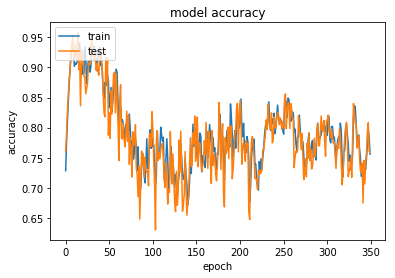

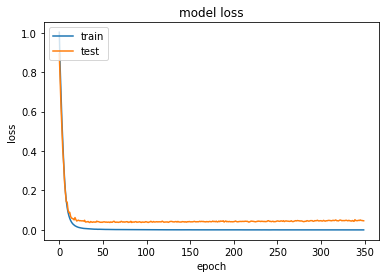

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
#for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
 #   input_seq = encoder_input_data[seq_index: seq_index + 1]
 #   decoded_sentence = decode_sequence(input_seq)
  #  print('-')
   # print('Input sentence:', input_texts[seq_index])
   # print('Decoded sentence:', decoded_sentence)
    
# Vectorize the data.
test_input_texts = []
test_target_texts = []
test_input_characters = set()
test_target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')
for line in test_lines[10005: 11005]:
    test_input_text, test_target_text = line.split(' ')
    # We use space(' ') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    test_target_text = ' ' + test_target_text + '\n'
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text)
    for char in test_input_text:
        if char not in test_input_characters:
            test_input_characters.add(char)
    for char in test_target_text:
        if char not in test_target_characters:
            test_target_characters.add(char)

test_input_characters = sorted(list(test_input_characters))
test_target_characters = sorted(list(test_target_characters))
test_num_encoder_tokens = len(test_input_characters)
test_num_decoder_tokens = len(test_target_characters)
test_max_encoder_seq_length = max([len(txt) for txt in test_input_texts])
test_max_decoder_seq_length = max([len(txt) for txt in test_target_texts])

print('Number of samples:', len(test_input_texts))
print('Number of unique input tokens:', test_num_encoder_tokens)
print('Number of unique output tokens:', test_num_decoder_tokens)
print('Max sequence length for inputs:', test_max_encoder_seq_length)
print('Max sequence length for outputs:', test_max_decoder_seq_length)

test_input_token_index = dict(
    [(char, i) for i, char in enumerate(test_input_characters)])
test_target_token_index = dict(
    [(char, i) for i, char in enumerate(test_target_characters)])

test_encoder_input_data = np.zeros(
    (len(test_input_texts), test_max_encoder_seq_length, test_num_encoder_tokens),
    dtype='float32')
test_decoder_input_data = np.zeros(
    (len(test_input_texts), test_max_decoder_seq_length, test_num_decoder_tokens),
    dtype='float32')
test_decoder_target_data = np.zeros(
    (len(test_input_texts), test_max_decoder_seq_length, test_num_decoder_tokens),
    dtype='float32')

for i, (test_input_text, test_target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, test_input_token_index[char]] = 1.
    for t, char in enumerate(test_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        test_decoder_input_data[i, t, test_target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            test_decoder_target_data[i, t - 1, test_target_token_index[char]] = 1.

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    test_input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    print(test_input_seq)
    test_decoded_sentence = decode_sequence(test_input_seq)
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('Decoded sentence:', test_decoded_sentence)

Number of samples: 1000
Number of unique input tokens: 56
Number of unique output tokens: 58
Max sequence length for inputs: 22
Max sequence length for outputs: 22
[[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

ValueError: Error when checking : expected input_1 to have shape (None, 66) but got array with shape (22, 56)

In [72]:
#data_path='newspaper(khela).txt'
#with open(data_path, 'r', encoding='utf-8') as f:

with open('newspaper(khela).txt','r', encoding='utf-8') as f:
    lst = []
    for line in f:
        words = line.split()
        for word in words:
            if word not in lst:
                lst.append(word)    # append only this word to the list, not all words on this line
    lst.sort()
    print(lst)
    for word in lst:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input word:',   word)
        print('Decoded word:', decoded_sentence)
    print(len(lst))

['অধিনায়ক', 'অনেকে', 'অন্য', 'অপেক্ষাতেই', 'অবিশ্বাস্য', 'অবিস্মরণীয়', 'অসম্ভব', 'আগেরবার', 'আন্তর্জাতিক', 'আবিষ্কার', 'আরেকটি', 'আল', 'আসছে', 'আসলে', 'ইসলামের', 'উইকেট', 'উদ্\u200cযাপন', 'উদ্\u200cযাপনের', 'এঁকেবেঁকে', 'এই', 'একই', 'একটা', 'একাদশে', 'এখন', 'এটি', 'এভাবেই', 'এমনকি', 'এর', 'ওপর', 'ওর', 'করতে', 'করে', 'করেছিলেন', 'করেছেন', 'কাছ', 'কাছে', 'কারণে', 'কাল', 'কাড়েন', 'কিংসে', 'কিন্তু', 'কী', 'কে', 'কোনো', 'ক্রিকেট', 'ক্রিকেটপ্রেমীদের', 'কয়েকবারই', 'খেলার', 'খেলোয়াড়', 'খেলোয়াড়দের', 'খেলোয়াড়েরা', 'খেলোয়াড়েরাও', 'গত', 'গিয়েছিল', 'গুনাতিলকা', 'গেছে', 'গোটা', 'গ্যালারিতে', 'চলছে', 'ছবি', 'ছিলেন', 'ছড়িয়ে', 'জনক', 'জবাব', 'জায়গা', 'জেতানোর', 'জয়', 'জয়ের', 'টিম', 'ট্যাড', 'ট্রফিতে', 'ড্যারেন', 'তবে', 'তাঁকে', 'তাঁর', 'তাই', 'তারপর', 'তিনি', 'তুলে', 'তো', 'ত্রিদেশীয়', 'থেকে', 'থেকেই', 'দর্শকদের', 'দল', 'দলে', 'দলের', 'দিয়ে', 'দুনিয়াই', 'দৃষ্টি', 'দেখানো', 'দেখালে', 'দেখে', 'দেন', 'দেননি', 'দেশের', 'দ্বারস্থ', 'নজরেও', 'নাগিন', 'নাচ', 'নাচকে', 'নাচছে', 'নাচের', 'নাজমুল', 'নাজমুলকে', 'ন

Input word: ম্যাচটা
Decoded word: ম্যাচ

Input word: ম্যাচে
Decoded word: ম্যাচ

Input word: ম্যানেজমেন্টের
Decoded word: ম্যানেজমেন্ট

Input word: যাঁর
Decoded word: যাঁর

Input word: যাওয়া
Decoded word: যাওয়া

Input word: যে
Decoded word: যে

Input word: যোগাযোগমাধ্যম
Decoded word: যোগাযোগমাধ্যম

Input word: যোগাযোগমাধ্যমে
Decoded word: যোগাযোগমাধ্যম

Input word: রহস্য
Decoded word: রহস্য

Input word: রহিম
Decoded word: রহিম

Input word: রাজশাহী
Decoded word: রাজশাহী

Input word: রাতে
Decoded word: রাত

Input word: লুফে
Decoded word: লুফ

Input word: শুধু
Decoded word: শুধু

Input word: শুরু
Decoded word: শুরু

Input word: শেষ
Decoded word: শেষ

Input word: শ্রীলঙ্কা
Decoded word: শ্রীলঙ্কা

Input word: শ্রীলঙ্কার
Decoded word: শ্রীলঙ্কা

Input word: সংক্রমিত
Decoded word: সংক্রমিত

Input word: সংবাদকর্মীরা
Decoded word: সংবাদকর্মী

Input word: সংবাদমাধ্যমও
Decoded word: সংবাদমাধ্যম

Input word: সফরে
Decoded word: সফর

Input word: সবখানেই
Decoded word: সবখান

Input word: সবার
Decoded

In [73]:
with open('newspaper(feature).txt','r', encoding='utf-8') as f:
    lst = []
    for line in f:
        words = line.split()
        for word in words:
            if word not in lst:
                lst.append(word)    # append only this word to the list, not all words on this line
    lst.sort()
    print(lst)
    for word in lst:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input word:',   word)
        print('Decoded word:', decoded_sentence)
    print(len(lst))

['অনুষ্ঠানে', 'অনেকে', 'অনেকের', 'অন্যদের', 'অবশ্য', 'অভিবাসী', 'অর্থ', 'আগ্রহ', 'আছে', 'আছেন', 'আনন্দে', 'আবার', 'আমন্ত্রণ', 'আমরা', 'আমাদের', 'আর', 'আলাদা', 'আলাপটা', 'আশাবাদকে', 'আশায়', 'আসবে', 'আয়োজনে', 'ইসলাম', 'উচ্চাকাঙ্ক্ষা', 'উদ্যোগ', 'উৎফুল্লে', 'এই', 'এক', 'একজন', 'একটি', 'একদিন', 'একশটি', 'একসময়', 'এখন', 'এগিয়ে', 'এটুকুই', 'এরপর', 'ও', 'ওয়ার্কার্স', 'কথা', 'কথাও', 'কবীর', 'কবীরের', 'করতে', 'করা', 'করার', 'করি', 'করেছে', 'করেছেন', 'করেন', 'কাউন্ট', 'কাছে', 'কাজ', 'কাজই', 'কাটানো', 'কারণ', 'কার্যালয়ে', 'কি', 'কিছু', 'কিন্তু', 'কীভাবে', 'কেনা', 'কেনার', 'কোনো', 'কয়েকজন', 'কয়েকটি', 'খবর', 'খুব', 'গলা', 'গল্পও', 'গান', 'গানচর্চার', 'গানপাগল', 'গানে', 'গানের', 'গিটার', 'গিটারিস্ট', 'গেছেন', 'গেল', 'গেলেন', 'গোষ্ঠীর', 'গোড়া', 'গড়বেন', 'গড়ে', 'ঘরবন্দী', 'চর্চা', 'চলত', 'চলার', 'চলে', 'চাকরির', 'চারজনের', 'চেষ্টা', 'ছিল', 'ছিলেন', 'ছুটি', 'ছুটির', 'ছেড়ে', 'ছোটবেলায়', 'ছড়াবে', 'ছয়', 'ছয়জন', 'ছয়জনের', 'জন্য', 'জমানো', 'জাকির', 'জানা', 'জানার', 'জায়গাও', 'জায়গায়', 'জেনেছি', 'ঝরে', 'টাইম

Input word: তিনটা
Decoded word: তিন

Input word: তিনিও
Decoded word: তিনি

Input word: তুলেছেন
Decoded word: তুলেছেন

Input word: তেমন
Decoded word: তেমন

Input word: তো
Decoded word: তো

Input word: তোলেন
Decoded word: তোলেন

Input word: ত্রিশ
Decoded word: ত্রিশ

Input word: থাকতেও
Decoded word: থাকত

Input word: থাকবে
Decoded word: থাকব

Input word: থাকলে
Decoded word: থাকল

Input word: থাকে
Decoded word: থাক

Input word: থাকেন
Decoded word: থাকেন

Input word: থাকেব
Decoded word: থাকেব

Input word: থেকেই
Decoded word: থেকে

Input word: দরদ
Decoded word: দরদ

Input word: দরদই
Decoded word: দরদ

Input word: দর্শক
Decoded word: দর্শক

Input word: দল
Decoded word: দল

Input word: দলটা
Decoded word: দল

Input word: দলটি
Decoded word: দল

Input word: দলটির
Decoded word: দল

Input word: দলভুক্ত
Decoded word: দলভুক্ত

Input word: দলের
Decoded word: দল

Input word: দিন
Decoded word: দিন

Input word: দিনটি
Decoded word: দিন

Input word: দিনমান
Decoded word: দিনমান

Input word: দিয়েছেন
Decoded

Input word: হারমোনিয়ামে
Decoded word: হারমোনিয়াম

Input word: হাড়ভাঙা
Decoded word: হাড়ভাঙা

Input word: হিসেবে
Decoded word: হিসেব

Input word: হয়
Decoded word: হয়

Input word: হয়তো
Decoded word: হয়তো

Input word: হয়নি
Decoded word: হয়নি

Input word: হয়ে
Decoded word: হয়

Input word: হয়েছিল
Decoded word: হয়েছিল

Input word: হয়েছে
Decoded word: হয়েছ

354


In [74]:
with open('newspaper(rabindranath).txt','r', encoding='utf-8') as f:
    lst = []
    for line in f:
        words = line.split()
        for word in words:
            if word not in lst:
                lst.append(word)    # append only this word to the list, not all words on this line
    lst.sort()
    print(lst)
    for word in lst:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input word:',   word)
        print('Decoded word:', decoded_sentence)
    print(len(lst))

['অকলঙ্ক', 'অকাল', 'অকালের', 'অক্ষয়', 'অঙ্কটাই', 'অঙ্কটাও', 'অঙ্কপাত', 'অট্টহাস্যে', 'অতএব', 'অতি', 'অত্যন্ত', 'অথচ', 'অধিকাংশ', 'অধিকার', 'অধীনে', 'অধ্যক্ষ', 'অনর্থক', 'অনাবশ্যক', 'অনুগামী', 'অনুমোদিত', 'অনেককেই', 'অন্ত', 'অন্তঃপুরিকার', 'অন্তরকে', 'অন্তে', 'অন্দরে', 'অন্ধকার', 'অন্য', 'অপথ্য', 'অপরাধীর', 'অপু', 'অবশেষে', 'অবসর', 'অবস্থা', 'অবাক', 'অবৈধ', 'অভদ্র', 'অভাব', 'অমন', 'অমৃতলোকে', 'অরুণোদয়', 'অর্থ', 'অর্থসমাগম', 'অর্থাৎ', 'অল্পদিনেই', 'অশ্রু', 'অশ্রুবিন্দুটি', 'অশ্রুশূন্য', 'অশ্রুহীন', 'অস্ফুট', 'আঁচেই', 'আইবড়', 'আঙুল', 'আচ্ছা', 'আছে', 'আজ', 'আত্মীয়া', 'আদরও', 'আনা', 'আনাগোনা', 'আনাড়ি', 'আনিতে', 'আপন', 'আপনাকে', 'আপনি', 'আপেক্ষিক', 'আবাদের', 'আবার', 'আভাসে', 'আভ্যন্তরিক', 'আমরা', 'আমাকে', 'আমাকেও', 'আমাদের', 'আমাদেরই', 'আমার', 'আমি', 'আমিই', 'আমৃত্যুকাল', 'আর', 'আরো', 'আলো', 'আলোচনাই', 'আশঙ্কা', 'আশা', 'আশীর্বাদ', 'আশীর্বাদে', 'আশ্চর্য', 'আশ্বাস', 'আসক্তি', 'আসছে', 'আসল', 'আসিবার', 'আসিলে', 'আসিয়া', 'আসিয়াছিল', 'আসিয়াছে', 'আস্থা', 'আহারসম্বন্ধে', 'ইংরাজি', 'ইচ্ছা', 'ইচ্ছাপূর

Input word: অট্টহাস্যে
Decoded word: অট্টহাস্থ

Input word: অতএব
Decoded word: অতরবৃ

Input word: অতি
Decoded word: অতি

Input word: অত্যন্ত
Decoded word: অত্যন্ত

Input word: অথচ
Decoded word: অহথ

Input word: অধিকাংশ
Decoded word: অধিকাংশ

Input word: অধিকার
Decoded word: অধিকার

Input word: অধীনে
Decoded word: অধীন

Input word: অধ্যক্ষ
Decoded word: অধ্যক্ষ

Input word: অনর্থক
Decoded word: অনর্থক

Input word: অনাবশ্যক
Decoded word: অনাবশ্যক

Input word: অনুগামী
Decoded word: অনুগামী

Input word: অনুমোদিত
Decoded word: অনুমোদি

Input word: অনেককেই
Decoded word: অনেক

Input word: অন্ত
Decoded word: অন্ত

Input word: অন্তঃপুরিকার
Decoded word: অন্তঃপুরিয়া

Input word: অন্তরকে
Decoded word: অন্তর

Input word: অন্তে
Decoded word: অন্ত

Input word: অন্দরে
Decoded word: অন্দর

Input word: অন্ধকার
Decoded word: অন্ধকার

Input word: অন্য
Decoded word: অন্য

Input word: অপথ্য
Decoded word: অপথ্য

Input word: অপরাধীর
Decoded word: অপরাধী

Input word: অপু
Decoded word: অপু

Input word: অবশেষে


Input word: কাজকর্ম
Decoded word: কাজকর্ম

Input word: কাজে
Decoded word: কাজ

Input word: কাটা
Decoded word: কাটা

Input word: কাটাও
Decoded word: কাটা

Input word: কাটাকাটি
Decoded word: কাটাকা

Input word: কাঠি
Decoded word: কাঠি

Input word: কাণ্ড
Decoded word: কাণ্ড

Input word: কানাকানি
Decoded word: কানাকানি

Input word: কান্নাহাসি
Decoded word: কান্নাহাসি

Input word: কাব্য
Decoded word: কাব্য

Input word: কারণ
Decoded word: কারণ

Input word: কারিগরের
Decoded word: কারিগর

Input word: কাল
Decoded word: কাল

Input word: কালি
Decoded word: কালি

Input word: কালো
Decoded word: কালো

Input word: কাহাকে
Decoded word: কাহা

Input word: কি
Decoded word: কি

Input word: কিছু
Decoded word: কিছু

Input word: কিছুক্ষণ
Decoded word: কিছুক্ষণ

Input word: কিছুতে
Decoded word: কিছু

Input word: কিছুতেই
Decoded word: কিছু

Input word: কিছুদিন
Decoded word: কিছুদিন

Input word: কিছুমাত্র
Decoded word: কিছামুত্র

Input word: কিঞ্চিৎ
Decoded word: কিঞ্চি

Input word: কিন্তু
Decoded word: কিন্তু


Decoded word: তবু

Input word: তবে
Decoded word: তব

Input word: তর্ক
Decoded word: তর্ক

Input word: তাঁহাকে
Decoded word: তাঁহা

Input word: তাঁহাদের
Decoded word: তাঁহাদ

Input word: তাঁহার
Decoded word: তাঁহার

Input word: তাই
Decoded word: তাই

Input word: তাকাইত
Decoded word: তাকাইত

Input word: তাকাইতে
Decoded word: তাকা

Input word: তানটি
Decoded word: তান

Input word: তাম্রশাসনে
Decoded word: তাম্রশাসন

Input word: তার
Decoded word: তার

Input word: তাহা
Decoded word: তাহা

Input word: তাহাকে
Decoded word: তাহা

Input word: তাহাতে
Decoded word: তাহা

Input word: তাহাদের
Decoded word: তাহাদ

Input word: তাহার
Decoded word: তাহার

Input word: তাহারই
Decoded word: তাহার

Input word: তাহারা
Decoded word: তাহারা

Input word: তাড়া
Decoded word: তাড়া

Input word: তিনটা
Decoded word: তিন

Input word: তিনি
Decoded word: তিনি

Input word: তুই
Decoded word: তুই

Input word: তুমি
Decoded word: তুমি

Input word: তুলিতেছে
Decoded word: তুলিছ

Input word: তৃতীয়
Decoded word: তৃতীয়

Input wor

Input word: প্রকাশ
Decoded word: প্রকাশ

Input word: প্রচলিত
Decoded word: প্রচলিত

Input word: প্রজাপতির
Decoded word: প্রজাপতি

Input word: প্রণাম
Decoded word: প্রণাম

Input word: প্রতি
Decoded word: প্রতি

Input word: প্রত্নতাত্ত্বিকদের
Decoded word: প্রত্নতাত্ত্বিক

Input word: প্রত্যেক
Decoded word: প্রত্যেক

Input word: প্রথম
Decoded word: প্রথম

Input word: প্রধান
Decoded word: প্রধান

Input word: প্রবঞ্চনা
Decoded word: প্রবঞ্চান

Input word: প্রবল
Decoded word: প্রবল

Input word: প্রবীণারা
Decoded word: প্রবীণা

Input word: প্রমাণ
Decoded word: প্রমাণ

Input word: প্রলোভন
Decoded word: প্রলোভন

Input word: প্রশ্ন
Decoded word: প্রশ্ন

Input word: প্রশ্নমাত্র
Decoded word: প্রশ্ন্তা

Input word: প্রস্তাবে
Decoded word: প্রস্তাব

Input word: প্রস্থান
Decoded word: প্রস্থান

Input word: প্রস্রবণ
Decoded word: প্রস্বরণ

Input word: পড়া
Decoded word: পড়া

Input word: পড়ার
Decoded word: পড়া

Input word: পড়িতেছে
Decoded word: পড়ি

Input word: পড়িবার
Decoded word: পড়িবার

Input word:

Input word: মাতৃভাষা
Decoded word: মাতৃভাষা

Input word: মাত্র
Decoded word: মাত্র

Input word: মানবী
Decoded word: মানবী

Input word: মানাইবে
Decoded word: মানাবে

Input word: মানাইল
Decoded word: মানাইল

Input word: মানিতে
Decoded word: মানি

Input word: মানুষ
Decoded word: মানুষ

Input word: মানুষের
Decoded word: মানুষ

Input word: মানে
Decoded word: মান

Input word: মার
Decoded word: মার

Input word: মাস
Decoded word: মাস

Input word: মাস্টার
Decoded word: মাস্টার

Input word: মায়ামমতা
Decoded word: মায়ামমতা

Input word: মিতা
Decoded word: মিতা

Input word: মিথ্যা
Decoded word: মিথ্যা

Input word: মিথ্যাবাদী
Decoded word: মিথ্যাবাদী

Input word: মুখ
Decoded word: মুখ

Input word: মুখস্থ
Decoded word: মুখস্থ

Input word: মুখে
Decoded word: মুখ

Input word: মুগ্ধবোধ
Decoded word: মুগ্ধবোধ

Input word: মুহূর্তটি
Decoded word: মুহূর্ত

Input word: মূর্তি
Decoded word: মূর্তি

Input word: মূল্য
Decoded word: মূল্য

Input word: মূঢ়তা
Decoded word: মূমতা

Input word: মৃত্যু
Decoded word: 

Input word: স্বাভাবিক
Decoded word: স্বাভাবিক

Input word: হইতাম
Decoded word: হইতাম

Input word: হইতে
Decoded word: হইত

Input word: হইতেছে
Decoded word: হইত

Input word: হইব
Decoded word: হইব

Input word: হইবার
Decoded word: হইবার

Input word: হইবে
Decoded word: হইব

Input word: হইল
Decoded word: হইল

Input word: হইলাম
Decoded word: হইলমা

Input word: হইলে
Decoded word: হইল

Input word: হইলেন
Decoded word: হইলেন

Input word: হইয়া
Decoded word: হইয়া

Input word: হইয়াও
Decoded word: হইয়া

Input word: হইয়াছিল
Decoded word: হয়াছিল

Input word: হইয়াছে
Decoded word: হইয়াছ

Input word: হউক
Decoded word: হংক

Input word: হট্টগোল
Decoded word: হট্ট

Input word: হঠাৎ
Decoded word: হঠাৎ

Input word: হাঁফ
Decoded word: হাঁফ

Input word: হাওয়া
Decoded word: হাওয়া

Input word: হাজার
Decoded word: হাজার

Input word: হাত
Decoded word: হাত

Input word: হাতখানি
Decoded word: হাত

Input word: হাতে
Decoded word: হাত

Input word: হাতেই
Decoded word: হাত

Input word: হাতের
Decoded word: হাত

Input word: হ

In [75]:
with open('newspaper(motamot).txt','r', encoding='utf-8') as f:
    lst = []
    for line in f:
        words = line.split()
        for word in words:
            if word not in lst:
                lst.append(word)    # append only this word to the list, not all words on this line
    lst.sort()
    print(lst)
    for word in lst:
        input_seq = get_input_data(word)
        decoded_sentence = decode_sequence(input_seq)
        print('Input word:',   word)
        print('Decoded word:', decoded_sentence)
    print(len(lst))

['অংশই', 'অংশগ্রহণ', 'অংশের', 'অক্ষুণ্ন', 'অগ্রাধিকার', 'অঙ্গনের', 'অতি', 'অথচ', 'অদ্ভুত', 'অধ্যাপক', 'অনুচ্ছেদের', 'অনেক', 'অনেকে', 'অন্তত', 'অন্যদিকে', 'অন্যরা', 'অন্যান্য', 'অনড়', 'অবদানের', 'অবস্থানে', 'অর্জনের', 'অর্থ', 'অর্থনীতির', 'অর্থনৈতিক', 'অর্থাৎ', 'অর্ধেক', 'অসামান্য', 'অসাম্য', 'অসুবিধাপ্রাপ্ত', 'আকবর', 'আক্ষেপ', 'আগ্রহী', 'আছে', 'আছেন', 'আত্মঘাতী', 'আদিবাসী', 'আনতে', 'আনা', 'আনিসুজ্জামানও', 'আন্দোলনে', 'আবশ্যক', 'আবার', 'আমরা', 'আমাদের', 'আমার', 'আর', 'আরেকটি', 'আরেফিন', 'আলি', 'আলোতেই', 'আসা', 'আসার', 'উচিত', 'উত্তীর্ণ', 'উদ্দেশ্যে', 'উনিশ', 'উন্নত', 'উন্নয়নশীল', 'উন্নয়নের', 'উপদেষ্টা', 'উপযুক্ত', 'উপায়', 'উল্টো', 'এ', 'এই', 'এক', 'একজন', 'একটা', 'একটি', 'একদিকে', 'একশ', 'একেবারে', 'এখন', 'এখনো', 'এখানে', 'এত', 'এনেছেন', 'এবং', 'এমন', 'এর', 'এসেছে', 'ও', 'কখনো', 'কথা', 'কথাই', 'কম', 'করছি', 'করছে', 'করছেন', 'করতে', 'করা', 'করার', 'করি', 'করিবার', 'করিবেন', 'করে', 'করেছে', 'করেছেন', 'করেননি', 'কর্মরত', 'কর্মী', 'কলেজে', 'কাজে', 'কারণ', 'কারণেই', 'কার্যকর', 'কি', 'কিছুদিন

Input word: কম
Decoded word: কম

Input word: করছি
Decoded word: করছি

Input word: করছে
Decoded word: করছ

Input word: করছেন
Decoded word: করছেন

Input word: করতে
Decoded word: কর

Input word: করা
Decoded word: করা

Input word: করার
Decoded word: করার

Input word: করি
Decoded word: করি

Input word: করিবার
Decoded word: করিবার

Input word: করিবেন
Decoded word: করিবেন

Input word: করে
Decoded word: কর

Input word: করেছে
Decoded word: করেছ

Input word: করেছেন
Decoded word: করেছেন

Input word: করেননি
Decoded word: করেননি

Input word: কর্মরত
Decoded word: কর্মরত

Input word: কর্মী
Decoded word: কর্মী

Input word: কলেজে
Decoded word: কলেজ

Input word: কাজে
Decoded word: কাজ

Input word: কারণ
Decoded word: কারণ

Input word: কারণেই
Decoded word: কারণ

Input word: কার্যকর
Decoded word: কার্যকর

Input word: কি
Decoded word: কি

Input word: কিছুদিন
Decoded word: কিছুদিন

Input word: কিন্তু
Decoded word: কিন্তু

Input word: কী
Decoded word: কী

Input word: কৃতজ্ঞ
Decoded word: কৃতজ্ঞ

Input word: ক

Input word: প্রজাতন্ত্রের
Decoded word: প্রজাত্নত্র

Input word: প্রজ্ঞাপনে
Decoded word: প্রজ্ঞাপন

Input word: প্রতি
Decoded word: প্রতি

Input word: প্রতিকার
Decoded word: প্রতিকার

Input word: প্রতিবন্ধী
Decoded word: প্রতিবন্ধী

Input word: প্রতিযোগিতামূলক
Decoded word: প্রতিযোগিতা

Input word: প্রতিষ্ঠার
Decoded word: প্রতিষ্ঠা

Input word: প্রত্যেক
Decoded word: প্রত্যেক

Input word: প্রথম
Decoded word: প্রথম

Input word: প্রবণতা
Decoded word: প্রবণতা

Input word: প্রবেশ
Decoded word: প্রবেশ

Input word: প্রশাসন
Decoded word: প্রশাসন

Input word: প্রশাসনও
Decoded word: প্রশাসন

Input word: প্রশাসনে
Decoded word: প্রশাসন

Input word: প্রশিক্ষণ
Decoded word: প্রশিক্ষণ

Input word: প্রান্তিক
Decoded word: প্রান্তিক

Input word: প্রার্থী
Decoded word: প্রার্থী

Input word: প্রার্থীকে
Decoded word: প্রার্থী

Input word: পড়াদের
Decoded word: পড়া

Input word: পড়াশোনা
Decoded word: পড়াশোনা

Input word: ফলে
Decoded word: ফল

Input word: বছর
Decoded word: বছর

Input word: বছরে
Decoded wor

Input word: স্প্লিন্টার
Decoded word: স্প্লিন্টার

Input word: স্বল্পোন্নত
Decoded word: স্বল্পোন্নত

Input word: স্বাধীনতার
Decoded word: স্বাধীনতা

Input word: স্বীকৃতির
Decoded word: স্বীকৃতি

Input word: হইবেন
Decoded word: হইবেন

Input word: হওয়া
Decoded word: হওয়া

Input word: হক
Decoded word: হক

Input word: হচ্ছে
Decoded word: হচ্ছ

Input word: হচ্ছেন
Decoded word: হচ্ছেন

Input word: হতে
Decoded word: হতে

Input word: হবে
Decoded word: হবে

Input word: হলেও
Decoded word: হল

Input word: হলো
Decoded word: হলো

Input word: হাজার
Decoded word: হাজার

Input word: হাতে
Decoded word: হাত

Input word: হার
Decoded word: হার

Input word: হারাচ্ছে
Decoded word: হারাচ্ছে

Input word: হালে
Decoded word: হাল

Input word: হিসেবে
Decoded word: হিসেব

Input word: হোক
Decoded word: হোক

Input word: হোসেন
Decoded word: হোসেন

Input word: হয়
Decoded word: হয়

Input word: হয়তো
Decoded word: হয়তো

Input word: হয়ে
Decoded word: হয়

Input word: হয়েছিল
Decoded word: হয়েছিল

Input word: হয়েছে
Decoded 